In [ ]:
import collections 
from collections import Counter
import pandas as pd
import numpy as np
import zipfile
import os
import tqdm
import pathlib
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import seaborn as sns

from scipy.stats import gmean

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import Accuracy

# Plotting libraries
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

plt.gray() #set colormap to gray 

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!pip install statsmodels==0.12.1

In [ ]:
metadata = pd.read_csv('/content/gdrive/MyDrive/Genetic Sequencing/data/2021 microbiome module/data_with_python_notebook/data/metadata.tsv', sep='\t')
qpcr = pd.read_csv('/content/gdrive/MyDrive/Genetic Sequencing/data/2021 microbiome module/data_with_python_notebook/data/qpcr.tsv', sep='\t')
perturbations = pd.read_csv('/content/gdrive/MyDrive/Genetic Sequencing/data/2021 microbiome module/data_with_python_notebook/data/perturbations.tsv', sep='\t')
asv_and_taxonomy = pd.read_csv('/content/gdrive/MyDrive/Genetic Sequencing/data/2021 microbiome module/data_with_python_notebook/data/asv_and_taxonomy.tsv', sep='\t')

counts = pd.read_csv('/content/gdrive/MyDrive/Genetic Sequencing/data/2021 microbiome module/data_with_python_notebook/data/counts.tsv', sep='\t')
counts = counts.rename(columns={'Unnamed: 0':'Amplicon'})

In [ ]:
metadata = pd.read_csv('metadata.tsv', sep='\t')
qpcr = pd.read_csv('qpcr.tsv', sep='\t')
counts = pd.read_csv('counts.tsv', sep='\t')
read_depth=counts.sum()[1:-1]
asv_and_taxonomy = pd.read_csv('asv_and_taxonomy.tsv', sep='\t')
perturbations = pd.read_csv('perturbations.tsv', sep='\t')
counts = counts.rename(columns={'Unnamed: 0':'Amplicon'})

### Data processing and reconciliation 

Initial explorations revealed that the data were not cleaned or otherwise processed in any way. To clean the data, we removed 110 ASVs with zero read counts across all time points. We transformed the remaining raw reads to account for varying sequencing depths across samples. Relative read counts were determined for each ASV by dividing the sum per time point, then multiplied by the geometric mean of the qPCR measurement replicates (equation 1) for a final table of relative abundance table by equation 3. For read count has value 0, we used 1/sum per time point to account for measurment error. For the few samples with missing time point data, we decided against removing the entire time point. Instead, we imputed the ASV relative abundances with the mean values for the group of mice receiving the same human fecal sample. The following analyses utilized the imputed count data.  

_Equation 1:_ 

$Total\_abundance_{t} = \sqrt[3]{measurement1_{t} \times measurement2_{t} \times measurement3_{t}}$

_Equation 2:_  
$Absolute\_abundance_{r,t} = Total_abundance_{t} \times \frac{relative\_read\_counts_{r,t}}{\sum(Absolute\_read\_counts_{r})}$ 

_Equation 3:_  
$Relative\_abundance_{c,t} = \frac{ Absolute_abundance_{c,t}}{\sum(Absolute\_abundance_{t})}$ 

_Note:_ r = ASV, t = measured time points across subjects, c = level of taxonomy

### Normalization and Log-transformation of the data

We took the **count.csv** file and normalized the read count for each time point by the sum of all the reads across time points to give the relative percent composition of all unique amplicon sequences for a given time point. Since a read count of zero could also be a result of a measurement error, we divided by the total reads per sample, $\frac{1}{\sum{read_t}}$. This also helps us visualize the data after log-transforming the measurement values. 

Processing geometric means in the log-space results in an approximately Gaussian distribution of values and allows for accessible visualizations of time-series data. Therefore, we log-transformed the absolute abundance of actual concentrations (CFU/g) in prediction. While Gaussian distributions are not required for the deep learning models we are implementing, log-transformation still provides a convenient way to visualize time series dynamics and results in model-able scales for prediction.



In [ ]:
##Merge count data and taxonomy file 
count_species = counts.merge(asv_and_taxonomy, left_on='Amplicon', right_on='name')

##geometric mean for qpcr 
qpcr = qpcr.copy()
qpcr['gmean'] = gmean(qpcr.iloc[:, 1:3], axis=1)


###Sum by column (sample)
##total counts per ASV 
normalized_counts = counts.copy()

normalized_counts['total_counts'] = np.sum(normalized_counts.iloc[:,1:],axis=1)

##Divide by total reads per sample
norm_matrix = normalized_counts.iloc[:normalized_counts.shape[0]-1 ,1:]
norm_count_matrix = norm_matrix.div( np.sum(normalized_counts.iloc[:,1:],axis=0) , axis=1)

##Remove ASV without any reads
norm_count_matrix = norm_count_matrix.loc[norm_count_matrix['total_counts']!=0,:]
norm_count_matrix = norm_count_matrix.drop(columns = "total_counts")

##Preserve count matrix merged with species information
normalized_matrix = count_species.loc[np.where(norm_matrix['total_counts']!=0)[0],:]

In [ ]:
################################################
#######Absolute abundance
################################################

time_sum = np.sum(counts.iloc[:,1:], axis=0)

fill_count = norm_count_matrix

# replace column zeros with 1/column sum
for i, col in enumerate(fill_count.columns):
    fill_count.loc[:,col].replace(0., 1/time_sum[i], inplace=True)

##Group by Class level
count_taxo = pd.concat([fill_count, asv_and_taxonomy.loc[np.where(norm_matrix['total_counts']!=0)[0],:] ], axis=1)
count_class = count_taxo.groupby('Class').sum()

##Times geometric mean of gPCR at each time point for absolute abundance 
absolu_abund = count_class.mul(qpcr['gmean'].values, axis=1)

### Mean imputation per sample by healthy donor and disease donor group 

The healthy donor and ulcerative colitis donor groups have distinct time-series patterns, with a highly correlated pattern within each group (Figure 1). Therefore, we decided to impute missing time points for individual subjects with the mean value of the other subjects in the same group at that same time point. For example, because subject 3 was missing data at timepoints D28PM and D37PM, we imputed with the mean values of the raw measurements from subjects 2, 4, and 5 (the rest of the healthy donor group) at both time points as an approximation. Similarly, subject 4 was missing D28PM, so measurement values were borrowed from subjects 2 and 5 to impute. In the ulcerative colitis donor group, subject 7 was missing time point at D57PM and subject 10 was missing data at time points D0PM, D28AM, and D28PM. We conducted a similar imputation approach for those missing values.

In [ ]:
class_sum = pd.concat([norm_count_matrix, normalized_matrix], axis=1)

#############################################
#######Imputation for the healthy donor group 
#############################################

### sample2
sample = 2
start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class2 = class_sum.iloc[:,start_index:end_index+1] 

full_name = [i.replace("2-","") for i in list(sample_class2.columns)]

###sample3
sample = 3

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class3 = class_sum.iloc[:,start_index:end_index+1] 
name = [i.replace("3-","") for i in list(sample_class3.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

##sample4 
sample = 4

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class4 = class_sum.iloc[:,start_index:end_index+1] 

name = [i.replace("4-","") for i in list(sample_class4.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

##sample5
sample = 5

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class5 = class_sum.iloc[:,start_index:end_index+1] 

name = [i.replace("5-","") for i in list(sample_class5.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

##Get average from nonmissing time points within healthy samples 
avg_18 = (sample_class2.loc[:,"2-"+full_name[18]] + sample_class5.loc[:,"5-"+full_name[18]])/2
avg_34 = (sample_class2.loc[:,"2-"+full_name[34]] +sample_class2.loc[:,"2-"+full_name[34]]+ sample_class5.loc[:,"5-"+full_name[34]] )/3

##Combine original data with imputed time points 
impute_sample3 = pd.concat([sample_class3.iloc[:,:18], pd.DataFrame(avg_18, columns=['3-'+full_name[18]]) ] , axis=1)
impute_sample3 = pd.concat([impute_sample3, sample_class3.iloc[:,18:34-1] ] , axis=1)
impute_sample3 = pd.concat([impute_sample3, pd.DataFrame(avg_34, columns=['3-'+full_name[34]]) ] , axis=1)
impute_sample3 = pd.concat([impute_sample3, sample_class3.iloc[:,34-1:] ] , axis=1)
impute_sample4 = pd.concat([sample_class4.iloc[:,:18], pd.DataFrame(avg_18, columns=['4-'+full_name[18]]) ] , axis=1)
impute_sample4 = pd.concat([impute_sample4, sample_class4.iloc[:,18:] ] , axis=1)

##Rename columns without sample numbers 
sample_class2.columns = [i.replace("2-","") for i in list(sample_class2.columns)]
impute_sample3.columns = [i.replace("3-","") for i in list(impute_sample3.columns)]
impute_sample4.columns = [i.replace("4-","") for i in list(impute_sample4.columns)]
sample_class5.columns = [i.replace("5-","") for i in list(sample_class5.columns)]

In [ ]:
#############################################
#######Imputation for the disease donor group 
#############################################

sample = 6

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class6 = class_sum.iloc[:,start_index:end_index+1] 
name = [i.replace("6-","") for i in list(sample_class6.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

sample = 7

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class7 = class_sum.iloc[:,start_index:end_index+1] 
name = [i.replace("7-","") for i in list(sample_class7.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

sample = 8

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class8 = class_sum.iloc[:,start_index:end_index+1] 
name = [i.replace("8-","") for i in list(sample_class8.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

sample = 9

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class9 = class_sum.iloc[:,start_index:end_index+1] 
name = [i.replace("9-","") for i in list(sample_class9.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

sample = 10

start_index = min(metadata.loc[(metadata.subject == sample),:].index)
end_index = max(metadata.loc[(metadata.subject == sample),:].index)
sample_class10 = class_sum.iloc[:,start_index:end_index+1] 
name = [i.replace("10-","") for i in list(sample_class10.columns)]
missing_name = list(set(full_name)-set(name))
[full_name.index(name) for name in missing_name]

###Average time points at complete samples  
avg_61 = (sample_class6.loc[:,"6-"+full_name[61]] + sample_class8.loc[:,"8-"+full_name[61]] + sample_class9.loc[:,"9-"+full_name[61]] + sample_class10.loc[:,"10-"+full_name[61]])/4
avg_1 = (sample_class6.loc[:,"6-"+full_name[1]] + sample_class8.loc[:,"8-"+full_name[1]] + sample_class9.loc[:,"9-"+full_name[1]] + sample_class7.loc[:,"7-"+full_name[1]])/4
avg_18 = (sample_class6.loc[:,"6-"+full_name[18]] + sample_class8.loc[:,"8-"+full_name[18]] + sample_class9.loc[:,"9-"+full_name[18]] + sample_class7.loc[:,"7-"+full_name[18]])/4
avg_17 = (sample_class6.loc[:,"6-"+full_name[17]] + sample_class8.loc[:,"8-"+full_name[17]] + sample_class9.loc[:,"9-"+full_name[17]] + sample_class7.loc[:,"7-"+full_name[17]])/4

avg1718 = pd.concat([avg_17, avg_18],axis=1)
avg1718.columns= ['10-'+full_name[17] , '10-'+full_name[18]] 

###Combine original data with imputed time points 
impute_sample7 = pd.concat([sample_class7.iloc[:,:61], pd.DataFrame(avg_61, columns=['7-'+full_name[61]]) ] , axis=1)
impute_sample7 = pd.concat([impute_sample7, sample_class7.iloc[:,61:] ] , axis=1)

impute_sample10 = pd.concat([sample_class10.iloc[:,:1], pd.DataFrame(avg_1, columns=['10-'+full_name[1]]) ] , axis=1)
impute_sample10 = pd.concat([impute_sample10, sample_class10.iloc[:,1:16] ] , axis=1)
impute_sample10 = pd.concat([impute_sample10, avg1718 ] , axis=1)
impute_sample10 = pd.concat([impute_sample10, sample_class10.iloc[:,16:] ] , axis=1)

##Rename columns without sample numbers 
sample_class6.columns = [i.replace("6-","") for i in list(sample_class6.columns)]
impute_sample7.columns = [i.replace("7-","") for i in list(impute_sample7.columns)]
sample_class8.columns = [i.replace("8-","") for i in list(sample_class8.columns)]
sample_class9.columns = [i.replace("9-","") for i in list(sample_class9.columns)]
impute_sample10.columns = [i.replace("10-","") for i in list(impute_sample10.columns)]

In [ ]:
################################################################
#######Imputation for the healthy donor group absolute abundance
################################################################

# impute for time 3 and 4
absolu_abund = absolu_abund.copy()
absolu_abund['3-D37PM'] = np.mean(absolu_abund[['2-D37PM', '4-D37PM', '5-D37PM']], axis=1)
absolu_abund['3-D28PM'] = np.mean(absolu_abund[['2-D28PM', '5-D28PM']], axis=1)
absolu_abund['4-D28PM'] = np.mean(absolu_abund[['2-D28PM', '5-D28PM']], axis=1)

################################################################
#######Imputation for the disease donor group absolute abundance
################################################################

absolu_abund = absolu_abund.copy()
absolu_abund['7-D57PM'] = np.mean(absolu_abund[['6-D57PM', '8-D57PM', '9-D57PM', '10-D57PM']], axis=1)
absolu_abund['10-D0PM'] = np.mean(absolu_abund[['6-D0PM', '7-D0PM', '8-D0PM', '9-D0PM']], axis=1)
absolu_abund['10-D28AM'] = np.mean(absolu_abund[['6-D28AM', '7-D28AM', '8-D28AM', '9-D28AM']], axis=1)
absolu_abund['10-D28PM'] = np.mean(absolu_abund[['6-D28PM', '7-D28PM', '8-D28PM', '9-D28PM']], axis=1)

# log transform and remove -inf
absolu_abund_log = absolu_abund.apply(np.log)

## EDA 

1. Healthy donor and ulcerative colitis donors revealed distinct time series patterns

Heatmap of pairwise Pearson correlations among patients across all ASV counts at each time point revealed that samples from healthy donors (samples 2-5) and samples from ulcerative colitis donors (samples 6-10) form distinct clusters. This heatmap confirmed that we could use group means to impute for missing time points mentioned in the previous section (Figure 1)

2. Total Abundance for the entire microbiome across time uncovers different trends for healthy donor and ulcerative colitis donor

To discover how trends in the aggregated microbiome change over time under specific perturbation, we took the log-transformed geometric averages of three measurements and plotted them for the entire 60-day interval. We display four such plots: subjects 2 and 3 from the healthy-donor group and subjects 7 and 9 from the ulcerative colitis donor (Figure 2).

The two healthy-donor subjects exhibited a non-decreasing trend after the high-fat diet perturbation while the ulcerative colitis-donor subjects exhibited an increasing trend before the subsequent treatment. Upon treatment with vancomycin, healthy-donor subjects displayed only a slightly decreasing trend in total abundance, indicating that the microbial community is pretty resistant to treatment by this particular antibiotic. On the other hand, ulcerative colitis-donor subjects displayed a steep decline in total abundance after vancomycin treatment. This decline indicates that the microbiome in ulcerative colitis is less robust to vancomycin, perhaps due to certain microbes being strongly eliminated, which can further impact the abundance of other microbes through microbe-microbe interactions. 

After treatment with gentamicin, healthy-donor subjects exhibited a gradually decreasing trend followed by a quick recovery during later time points. This phenomenon is indicative of microbe-microbe interactions. In comparison, the trend in ulcerative colitis-donor subjects leveled off, suggesting resistance to gentamicin in this microbiome without neglecting the possibility of tight and intrinsic interactions. Taken together, these results led us to think more about both the dynamics of major microbes at the taxonomic class level and the interactions with other microbes upon treatment with perturbation. (Figure 2)


3. Absolute abundance for top classes revels different dynamics 

Next, we were interested in summarizing the dynamics of the most abundant classes across the 60-day time interval. We selected two major classes – Clostridia and Bacteroidia – based on their frequency, which is then normalized by reads in percentage by class. One random subject from each donor group was chosen for visualization (subject 2 from the healthy-donor group and subject 6 from ulcerative colitis-donor group). The y-axis indicates log-transformed absolute abundance. Clostridia is shown in dotted blue; Bacteroidia is in dotted green. 

During high-fat diet perturbation, the abundance of the Bacteroidia class oscillated more frequently in the ulcerative colitis-donor subjects than in healthy-donor subjects. With the start of vancomycin antibiotic perturbation, Bacteroidia exhibited a rapid decrease followed by a quick recovery at the end of the perturbation interval in the healthy-donor subjects. Meanwhile, in ulcerative colitis-donor subjects, Bacteroidia exhibited a slow and marginal recovery. During gentamicin perturbation, Bacteroidia abundance was more dynamic in healthy-donor subjects than in ulcerative colitis-donor subjects, in which a stable change in abundance was observed. 

As for the class Clostridia, ulcerative colitis-donor subjects exhibited a gradually increasing trend in Clostridia abundance while healthy-donor subjects exhibited a more stable dynamic during high-fat perturbation. During vancomycin perturbation, the abundance of Clostridia increased in ulcerative colitis-donor subjects but remained constant in healthy-donor subjects. A similar trend is observed in both healthy and ulcerative colitis-donor groups upon gentamycin treatment. This result further shows that major classes of microbes have interesting dynamics upon treatment with different types of perturbations, possibly due to internal and direct interaction with the host or external and indirect interactions with other microbes (Figure 3)


4. Relative abundance of classes across time points 

Figure 4 presents the relative abundances of the selected classes (n=11) of microbes across time points on both donor types (Figure 4A for healthy-donor samples and 4B for ulcerative colitis-donor samples). Each column represents a time point and has a total abundance of 100% across the eleven selected classes. Each row represents a selected class across time points. The timepoints of perturbations described in section III are color-coded as well. These two plots illustrate that Bacteroidia has opposite trends compared to major classes such as Verrucomicrobiae during high-fat treatment in both healthy and diseased-donor samples. In healthy donor samples, Gammaproteobacteria has a distinct increase in percentage during Vancomycin treatment, while this phenomenon is unseen in the deceased donor samples. Both observations indicate that we can analyze relative abundance to model microbe-microbe interactions as well as microbe-host interactions.



### Figure 1. Heatmap of pairwise correlation among patient across all ASV counts

/usr/share/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


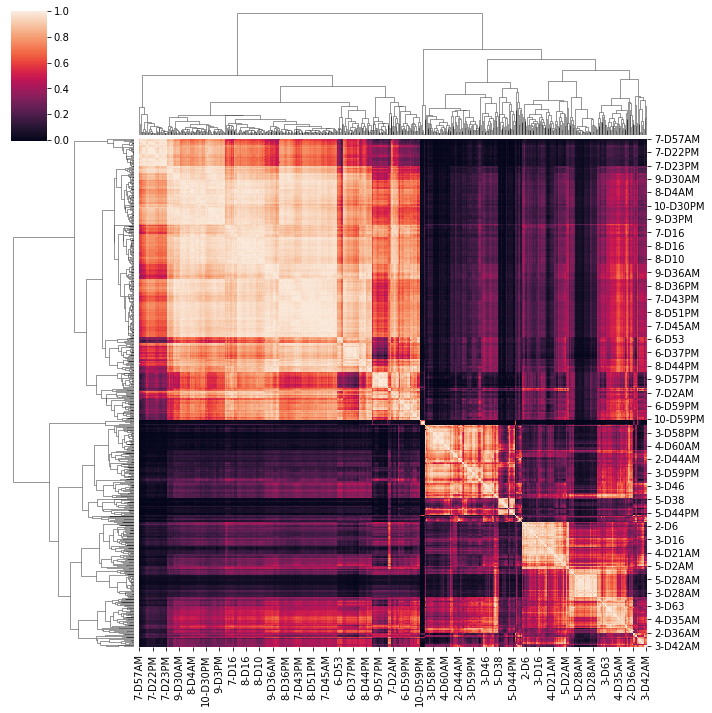

In [ ]:
pairwise = norm_count_matrix.corr('pearson') 
sns.clustermap(pairwise)

### Figure 2. Line plot of total abundance Across Time for randomly selected subjects 

In [ ]:
# left join metatdata to get the sample ID
qpcr_metadata = qpcr.merge(metadata, how='left', on='sampleID')

# first calc the geometric mean  for each sampleID
qpcr_metadata['average'] = gmean(qpcr.iloc[:, 1:3], axis=1)
qpcr_metadata['log_avg'] = np.log(qpcr_metadata['average'])

# get start time for all treatments
fat_start = perturbations[perturbations.name=='High Fat Diet'].iloc[0:1]['start'].values[0]
van_start = perturbations[perturbations.name=='Vancomycin'].iloc[0:1]['start'].values[0]
gen_start = perturbations[perturbations.name=='Gentamicin'].iloc[0:1]['start'].values[0]

# get end time for all treatments
fat_end = perturbations[perturbations.name=='High Fat Diet'].iloc[0:1]['end'].values[0]
van_end = perturbations[perturbations.name=='Vancomycin'].iloc[0:1]['end'].values[0]
gen_end = perturbations[perturbations.name=='Gentamicin'].iloc[0:1]['end'].values[0]

# get remaining time to the next interval which is the start time of the next treatment
fat_remain = van_start
van_remain = gen_start
gen_remain = np.max(qpcr_metadata.time) # the average interval is 14.5

<ipython-input-9-941142ff10f8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(qpcr_sel.sampleID, rotation = 90)
<ipython-input-9-941142ff10f8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(qpcr_sel.sampleID, rotation = 90)


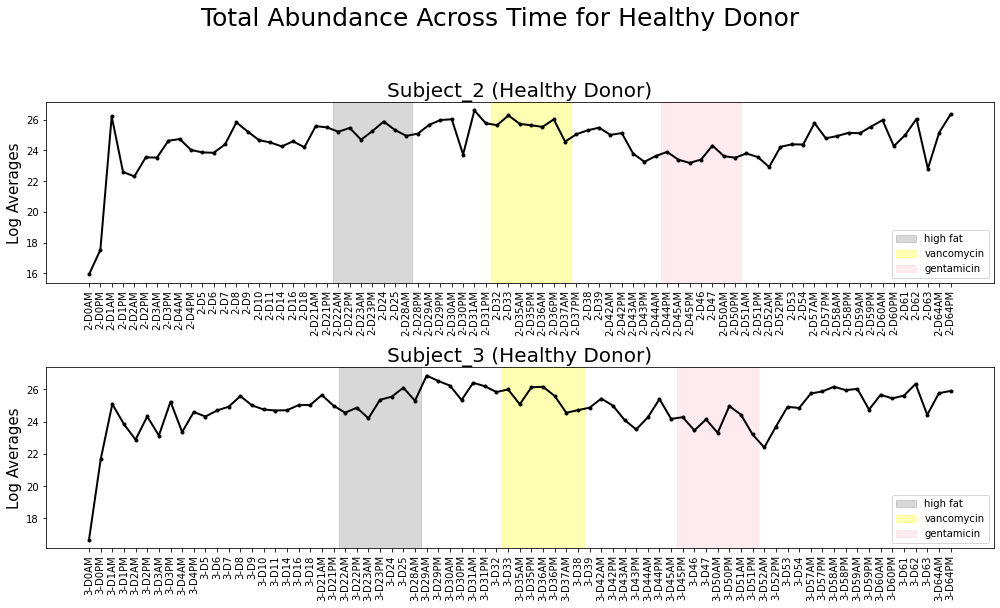

In [ ]:
# make the plot to the each subject
health_ids = [2,3]
fig, axs = plt.subplots(2, 1, figsize=(14, 8)); ax=axs.ravel()
for i, id in enumerate(health_ids):
    qpcr_sel = qpcr_metadata[qpcr_metadata.subject==id]
    qpcr_sel = qpcr_sel.sort_values(by="time")
    ax[i].plot(qpcr_sel.sampleID, qpcr_sel.log_avg, '.-', color='k', lw=2)
    ax[i].axvspan(fat_start, fat_end, alpha=0.3, color='gray', label='high fat')
  #ax[i].axvspan(fat_start, fat_remain, alpha=0.2, color='gray')
    ax[i].axvspan(van_start, van_end, alpha=0.3, color='yellow', label='vancomycin')
  #ax[i].axvspan(van_start, van_remain, alpha=0.2, color='blue')
    ax[i].axvspan(gen_start, gen_end, alpha=0.3, color='pink', label='gentamicin')
    #ax[i].axvspan(gen_start, gen_remain, alpha=0.2, color='red')
    ax[i].set_xticklabels(qpcr_sel.sampleID, rotation = 90)

    ax[i].set_ylabel('Log Averages', size=15)
    ax[i].set_title(f"Subject_{id} (Healthy Donor)", size=20)
    ax[i].legend(loc=4)
    
plt.suptitle('Total Abundance Across Time for Healthy Donor', size=25, y=1.05)
plt.tight_layout()
#plt.show()
# plt.savefig('/content/Figure1')

<ipython-input-10-769b30ccd658>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(qpcr_sel.sampleID, rotation = 90)
<ipython-input-10-769b30ccd658>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(qpcr_sel.sampleID, rotation = 90)


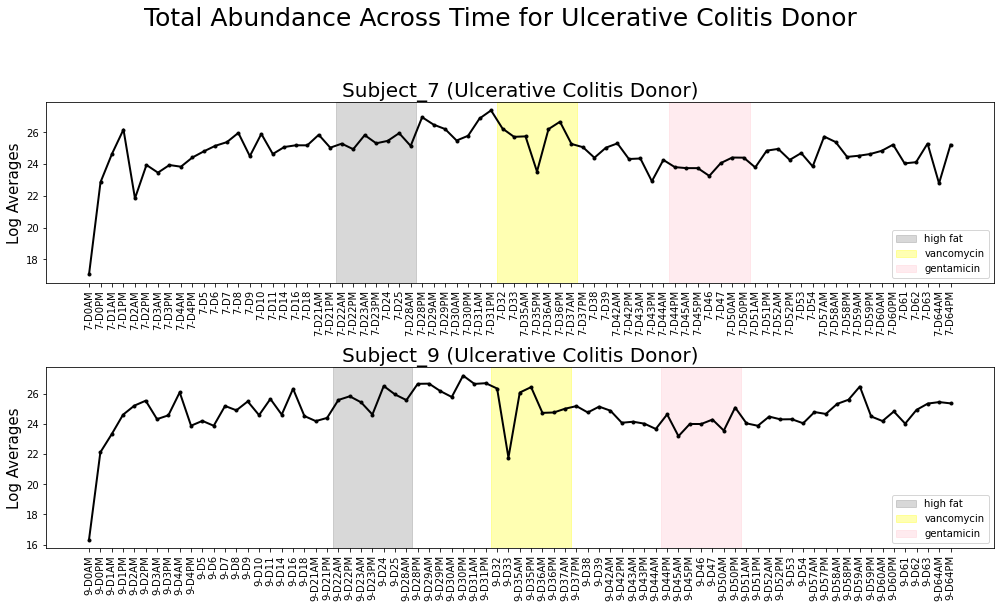

In [ ]:
# make the plot to the each subject
uc_ids = [7,9]
fig, axs = plt.subplots(2, 1, figsize=(14, 8)); ax=axs.ravel()
for i, id in enumerate(uc_ids):
  qpcr_sel = qpcr_metadata[qpcr_metadata.subject==id]
  qpcr_sel = qpcr_sel.sort_values(by="time")
  ax[i].plot(qpcr_sel.sampleID, qpcr_sel.log_avg, '.-', color='k', lw=2)

  ax[i].axvspan(fat_start, fat_end, alpha=0.3, color='gray', label='high fat')
  ax[i].axvspan(van_start, van_end, alpha=0.3, color='yellow', label='vancomycin')
  ax[i].axvspan(gen_start, gen_end, alpha=0.3, color='pink', label='gentamicin')
  
  ax[i].set_xticklabels(qpcr_sel.sampleID, rotation = 90)

  ax[i].set_ylabel('Log Averages', size=15)
  ax[i].set_title(f"Subject_{id} (Ulcerative Colitis Donor)", size=20)
  ax[i].legend(loc=4)
plt.suptitle('Total Abundance Across Time for Ulcerative Colitis Donor', size=25, y=1.05)
plt.tight_layout()
#plt.show()
# plt.savefig('/content/Figure2')

### Figure 3.  Line plot of relative abundance for classes Clostridia and Bacteroidia across time interval.

In [ ]:
counts['total_counts'] = np.sum(counts.iloc[:,1:], axis=1)
counts = counts[counts['total_counts'] != 0]
time_sum = np.sum(counts.iloc[:,1:], axis=0)

# normalize the count by reads first.
counts_norm = counts.iloc[:,1:]/time_sum
# uncoment below to attach the amplicon names
counts_norm = pd.concat([counts[['Amplicon']], counts_norm], axis=1)

# combine it with asv_and_taxonomy
count_taxo = counts_norm.merge(asv_and_taxonomy, how='left', left_on='Amplicon', right_on='name')

count_class = count_taxo.groupby('Class').sum()
count_class.drop(columns='total_counts', inplace=True)

# get the sampleID and geometric average
qpcr_avg = qpcr_metadata['average'].values
absolu_abund = count_class.mul(qpcr_avg, axis=1)

# log transform and remove -inf
absolu_abund_log = absolu_abund.apply(np.log)
absolu_abund_log = absolu_abund_log.replace(np.NINF, 0)

# get the time and sample ID and subject
time_subject = qpcr_metadata[['sampleID', 'time', 'subject']]
time_subject = time_subject.sort_values(by='time')

# get time for subject 2 and 6
time_2 = time_subject[time_subject.subject==2][['sampleID','time']]
time_6 = time_subject[time_subject.subject==6][['sampleID','time']]

## get each class time series
bacteroidia = absolu_abund_log.loc['Bacteroidia',:]
clostridia = absolu_abund_log.loc['Clostridia',:]

### index on subject 2 and 6 for bacteroidia
bacteroidia_2 = bacteroidia[time_2.index]
bacteroidia_6 = bacteroidia[time_6.index]

### index on subject 2 and 5 for clostridia
clostridia_2 = clostridia[time_2.index]
clostridia_6 = clostridia[time_6.index]

<ipython-input-12-61c31b5701c3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(time_2.sampleID, rotation = 90)
<ipython-input-12-61c31b5701c3>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(time_6.sampleID, rotation = 90)


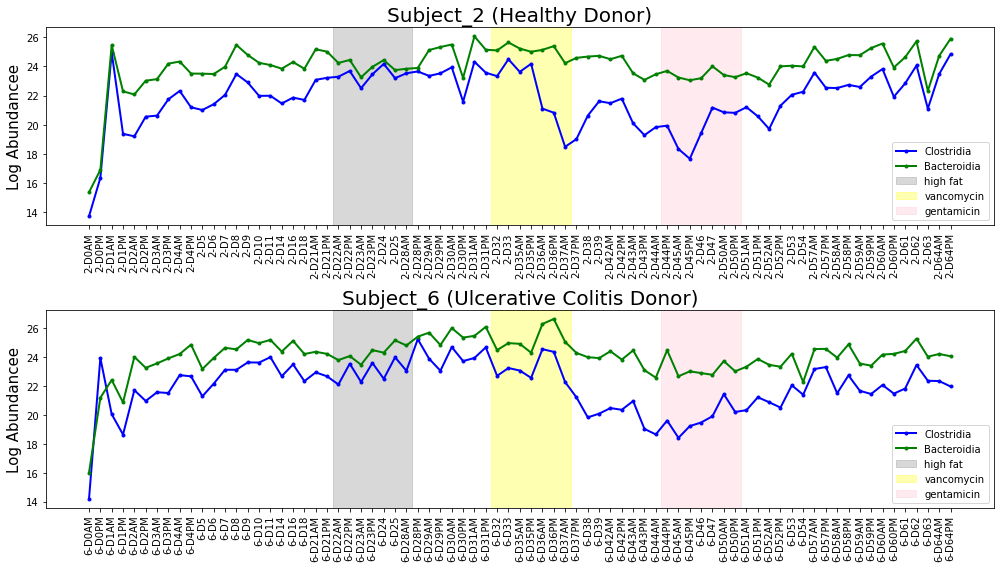

In [ ]:
# make the plot subject 2 healthy donor
class_name = ['Bacteroidia', 'Clostridia']

fig, axs = plt.subplots(2, 1, figsize=(14, 8)); ax=axs.ravel()
ax[0].plot(time_2.sampleID, clostridia_2, '.-', color='b', lw=2, label='Clostridia')
ax[0].plot(time_2.sampleID, bacteroidia_2, '.-', color='g', lw=2, label='Bacteroidia')
ax[0].axvspan(fat_start, fat_end, alpha=0.3, color='gray', label='high fat')
ax[0].axvspan(van_start, van_end, alpha=0.3, color='yellow', label='vancomycin')
ax[0].axvspan(gen_start, gen_end, alpha=0.3, color='pink', label='gentamicin')
ax[0].set_title("Subject_2 (Healthy Donor)", size=20)
ax[0].set_xticklabels(time_2.sampleID, rotation = 90)

ax[1].plot(time_6.sampleID, clostridia_6, '.-', color='b', lw=2, label='Clostridia')
ax[1].plot(time_6.sampleID, bacteroidia_6, '.-', color='g', lw=2, label='Bacteroidia')
ax[1].axvspan(fat_start, fat_end, alpha=0.3, color='gray', label='high fat')
ax[1].axvspan(van_start, van_end, alpha=0.3, color='yellow', label='vancomycin')
ax[1].axvspan(gen_start, gen_end, alpha=0.3, color='pink', label='gentamicin')
ax[1].set_title("Subject_6 (Ulcerative Colitis Donor)", size=20)
ax[1].set_xticklabels(time_6.sampleID, rotation = 90)

for i in range(2):
  ax[i].set_ylabel('Log Abundancee', size=15)
  ax[i].legend(loc=4)
plt.tight_layout()
#plt.show()
# plt.savefig('/content/Figure3')

### Figure 4. Relative abundance grouped by class for healthy and disease-donor samples

Index([         'Clostridia',         'Bacteroidia',    'Verrucomicrobiae',
          'Erysipelotrichia',  'Betaproteobacteria',                   nan,
       'Gammaproteobacteria', 'Alphaproteobacteria',       'Negativicutes',
                   'Bacilli', 'Deltaproteobacteria',      'Actinobacteria'],
      dtype='object')

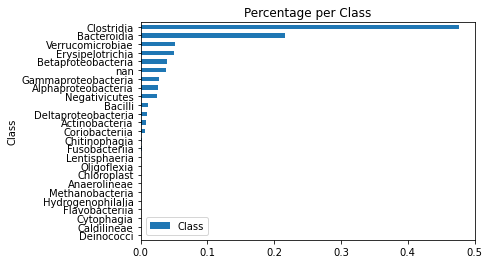

In [ ]:
###########################################################################
#######We chose to model the class level as it has most managable levels 
#######for understanding microbe-mircrobe interactions. 
###########################################################################
sum_class = pd.DataFrame.from_dict(Counter(asv_and_taxonomy.Class), orient="index", columns=['Class']).sort_values(by='Class', ascending=True).sum()
perc_class= pd.DataFrame.from_dict(Counter(asv_and_taxonomy.Class), orient="index", columns=['Class']).sort_values(by='Class', ascending=True).div(sum_class).plot.barh(ylabel="Percentage", 
title="Percentage per Class",
xlabel="Class")
class_perc_df = pd.DataFrame.from_dict(Counter(asv_and_taxonomy.Class), orient="index", columns=['Class']).sort_values(by='Class', ascending=False).div(sum_class)
class_perc_df = class_perc_df.copy()
class_perc_df['cumsum'] = np.cumsum(class_perc_df)
class_perc_df.index[np.where(class_perc_df['cumsum'].values<0.98)[0]]

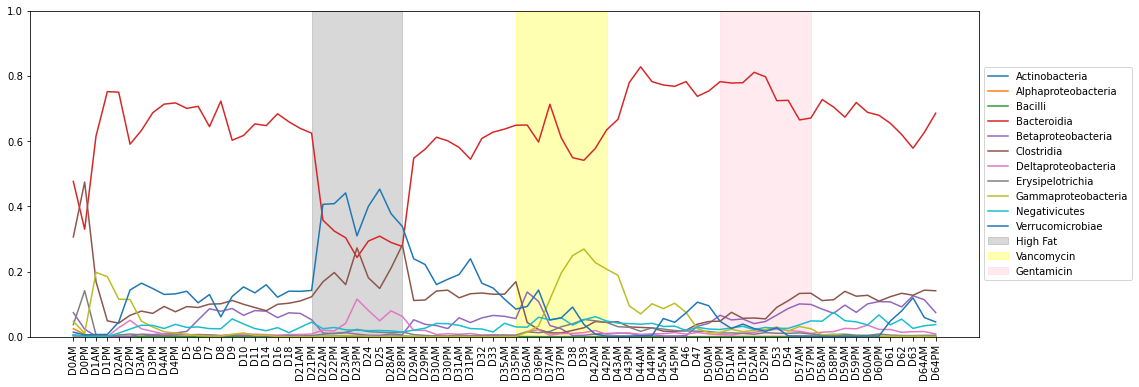

In [ ]:
#########################################################################
####### Fiugre 4A Relative abundance grouped by class for Healthy Donor 
#########################################################################

##Reorder time 
sample_metadata = metadata.loc[metadata.subject == 2,]
time_array = (sample_metadata.time)

new_time = sample_metadata.time.sort_values()
new_time.index = np.arange(new_time.shape[0])

##Gather all healthy samples 
healthy_sample = sample_class2.append(impute_sample3).append(impute_sample4).append(sample_class5)
taxon_info = normalized_matrix.append(normalized_matrix).append(normalized_matrix).append(normalized_matrix)
healthy_sample = pd.concat([healthy_sample, taxon_info], axis=1)

##Subset class variable
subset_class = list(class_perc_df.index[np.where(class_perc_df['cumsum'].values<0.98)[0]])

##Select subset classes 
healthy_sample_subset = healthy_sample[healthy_sample.Class.isin(subset_class)]
healthy_sample_group = healthy_sample_subset.groupby("Class").sum()
healthy_reorder = healthy_sample_group.iloc[:,list(sample_metadata.time.sort_values().index - min(sample_metadata.index))]

##Figure 4A Class compositions in healthy samples 
t_class = healthy_reorder.T
axes = t_class.div(t_class.sum(axis=1), axis=0).plot.line(rot=90, subplots=False, figsize=(17,6), ylim=(0,1))
axes.set_xticks(range(0,len(t_class.index)))
axes.set_xticklabels( list(t_class.index))
axes.axvspan(min((np.where(new_time>=21.5))[0]), 
                  min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label='High Fat')
    
axes.axvspan(min((np.where(new_time>=35.5))[0]), 
                  min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label='Vancomycin')
    
axes.axvspan(min((np.where(new_time>=50.5))[0]), 
                  min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label='Gentamicin')
    
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
plt.show()

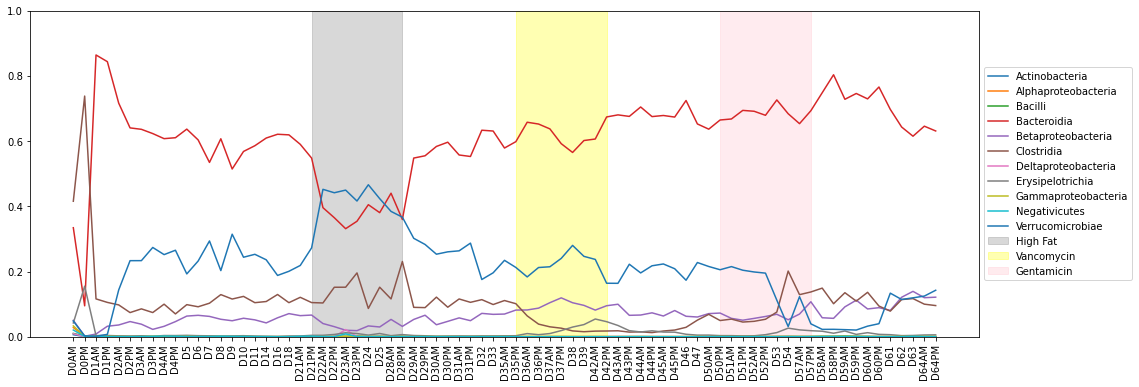

In [ ]:
####################################################################################
####### Figure 4B Relative abundance grouped by class for Ulcerative Colitis Donor 
#####################################################################################

taxon_info = taxon_info.append(normalized_matrix)
disease_sample = sample_class6.append(impute_sample7).append(sample_class8).append(sample_class9).append(impute_sample10)
disease_sample = pd.concat([disease_sample, taxon_info ], axis=1)
disease_sample_subset = disease_sample[disease_sample.Class.isin(subset_class)]
disease_sample_group = disease_sample_subset.groupby("Class").sum()
disease_reorder = disease_sample_group.iloc[:,list(sample_metadata.time.sort_values().index - min(sample_metadata.index))]

t_class = disease_reorder.T
axes = t_class.div(t_class.sum(axis=1), axis=0).plot.line(rot=90, subplots=False, figsize=(17,6), ylim=(0,1))
axes.set_xticks(range(0,len(t_class.index)))
axes.set_xticklabels( list(t_class.index))
axes.axvspan(min((np.where(new_time>=21.5))[0]), 
                  min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label='High Fat')
    
axes.axvspan(min((np.where(new_time>=35.5))[0]), 
                  min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label='Vancomycin')
    
axes.axvspan(min((np.where(new_time>=50.5))[0]), 
                  min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label='Gentamicin')
    
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
plt.show()

## Multi-head time series prediction and donor type classification 

The human microbiome is a dynamic system of trillions of organisms interacting with each other and their human host. These microbe-microbe and host-microbe interactions evolve in response to perturbations like changes in diet or treatment by drugs and antibiotics. Understanding these changes can provide insights into how to shape the microbiome to benefit the host1. In light of the nonlinear relationship among microbes, recent research has increasingly utilized artificial neural networks (ANN) to model microbial communities. An advantage to using an ANN to model microbial dynamical change is theability to conduct predictive *in silico* experiments by artificially perturbing input data to predict the perturbation effect on the entire microbial composition3. 

Built upon the work by Benjamino et al., we propose a GRU-based neural network to model the microbial composition and absolute abundance at each time point. We have two model types: one to model the microbial composition at each time point within a subset of classes and a second model to predict absolute abundance at each time point. Both models also classify whether the sample predicted is from a healthy or disease donor. Once our multi-head and multi-directional models are well-trained, determined by a sufficiently small MSE, we will conduct *in-silico* experiments by perturbing inputs for prediction. Our investigations can answer the following questions:

1) How is change in abundance of one microbial class at a certain treatment interval affect other class compositions and their absolute abundance?

2) Among all classes present in our model, which microbe change has the largest influence on other classes?

3) For both questions aforementioned, can we also answer how these are changes similar or different in healthy versus ulcerative colitis groups?


### Section I - Multi-head prediction of class composition through time 

Given the sparsity of the data, we utilized three primary time-series data augmentation methods to improve model performance:

1. _STL Decomposition:_  
Decomposition-based augmentation method can be useful if there is a sufficient evidence that the collected data contains noise. One common approach tbat has been adopted successfully is STL decomposition. The idea is for each time point, $x_t$, it is composed of: $$x_t = \tau_t + s_t + r_t$$

These components are trend signals ($\tau_t$), seasonal/periodic signals ($s_t$), and remainder signals ($r_t$)$^{1}$. One special STL decomposition is robust STL decomposition, which incorporates a weighted version of the data that is more resistent to outliers$^{2}$. In this project, we implemented both robust and non-robust STL decompositions to capture de-noised time series data. Because our data spans a short period of time and lacks a seasonality component, we mainly used the trend signal ($s_t$) to smooth out the data. 


2. _Add slope:_  
A common approach to help capture more variations in time series data is to add some noise pattern, such as slope-like trends, directly to the data itself$^{3}$. In this project, we implemented the addition of a linear trend using the first-moment ($x_{t+1} - x_{t}$ for all $t$) as an approximation. 

3. _Permutation of order:_  
Permutation can also be an effective method to produce new patterns of time series data$^{4}$. Given that each perturbation type, in our case a high-fat diet and antibiotic treatment, is independent of each other, we permuted the sequence of perturbations to give us $4! = 24$ variations for each sample to predict relative abundance at every time point. Time dependencies, however, are not retained during permutation. Therefore, we do not implement order permutation in the absolute abundance (CFU/g) prediction.


_Citation:_  
1. Robert B Cleveland, William S Cleveland,
Jean E McRae, and Irma Terpenning. STL: A seasonal-trend decomposition procedure based on loess. Journal of Official Statistics, 6(1):3–73, 1990.

2. Qingsong Wen, Jingkun Gao, Xiaomin Song,
Liang Sun, Huan Xu, and Shenghuo Zhu. RobustSTL: A robust
seasonal-trend decomposition algorithm for long time series. In
AAAI, volume 33, pages 5409–5416, 2019.

3. Qingsong Wen., Liang Sun.,  Fan Yang.,  Xiaomin Song.,  Jingkun Gao.,  Xue Wang &  Huan Xu. Time Series Data Augmentation for Deep Learning: A Survey. ArXiv, abs/2002.12478, 2020.

4. Brian Kenji Iwana & Seiichi Uchida. An Empirical Survey of Data Augmentation for Time Series Classification with Neural Networks: A Survey. ArXiv, 15951, 2020. 8, 2020..


This model takes in the relative abundance matrix from T0-T(n-1) time points across the eleven chosen classes for each sample. The outputs of this model include next time point prediction of class composition T1-Tn and the sample binary category of healthy or disease-donor sample.

We tuned model hyperparameters by performing a hyperparameter search to identify the best learning rate, number of training epochs, and last-layer activation functions using only the time-series output. The optimal hyperparameters were applied to the multi-head model training leaving one of the nine samples out at a time and evaluating mean squared error (MSE) at test time. This experiment indicates which sample may be more correctly predicted than the others. To get uncertainty measures, we also conducted leave-two-out model training. We leave out one sample from the healthy group and one sample from the disease group at each training, for a total of 20 combinations. After both experiments, we chose a learning rate of 1e-4 and a linear activation function for the dense layer before the output layer to predict relative abundance at every time point. For the absolute abundance prediction, we chose a learning rate of 1e-2 and a linear activation function for the dense layer before the output layer.


In [ ]:
from statsmodels.tsa.seasonal import STL
from itertools import permutations 
from sklearn.metrics import mean_squared_error
import itertools as it

#### Data augmentation functions

In [ ]:
#######################################
#### Data Augmentation helper functions
#######################################

def relative_abundance(subset, sample, taxon, subset_class):
    '''
    subset: pd data frame with mean imputation per group
    sample: it has no bearing in the new function, potentially change to taxonomy level 
    taxon: taxon level 
    subset_class: level at which taxon is included 
    
    '''
    ##add taxonomy information
    class_matrix = pd.concat([subset , normalized_matrix],axis=1)
    
    ##select subset
    class_matrix = class_matrix[class_matrix[taxon].isin(subset_class)] 
    
    ##Group by Class in each sample individually 
    class_matrix = class_matrix.groupby(taxon).sum() 
    
    ##Reorder time points for each sample, drop taxonomy information 
    class_matrix = class_matrix.iloc[:,list(sample_metadata.time.sort_values().index - min(sample_metadata.index))]
    
    ##calculate relative abundance
    t_class = class_matrix.T
    sample_abundance = t_class.div(t_class.sum(axis=1), axis=0)
    
    ##Trim last time step for X
    sample_x = sample_abundance.iloc[:-1,:]
    
    ##Trim first time step for Y
    sample_y = sample_abundance.iloc[1:,:]
    
    sample_x = np.array(sample_x)
    sample_x = np.reshape(sample_x, ( 1,sample_x.shape[0], sample_x.shape[1]))
    
    sample_y = np.array(sample_y)
    sample_y = np.reshape(sample_y, ( 1,sample_y.shape[0], sample_y.shape[1]))
    
    return sample_abundance , np.array(sample_x) , np.array(sample_y)


def loess_trend(sample , robust):
    '''
    sample = sample_abundance output from relative_abundance
    robust = Boulean argument defining whether loess curve is calculated with robust version
    '''
    ##For each column calculates the loess estimate with STL decomposition
    sample_list = []
    for i in range(sample.shape[1]):
        stl = STL(sample.iloc[:,i], seasonal=3, period = 4, robust= robust)
        res = stl.fit()
        sample_list.append(res.trend)
    sample_df = pd.DataFrame(sample_list).T
    sample_df.columns = sample.columns
    
    ##Create X input and Y response for time series prediction by shifting time point by 1
    ##Trim last time step for X
    sample_x = sample_df.iloc[:-1,:]
    
    ##Trim first time step for Y
    sample_y = sample_df.iloc[1:,:]
    
    sample_x = np.array(sample_x)
    sample_x = np.reshape(sample_x, ( 1,sample_x.shape[0], sample_x.shape[1]))
    
    sample_y = np.array(sample_y)
    sample_y = np.reshape(sample_y, ( 1,sample_y.shape[0], sample_y.shape[1]))
    
    return sample_df, sample_x, sample_y


def add_slope(sample):
    '''
    sampel = sample_abundance output from relative_abundance
    '''
    
    ##T1 to Tn
    plus_one = sample.copy()
    plus_one = plus_one.iloc[1:,:]
    plus_one.index = np.arange(plus_one.shape[0])
    
    ##T0 to Tn-1
    minus_one = sample.copy()
    minus_one = minus_one.iloc[0:sample.shape[0]-1 ,:]
    minus_one.index = np.arange(minus_one.shape[0])
    
    ##Slope = first moment = Tn-Tn-1
    firstmoment = plus_one.subtract(minus_one, axis=0)
    firstmoment.index = sample.index[1:]
    
    ##Add slope to the original data 
    augment_linear = sample.iloc[1:,:].add(firstmoment.iloc[:,:])
    
    ##T0 slope = 0 
    augment_linear_data = pd.DataFrame(sample.iloc[0,:]).T.append(augment_linear)
    
    ##Create X input and Y response for time series prediction by shifting time point by 1
    ##Trim last time step for X
    sample_x = augment_linear_data.iloc[:-1,:]
    
    ##Trim first time step for Y
    sample_y = augment_linear_data.iloc[1:,:]
    
    sample_x = np.array(sample_x)
    sample_x = np.reshape(sample_x, ( 1,sample_x.shape[0], sample_x.shape[1]))
    
    sample_y = np.array(sample_y)
    sample_y = np.reshape(sample_y, ( 1,sample_y.shape[0], sample_y.shape[1]))
    
    return firstmoment, augment_linear_data, sample_x, sample_y

def perm_sample(sample, healthy_X, healthy_Y, sequence_order):
    
    '''
    perm_sample permutates intervals of treatments assuming that each treatment is independent from each other
    
    sample = sample_abundance output from relative_abundance
    healthy_X = combined input data
    healthy_Y = combined output variable
    sequence_order = lists of [0,1,2,3] order to save permuted sequence
    '''
    
    ##index bounds of each treatment from ordered-time list
    indx_p0 = ( 0 , min(np.where(new_time>=21.5))[0])
    indx_p1 = ( min(np.where(new_time>=21.5))[0] , min(np.where(new_time>=35.5))[0]) 
    indx_p2 = ( min(np.where(new_time>=35.5))[0] , min(np.where(new_time>=50.5))[0]) 
    indx_p3 = ( min(np.where(new_time>=50.5))[0] , len(new_time)) 
    
    ##specify regions of treatments in a sample
    sec1= sample.iloc[indx_p0[0]:indx_p0[1],:]
    sec2= sample.iloc[indx_p1[0]:indx_p1[1],:]
    sec3= sample.iloc[indx_p2[0]:indx_p2[1],:]
    sec4= sample.iloc[indx_p3[0]:indx_p3[1],:]
    
    permute_list = [sec1, sec2, sec3, sec4]
    
    ##Permutate for 24 combinations
    perm = permutations([0,1,2,3]) 
    perm_index = [i for i in list(perm)]
    
    for k in perm_index:
        
        ##Newly permutated relative abundance dataframe
        df = [permute_list[i] for i in k]
        concatdf = pd.concat(df)
        
        ##Shift time points for X, Y of the newly-ordered data 
        ##Trim last time step for X
        sample_x = concatdf.iloc[:-1,:]
        
        ##Trim first time step for Y
        sample_y = concatdf.iloc[1:,:]
        
        sample_x = np.array(sample_x)
        sample_x = np.reshape(sample_x, ( 1,sample_x.shape[0], sample_x.shape[1]))
    
        sample_y = np.array(sample_y)
        sample_y = np.reshape(sample_y, ( 1,sample_y.shape[0], sample_y.shape[1]))
        
        ##Add augmentation to the newly ordered data
        ##Non robust loess
        sample_loess, sample_loessX, sample_loessY = loess_trend(concatdf, False)
        ##Robust loess
        sample_loessr, sample_loessXr, sample_loessYr = loess_trend(concatdf, True)
        ##Add first moment 
        firstmoment, augment_linear_data, sample_slopex, sample_slopey = add_slope(concatdf)
        
        ##Combine all augmented data together for X, Y 
        X = np.concatenate([sample_x, sample_loessX, sample_slopex, sample_loessXr])
        Y = np.concatenate([sample_y, sample_loessY, sample_slopey, sample_loessYr])
        
        ##Record order of the permutated sequence
        seq_order = np.repeat(np.reshape(k, (1,4)), 4,axis=0)
        sequence_order = np.concatenate([sequence_order ,seq_order], axis=0)
        
        ##Recursively add newly permutated and augmented data to the training set 
        healthy_X = np.append(healthy_X , X ,axis=0)
        healthy_Y = np.append(healthy_Y , Y ,axis=0)
    
    return healthy_X, healthy_Y, sequence_order


#### Figure 5. Illustation of loess and add slope functions for data augmentation 

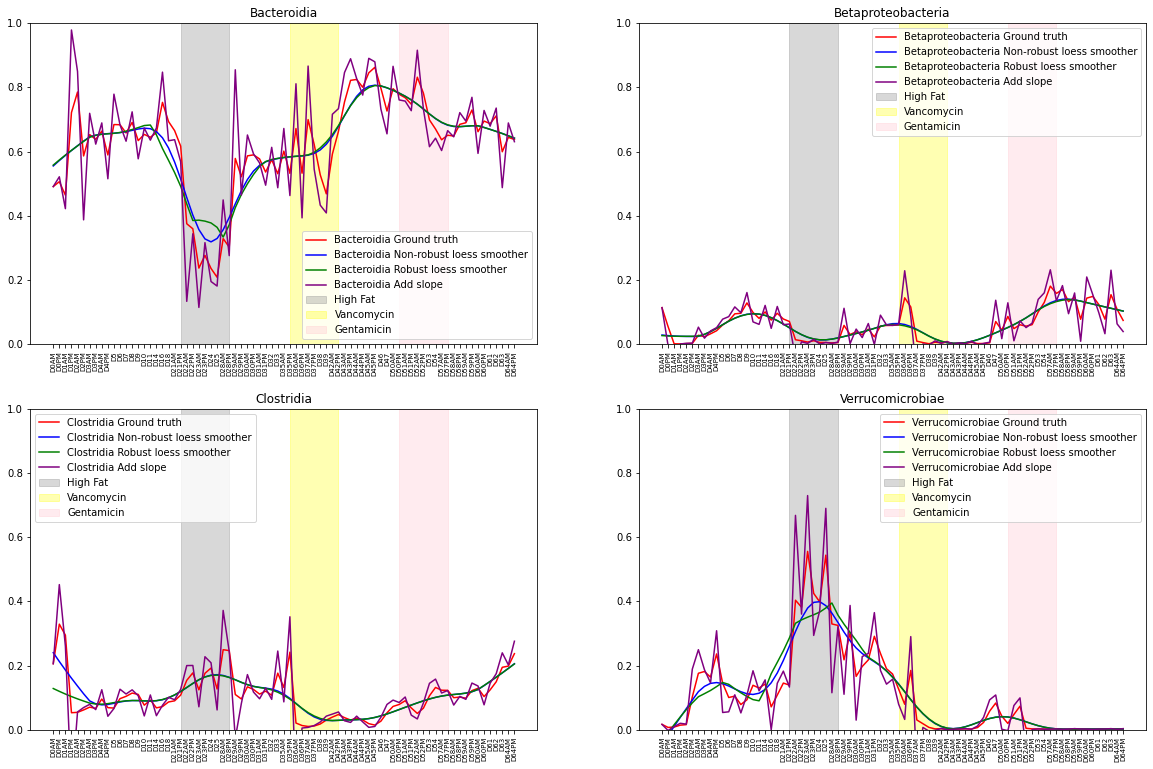

In [ ]:
####################################################
###Figure 5A Data Augmentaiton on relative abundance 
#####################################################

### Take sample2's data augmentation for example 

sample2, sample2_x, sample2_y = relative_abundance(sample_class2, 2 , taxon,  subset_class)
sample2_loess, sample2_loessX,sample2_loessY = loess_trend(sample2, False)
sample2_loessr, sample2_loessX,sample2_loessY = loess_trend(sample2, True)
sample2_slope, sample2_addslope, sample2_slopeX, sample2_slopeY = add_slope(sample2)

column_select = [3,4,5,10]

fig, ax = plt.subplots(2,2 , figsize =(20,13))
for n , axs, in enumerate(ax.ravel()):
    
    i = column_select[n]
    name = sample2.columns[column_select[n]]
    axs.plot(sample2.iloc[:,i], label = name +" Ground truth", color = "red")
    axs.plot(sample2_loess.iloc[:,i], label = name +" Non-robust loess smoother", color = "blue")
    axs.plot(sample2_loessr.iloc[:,i], label = name +" Robust loess smoother", color = "green")
    axs.plot(sample2_addslope.iloc[:,i], label = name +" Add slope", color = "purple")
    
    axs.set_title(name)
    axs.set_ylim((0,1))

    axs.axvspan(min((np.where(new_time>=21.5))[0]), 
                      min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray',label="High Fat")
    axs.axvspan(min((np.where(new_time>=35.5))[0]), 
                      min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label="Vancomycin")
    axs.axvspan(min((np.where(new_time>=50.5))[0]), 
                      min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label="Gentamicin")
    
    axs.set_xticks(range(0,len(sample2.index)))
    axs.set_xticklabels(list(sample2.index),rotation=90, fontsize = 7 )
    axs.legend()

plt.show()  
fig.savefig("aug_rel.png")

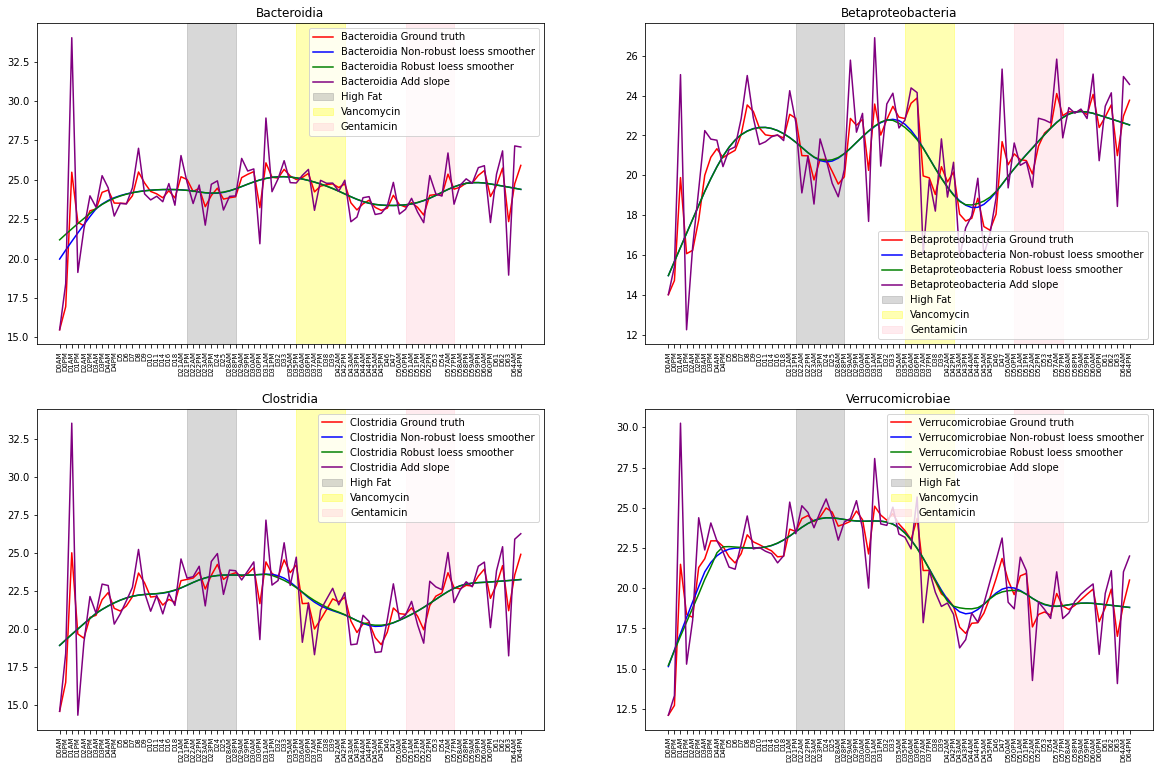

In [ ]:
####################################################
###Figure 5A Data Augmentaiton on absolute abundance 
#####################################################

### Take sample2's data augmentation for example 

absample2, absample2_x, absample2_y = absolute_abudance(class_list, time_2,2)
sample2_loess, sample2_loessX,sample2_loessY = loess_trend(absample2, False)
sample2_loessr, sample2_loessX,sample2_loessY = loess_trend(absample2, True)
sample2_slope, sample2_addslope, sample2_slopeX, sample2_slopeY = add_slope(absample2)

column_select = [3,4,5,10]

fig, ax = plt.subplots(2,2 , figsize =(20,13))
for n , axs, in enumerate(ax.ravel()):
    
    i = column_select[n]
    name = sample2.columns[column_select[n]]
    axs.plot(absample2.iloc[:,i], label = name +" Ground truth", color = "red")
    axs.plot(sample2_loess.iloc[:,i], label = name +" Non-robust loess smoother", color = "blue")
    axs.plot(sample2_loessr.iloc[:,i], label = name +" Robust loess smoother", color = "green")
    axs.plot(sample2_addslope.iloc[:,i], label = name +" Add slope", color = "purple")
    
    axs.set_title(name)
    #axs.set_ylim((0,1))

    axs.axvspan(min((np.where(new_time>=21.5))[0]), 
                      min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray',label="High Fat")
    axs.axvspan(min((np.where(new_time>=35.5))[0]), 
                      min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label="Vancomycin")
    axs.axvspan(min((np.where(new_time>=50.5))[0]), 
                      min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label="Gentamicin")
    
    axs.set_xticks(range(0,len(sample2.index)))
    axs.set_xticklabels(list(sample2.index),rotation=90, fontsize = 7 )
    axs.legend()

plt.show()  
fig.savefig("aug_abs.png")

#### Leave-out sample functions

In [ ]:
##################################################
#### Leave-out sample experiment helper functions
##################################################

def leave_out(sample, 
                      h_samplex, h_loesssamplex, h_slopex, h_rlossx, 
                      h_sampley, h_loesssampley, h_slopey, h_rlossy ):
    '''
    Leave out function prevents adding augmented data of the test sample in the training set 
    
    sample: list of index without the sample index being left out. eg [0,1,2] leave out 3 in healhty case 
    h_samplex: lists of np array for original relative abundance matrix per sample
    h_loesssamplex: lists of np array for loess curve of relative abundance matrix per sample
    h_slopex: lists of np array for added non-robust slope relative abundance matrix per sample
    h_rlossx: lists of np array for robust loess relative abundance matrix per sample 
    h_sampley, h_loesssampley, h_slopey, h_rlossy: same as x data but for y response per time point 
    '''
    x_list = []
    
    for i in sample:
        x_list.append(h_samplex[i]) 
        x_list.append(h_loesssamplex[i])
        x_list.append(h_slopex[i])
        x_list.append(h_rlossx[i])
    
    healthy_X = np.concatenate(x_list)
    
    y_list = []
    for i in sample:
        y_list.append(h_sampley[i])
        y_list.append(h_loesssampley[i])
        y_list.append(h_slopey[i])
        y_list.append(h_rlossy[i])
        
    
    healthy_Y = np.concatenate(y_list)
    
    return healthy_X, healthy_Y

def data_process(keep_index, sample_list ,samplex, sampley):
    
    '''
    data_process is the ultimate function call to augment and prepare data for training 
    
    keep_index: indices of samples to keep in training 
    sample_list: list of unagumented sample without shifting time point
    samplex : list of unagumented samples from T0-Tn-1
    sampley : list of unagumented samples from T1-Tn
    
    '''
    
    loesssamplex = []
    loesssampley = []

    rloessx = []
    rloessy = []

    slopex =[]
    slopey =[]

    for s in sample_list :
        
        ###Perform robust loess curve
        s_loess, s_loessX,s_loessY  = loess_trend(s, True)
        rloessx.append(s_loessX)
        rloessy.append(s_loessY)
        
        ###Perform non robust loess curve 
        s_loess, s_loessX,s_loessY  = loess_trend(s, False)
        loesssamplex.append(s_loessX)
        loesssampley.append(s_loessY)
        
        ##Perform adding slope to original data
        sample2_slope, sample2_addslope, sample2_slopeX, sample2_slopeY = add_slope(s)
        slopex.append(sample2_slopeX)
        slopey.append(sample2_slopeY)
    
    ##Leave out the test sample augmented set from training 
    X, Y = leave_out(keep_index,
                     samplex, loesssamplex, slopex, rloessx, 
                     sampley, loesssampley, slopey, rloessy)
    
    return X, Y

#### Multi-head GRU and classification model class

In [ ]:
##################################################
#### Multi output model class
##################################################

class MultiOutputModel():
    """
    Used to generate our multi-output model. 
    This GRU contains two branches, one for time series prediction, other for healthy vs diseae sample caategory
    """
    
    def time_series_branch(self, inputs, num_class):
        
        #input_shape=(trainX.shape[1], trainX.shape[2])
        
        x = tf.keras.layers.GRU(64, return_sequences=True)(inputs)
        x = tf.keras.layers.GRU(64, return_sequences=True)(x)
        x = tf.keras.layers.Dense(32 , activation = 'relu')(x)
        x = tf.keras.layers.Dense(num_class , activation = 'linear', name="time_ouput")(x)
        
        return x
    
    def category_branch (self, inputs):
        
        x = tf.keras.layers.GRU(64, return_sequences=True)(inputs)
        x = tf.keras.layers.GRU(64, return_sequences=True)(x)
        x = tf.keras.layers.Dense(32 , activation = 'relu')(x) 
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(2 , activation = 'sigmoid', name="patient_output")(x) 
        
        return x
        
    def assemble_full_model(self, trainX):
        """
        Used to assemble our multi-output model.
        """
        input_shape = (trainX.shape[1], trainX.shape[2])
        inputs = tf.keras.Input(shape=input_shape)
        
        time_branch = self.time_series_branch(inputs , input_shape[1])
        patient_branch = self.category_branch(inputs)
        
        model = tf.keras.Model(inputs=inputs,
                               outputs = [time_branch, patient_branch],
                               name="microbe")
        return model

#### Training functions with no augmentation
1. Leave one sample out at a time
2. Leave two samples out at a time (one healthy and one disease sample)

In [ ]:
#############################################################
#### Model training function leaving one sample out at a time 
#############################################################

def model_noaug_leave1 (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]

    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}


    for i in range(9):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]
        
        if i < 4:
            healthy_out = h_index[i]
            htest_x = h_samplex[h_index[i]]
            htest_y = h_sampley[h_index[i]]
            print("Test on healhty sample:", healthy_out+2)
            
            htemp_index = np.delete(h_index, healthy_out)
            
            ##Create a list of data frames without the left out sample
            hsample_list = [h_sample[k] for k in htemp_index]
            
            ##No augmentation data processing
            hx_noaug = np.concatenate([h_samplex[k] for k in htemp_index])
            hy_noaug = np.concatenate([h_sampley[k] for k in htemp_index])

            dx_noaug = np.concatenate([d_samplex[k] for k in d_index])
            dy_noaug = np.concatenate([d_sampley[k] for k in d_index])
          
        else:
            disease_out = d_index[i-4]
            dtest_x = d_samplex[d_index[i-4]]
            dtest_y = d_sampley[d_index[i-4]]
            
            print( "Test on disease sample: ", disease_out+6)
            
            dtemp_index = np.delete(d_index, disease_out)
            ##same process applied to disease samples 
            dsample_list = [d_sample[k] for k in dtemp_index]
            
            ##No augmentation data processing
            hx_noaug = np.concatenate([h_samplex[k] for k in h_index])
            hy_noaug = np.concatenate([h_sampley[k] for k in h_index])

            dx_noaug = np.concatenate([d_samplex[k] for k in dtemp_index])
            dy_noaug = np.concatenate([d_sampley[k] for k in dtemp_index])
        
        
        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, hx_noaug.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, dx_noaug.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (hx_noaug, dx_noaug), axis=0)
        time_y = np.concatenate( (hy_noaug, dy_noaug), axis=0)

        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)
        if i <4:
            hprediction, hsample_pred = model.predict(htest_x)
            hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

            hsample_p.append(hsample_pred)
            hmodel_prediction.append(hprediction)
            print("Healthy sample prediction: ",np.argmax(hsample_pred))
            print("Healthy sample MSE: ",hsample_mse)
            mse_tracker['hmse'].append(np.mean(hsample_mse))
        else: 
            dprediction, dsample_pred = model.predict(dtest_x)
            dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]

            dsample_p.append(dsample_pred)
            dmodel_prediction.append(dprediction)
            print("Disease sample prediction: ",np.argmax(dsample_pred))
            print("Disease sample MSE: ",dsample_mse)
            mse_tracker['dmse'].append(np.mean(dsample_mse))
        
        #mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )

        model_list.append(model)
        history_tracker.append(history)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker

In [ ]:
#######################################################################################
#### Model training function without data augmentation leaving one sample out at a time 
#######################################################################################

def model_noaug_leave2 (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    ##All 20 combinations 
    index_list = list(it.product([0,1,2,3], [0,1,2,3,4]))

    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]

    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}


    for i in range(len(index_list)):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]

        ##Select sample being left out
        healthy_out = index_list[i][0]
        disease_out = index_list[i][1]

        htest_x = h_samplex[index_list[i][0]]
        htest_y = h_sampley[index_list[i][0]]

        dtest_x = d_samplex[index_list[i][1]]
        dtest_y = d_sampley[index_list[i][1]]

        print("Test on healhty sample:", healthy_out+2, " disease sample: ", disease_out+6)

        ##Take out the omitted sample
        htemp_index = np.delete(h_index, healthy_out)
        dtemp_index = np.delete(d_index, disease_out)

        ##Create a list of data frames without the left out sample
        hsample_list = [h_sample[k] for k in htemp_index]
        
        ##No augmentation data processing
        hx_noaug = np.concatenate([h_samplex[k] for k in htemp_index])
        hy_noaug = np.concatenate([h_sampley[k] for k in htemp_index])
        
        dx_noaug = np.concatenate([d_samplex[k] for k in dtemp_index])
        dy_noaug = np.concatenate([d_sampley[k] for k in dtemp_index])
        
        
        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, hx_noaug.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, dx_noaug.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (hx_noaug, dx_noaug), axis=0)
        time_y = np.concatenate( (hy_noaug, dx_noaug), axis=0)

        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)

        hprediction, hsample_pred = model.predict(htest_x)
        hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

        hsample_p.append(hsample_pred)
        hmodel_prediction.append(hprediction)
        print("Healthy sample prediction: ",np.argmax(hsample_pred))
        print("Healthy sample MSE: ",hsample_mse)

        dprediction, dsample_pred = model.predict(dtest_x)
        dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]

        dsample_p.append(dsample_pred)
        dmodel_prediction.append(dprediction)
        print("Disease sample prediction: ",np.argmax(dsample_pred))
        print("Disease sample MSE: ",dsample_mse)

        mse_tracker['hmse'].append(np.mean(hsample_mse))
        mse_tracker['dmse'].append(np.mean(dsample_mse))
        mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )


        model_list.append(model)
        history_tracker.append(history)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker 

#### Training functions with data augmentation 
1. Leave one sample out at a time 
2. Leave two samples out at a tme (one healhty and one disease sample)

In [ ]:
######################################################################################
#### Model training function with data augmentation leaving one sample out at a time 
######################################################################################

def model_run_leave1 (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]

    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}


    for i in range(9):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]
        
        if i < 4:
            healthy_out = h_index[i]
            htest_x = h_samplex[h_index[i]]
            htest_y = h_sampley[h_index[i]]
            print("Test on healhty sample:", healthy_out+2)
            
            htemp_index = np.delete(h_index, healthy_out)
            
            ##Create a list of data frames without the left out sample
            hsample_list = [h_sample[k] for k in htemp_index]

            ##Start data processing with adding augmentated data 
            healthy_X, healthy_Y = data_process(htemp_index ,h_sample, h_samplex, h_sampley)
            ##Start shuffling and adding shuffled augmented data 
            healthy_X, healthy_Y,sequence_order  = perm_sample(hsample_list[0], healthy_X, healthy_Y,sequence_order)
            healthy_X, healthy_Y,sequence_order = perm_sample(hsample_list[1], healthy_X, healthy_Y,sequence_order)
            healthy_X, healthy_Y,sequence_order = perm_sample(hsample_list[2], healthy_X, healthy_Y,sequence_order)
            
            dsample_list = [d_sample[k] for k in d_index]

            disease_X, disease_Y = data_process(d_index, d_sample, d_samplex, d_sampley)
            disease_X, disease_Y,sequence_order  = perm_sample(dsample_list[0], disease_X, disease_Y,sequence_order)
            disease_X, disease_Y,sequence_order = perm_sample(dsample_list[1], disease_X, disease_Y,sequence_order)
            disease_X, disease_Y,sequence_order = perm_sample(dsample_list[2], disease_X, disease_Y,sequence_order)
            disease_X, disease_Y,sequence_order = perm_sample(dsample_list[3], disease_X, disease_Y,sequence_order)
            disease_X, disease_Y,sequence_order = perm_sample(dsample_list[4], disease_X, disease_Y,sequence_order)

            #print("Data generated!")

        else:
            disease_out = d_index[i-4]
            dtest_x = d_samplex[d_index[i-4]]
            dtest_y = d_sampley[d_index[i-4]]
            
            print( "Test on disease sample: ", disease_out+6)
            
            dtemp_index = np.delete(d_index, disease_out)
            ##same process applied to disease samples 
            dsample_list = [d_sample[k] for k in dtemp_index]

            disease_X, disease_Y = data_process(dtemp_index, d_sample, d_samplex, d_sampley)
            disease_X, disease_Y,sequence_order  = perm_sample(dsample_list[0], disease_X, disease_Y,sequence_order)
            disease_X, disease_Y,sequence_order = perm_sample(dsample_list[1], disease_X, disease_Y,sequence_order)
            disease_X, disease_Y,sequence_order = perm_sample(dsample_list[2], disease_X, disease_Y,sequence_order)
            disease_X, disease_Y,sequence_order = perm_sample(dsample_list[3], disease_X, disease_Y,sequence_order)
            
            hsample_list = [h_sample[k] for k in h_index]
            ##Start data processing with adding augmentated data 
            healthy_X, healthy_Y = data_process(h_index ,h_sample, h_samplex, h_sampley)
            ##Start shuffling and adding shuffled augmented data 
            healthy_X, healthy_Y,sequence_order  = perm_sample(hsample_list[0], healthy_X, healthy_Y,sequence_order)
            healthy_X, healthy_Y,sequence_order = perm_sample(hsample_list[1], healthy_X, healthy_Y,sequence_order)
            healthy_X, healthy_Y,sequence_order = perm_sample(hsample_list[2], healthy_X, healthy_Y,sequence_order)
            healthy_X, healthy_Y,sequence_order = perm_sample(hsample_list[3], healthy_X, healthy_Y,sequence_order)
            
            
        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, healthy_X.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, disease_X.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (healthy_X, disease_X), axis=0)
        time_y = np.concatenate( (healthy_Y, disease_Y), axis=0)

        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)
        if i <4:
            hprediction, hsample_pred = model.predict(htest_x)
            hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

            hsample_p.append(hsample_pred)
            hmodel_prediction.append(hprediction)
            print("Healthy sample prediction: ",np.argmax(hsample_pred))
            print("Healthy sample MSE: ",hsample_mse)
            mse_tracker['hmse'].append(np.mean(hsample_mse))
        else: 
            dprediction, dsample_pred = model.predict(dtest_x)
            dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]

            dsample_p.append(dsample_pred)
            dmodel_prediction.append(dprediction)
            print("Disease sample prediction: ",np.argmax(dsample_pred))
            print("Disease sample MSE: ",dsample_mse)
            mse_tracker['dmse'].append(np.mean(dsample_mse))
        
        #mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )

        model_list.append(model)
        history_tracker.append(history)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker 

In [ ]:
######################################################################################
#### Model training function with data augmentation leaving two samples out at a time 
######################################################################################

def model_run_leave2 (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    ##All 20 combinations 
    index_list = list(it.product([0,1,2,3], [0,1,2,3,4]))

    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]

    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}


    for i in range(len(index_list)):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]

        ##Select sample being left out
        healthy_out = index_list[i][0]
        disease_out = index_list[i][1]

        htest_x = h_samplex[index_list[i][0]]
        htest_y = h_sampley[index_list[i][0]]

        dtest_x = d_samplex[index_list[i][1]]
        dtest_y = d_sampley[index_list[i][1]]

        print("Test on healhty sample:", healthy_out+2, " disease sample: ", disease_out+6)

        ##Take out the omitted sample
        htemp_index = np.delete(h_index, healthy_out)
        dtemp_index = np.delete(d_index, disease_out)

        ##Create a list of data frames without the left out sample
        hsample_list = [h_sample[k] for k in htemp_index]

        ##Start data processing with adding augmentated data 
        healthy_X, healthy_Y = data_process(htemp_index ,h_sample, h_samplex, h_sampley)
        ##Start shuffling and adding shuffled augmented data 
        healthy_X, healthy_Y,sequence_order  = perm_sample(hsample_list[0], healthy_X, healthy_Y,sequence_order)
        healthy_X, healthy_Y,sequence_order = perm_sample(hsample_list[1], healthy_X, healthy_Y,sequence_order)
        healthy_X, healthy_Y,sequence_order = perm_sample(hsample_list[2], healthy_X, healthy_Y,sequence_order)

        ##same process applied to disease samples 
        dsample_list = [d_sample[k] for k in dtemp_index]

        disease_X, disease_Y = data_process(dtemp_index, d_sample, d_samplex, d_sampley)
        disease_X, disease_Y,sequence_order  = perm_sample(dsample_list[0], disease_X, disease_Y,sequence_order)
        disease_X, disease_Y,sequence_order = perm_sample(dsample_list[1], disease_X, disease_Y,sequence_order)
        disease_X, disease_Y,sequence_order = perm_sample(dsample_list[2], disease_X, disease_Y,sequence_order)
        disease_X, disease_Y,sequence_order = perm_sample(dsample_list[3], disease_X, disease_Y,sequence_order)

        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, healthy_X.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, disease_X.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (healthy_X, disease_X), axis=0)
        time_y = np.concatenate( (healthy_Y, disease_Y), axis=0)

        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)

        hprediction, hsample_pred = model.predict(htest_x)
        hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

        hsample_p.append(hsample_pred)
        hmodel_prediction.append(hprediction)
        print("Healthy sample prediction: ",np.argmax(hsample_pred))
        print("Healthy sample MSE: ",hsample_mse)

        dprediction, dsample_pred = model.predict(dtest_x)
        dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]

        dsample_p.append(dsample_pred)
        dmodel_prediction.append(dprediction)
        print("Disease sample prediction: ",np.argmax(dsample_pred))
        print("Disease sample MSE: ",dsample_mse)

        mse_tracker['hmse'].append(np.mean(hsample_mse))
        mse_tracker['dmse'].append(np.mean(dsample_mse))
        mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )

        model_list.append(model)
        history_tracker.append(history)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker 

In [ ]:
def plot_MSE(mse_tracker):
    
    index_list = list(it.product([0,1,2,3], [0,1,2,3,4]))

    mse_tracker_df = pd.DataFrame(mse_tracker)
    healthy_sample = [i[0]+2 for i in index_list]
    disease_sample = [i[1]+6 for i in index_list]

    mse_tracker_df = mse_tracker_df.copy()
    mse_tracker_df ['healthy'] = healthy_sample
    mse_tracker_df ['disease'] = disease_sample


    temp1 = mse_tracker_df[['hmse','healthy']] 
    temp1.columns=['mse','label']
    temp2 = mse_tracker_df[['dmse','disease']] 
    temp2.columns=['mse','label']
    comb = pd.concat([temp1, temp2], axis=0)

    plt.subplots(figsize=(10,6))
    p = sns.boxplot(y= 'mse', x='label' ,data=comb)
    p.set_xlabel("Sample name", fontsize=20)
    p.set_ylabel("MSE", fontsize=20)
    p.set_title("Distribution of test time MSE for class-level joint model", fontsize=20)
    p.axvline(x = 3.5, color = "black")
    plt.show()

    return comb

#### Figure 6. Model training and comparisons 

This section shows that the multi-head model has high accuracy in predicting sample origin and that data augmentation enhances the time series prediction precision.

We displayed the results of four types of experiments conducted with our multi-head class composition model:

1. Figure 6A. Performance of model trained on non-augmented data evaluated as test MSE, leaving out one sample at a time.

This section shows that disease-group samples have more uniform behavior compared to healthy-group samples which have a more volatile prediction precision. The accuracy of sample predictions was high across all samples. The average test MSE on unseen data is in the 0.0035 range.


2. Figure 6B. Performance of model trained on non-augmented data evaluated as test MSE, leaving out two samples at a time.

This section shows the distribution of each sample's predicted MSE, leaving out two samples at a time. Overall, the disease group has a smaller variation in test MSE values than the healthy group, possibly due to the presence of more active microbes in the healthy group than in the disease group. The boxplot of each sample can be interpreted as the predicted MSE of the model trained without that given sample as well as another sample in the opposite donor group. A narrow distribution with a low median value indicates that the prediction for that particular sample is robust.


3. Figure 6C. Performance of model trained on augmented data evaluated as test MSE, leaving out one sample at a time.

With augmented data, we see that the overall predicted MSE was lowered to the range of 0.0015 and below. The disease-group samples still have more uniform values than the healthy-group samples. 


4. Figure 6D. Performance of model trained on augmented data evaluated as test MSE, leaving out two samples at a time

This is the same type of pilot as 6B, but for model trained on augmented data. We can see that the disease group has a stable and consistently low MSE regardless of which pair of healthy-group samples was dropped. Sample 2 has the most optimal and stable prediction result. The overall MSE range is now lower in the 0.0015 range for the disease group.



Conclusions:

I. Data augmentation improves model performance by a large margin and increases our confidence in prediction (Figures 6E and 6F)

II. The multi-head model design allows simultaneous profiling of sample origin and time series prediction of class composition at each time point (Figure 6G)

III. Multi-head model was able to predict relative abundance through time (Figure 6H) accurately

In [ ]:
######################################################################################
#### Prepare samples for training 
######################################################################################


subset_class = class_perc_df.index[:12]
taxon = "Class"

sample2, sample2_x, sample2_y = relative_abundance(sample_class2, 2 , taxon,  subset_class)
sample3, sample3_x, sample3_y = relative_abundance(impute_sample3, 3,  taxon,  subset_class)
sample4, sample4_x, sample4_y = relative_abundance(impute_sample4, 4 , taxon,  subset_class)
sample5, sample5_x, sample5_y = relative_abundance(sample_class5, 5,  taxon,  subset_class)

sample6, sample6_x, sample6_y = relative_abundance(sample_class6, 6 , taxon,  subset_class)
sample7, sample7_x, sample7_y = relative_abundance(impute_sample7, 7 , taxon,  subset_class)
sample8, sample8_x, sample8_y = relative_abundance(sample_class8, 8 , taxon,  subset_class)
sample9, sample9_x, sample9_y = relative_abundance(sample_class9, 9 , taxon,  subset_class)
sample10, sample10_x, sample10_y = relative_abundance(impute_sample10, 10 , taxon,  subset_class)

h_sample = [sample2, sample3, sample4, sample5]
d_sample = [sample6, sample7, sample8, sample9, sample10]

h_samplex = [sample2_x, sample3_x, sample4_x, sample5_x]
d_samplex = [sample6_x, sample7_x, sample8_x, sample9_x, sample10_x]

h_sampley = [sample2_y, sample3_y, sample4_y, sample5_y]
d_sampley = [sample6_y, sample7_y, sample8_y, sample9_y, sample10_y]


##### Figure 6A. Joint model trained without data augmentation test-time MSE leave-one out

In [ ]:
######################################################################################
#### Train model without data augmentation leaving one sample out at atime 
######################################################################################

noaug1_model_list , noaug1_history_tracker , noaug1_hmodel_prediction , noaug1_dmodel_prediction , noaug1_hsample_p , noaug1_dsample_p, noaug1_mse_tracker  = model_noaug_leave1 (h_sample, d_sample, 
                                                                                                                                                                                  h_samplex, d_samplex, 
                                                                                                                                                                                  h_sampley, d_sampley, 
                                                                                                                                                                                  init_lr = 1e-4, epochs= 300)

Test on healhty sample: 2
Healthy sample prediction:  0
Healthy sample MSE:  [0.0042080070842953005]
Test on healhty sample: 3
Healthy sample prediction:  0
Healthy sample MSE:  [0.0038761366782577426]
Test on healhty sample: 4
Healthy sample prediction:  0
Healthy sample MSE:  [0.0029624303550990663]
Test on healhty sample: 5
Healthy sample prediction:  0
Healthy sample MSE:  [0.004219483815591921]
Test on disease sample:  6
Disease sample prediction:  1
Disease sample MSE:  [0.004002427576566276]
Test on disease sample:  7
Disease sample prediction:  1
Disease sample MSE:  [0.0037527100472800876]
Test on disease sample:  8
Disease sample prediction:  1
Disease sample MSE:  [0.003779960281128753]
Test on disease sample:  9
Disease sample prediction:  1
Disease sample MSE:  [0.003530816418709859]
Test on disease sample:  10
Disease sample prediction:  1
Disease sample MSE:  [0.003632670888502833]


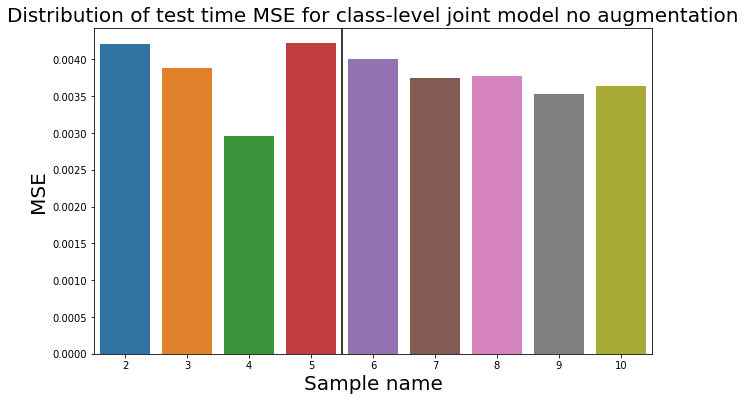

In [ ]:
######################################################################################
#### Figure 5A Joint model without data augmentation test-time MSE leave-one out 
######################################################################################
temp = [noaug1_mse_tracker['hmse'].append(k) for k in noaug1_mse_tracker['dmse']]
plt.subplots(figsize=(10,6))
p = sns.barplot(x = np.arange(2,11),y = noaug1_mse_tracker['hmse'])
p.set_xlabel("Sample name", fontsize=20)
p.set_ylabel("MSE", fontsize=20)
p.set_title("Distribution of test time MSE for class-level joint model no augmentation", fontsize=20)
p.axvline(x = 3.5, color = "black")
plt.show()

In [ ]:
# pd.DataFrame(noaug1_mse_tracker['hmse']).to_csv("/content/no_aug1_mse.csv")
# no_aug1_mse = pd.read_csv("/content/no_aug1_mse.csv")

##### Figure 6B. Joint model trained without data augmentation test-time MSE leave-two sample out

In [ ]:
######################################################################################
#### Train model without data augmentation leaving two samples out at atime 
######################################################################################
noaug2_model_list , noaug2_history_tracker , noaug2_hmodel_prediction , noaug2_dmodel_prediction , noaug2_hsample_p , noaug2_dsample_p, noaug2_mse_tracker  = model_noaug_leave2 (h_sample, d_sample, 
                                                                                                                                                                                  h_samplex, d_samplex, 
                                                                                                                                                                                  h_sampley, d_sampley, 
                                                                                                                                                                                  init_lr = 1e-4, epochs= 300)

Test on healhty sample: 2  disease sample:  6
Healthy sample prediction:  0
Healthy sample MSE:  [0.0031582858208297803]
Disease sample prediction:  1
Disease sample MSE:  [0.0030589766624167223]
Test on healhty sample: 2  disease sample:  7
Healthy sample prediction:  0
Healthy sample MSE:  [0.010071173195107565]
Disease sample prediction:  1
Disease sample MSE:  [0.008586484757664391]
Test on healhty sample: 2  disease sample:  8
Healthy sample prediction:  0
Healthy sample MSE:  [0.0035579675383940923]
Disease sample prediction:  1
Disease sample MSE:  [0.003360132659350325]
Test on healhty sample: 2  disease sample:  9
Healthy sample prediction:  0
Healthy sample MSE:  [0.0030557619538679887]
Disease sample prediction:  1
Disease sample MSE:  [0.0031912419362032855]
Test on healhty sample: 2  disease sample:  10
Healthy sample prediction:  0
Healthy sample MSE:  [0.003491048207482762]
Disease sample prediction:  1
Disease sample MSE:  [0.0035982432795998707]
Test on healhty sample:

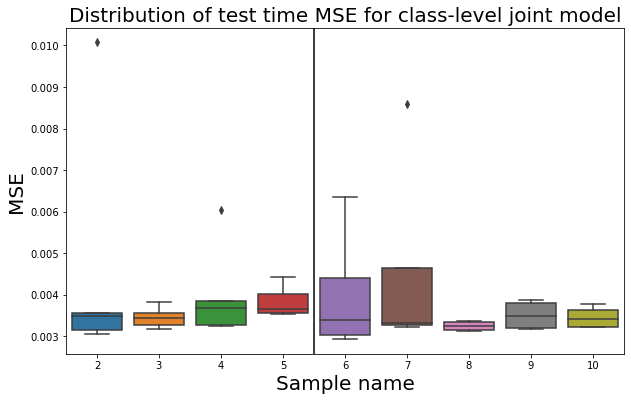

In [ ]:
no_aug_mse = plot_MSE(noaug2_mse_tracker)

In [ ]:
#no_aug_mse.to_csv('no_aug_mse.csv')

##### Figure 6C. Joint model trained with data augmentation test-time MSE leave-one sample out

In [ ]:
######################################################################################
#### Train model with data augmentation leaving one sample out at a time 
######################################################################################

aug1_model_list , aug1_history_tracker , aug1_hmodel_prediction , aug1_dmodel_prediction , aug1_hsample_p , aug1_dsample_p, aug1_mse_tracker  = model_run_leave1 (h_sample, d_sample, 
                                                                                                                                                                  h_samplex, d_samplex,
                                                                                                                                                                  h_sampley, d_sampley, 
                                                                                                                                                                  init_lr = 1e-4, epochs= 300)


Test on healhty sample: 2
Healthy sample prediction:  0
Healthy sample MSE:  [0.0016008430314365405]
Test on healhty sample: 3
Healthy sample prediction:  0
Healthy sample MSE:  [0.0018979607425351458]
Test on healhty sample: 4
Healthy sample prediction:  0
Healthy sample MSE:  [0.0020380760771472393]
Test on healhty sample: 5
Healthy sample prediction:  0
Healthy sample MSE:  [0.0020344171533386583]
Test on disease sample:  6
Disease sample prediction:  1
Disease sample MSE:  [0.001700800424212183]
Test on disease sample:  7
Disease sample prediction:  1
Disease sample MSE:  [0.0016850966996799924]
Test on disease sample:  8
Disease sample prediction:  1
Disease sample MSE:  [0.0017431611894199955]
Test on disease sample:  9
Disease sample prediction:  1
Disease sample MSE:  [0.0016762776805597603]
Test on disease sample:  10
Disease sample prediction:  1
Disease sample MSE:  [0.0015805733132379012]


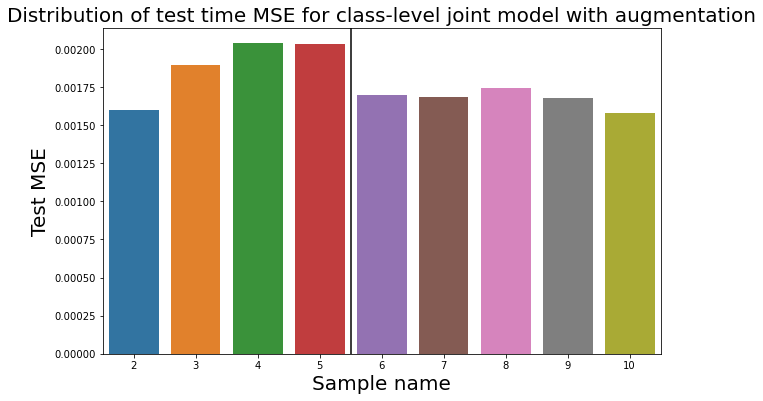

In [ ]:
temp = [aug1_mse_tracker['hmse'].append(k) for k in aug1_mse_tracker['dmse']]
plt.subplots(figsize=(10,6))
p = sns.barplot(x = np.arange(2,11),y = aug1_mse_tracker['hmse'])
p.set_xlabel("Sample name", fontsize=20)
p.set_ylabel("Test MSE", fontsize=20)
p.set_title("Distribution of test time MSE for class-level joint model with augmentation", fontsize=20)
p.axvline(x = 3.5, color = "black")
plt.show()

##### Figure 6D. Joint model trained with data augmentation test-time MSE leave-two samples out

In [ ]:
######################################################################################
#### Train model with data augmentation leaving two sample out at a time 
######################################################################################

aug2_mode_list , aug2_history_tracker , aug2_hmodel_prediction , aug2_dmodel_prediction , aug2_hsample_p , aug2_dsample_p, aug2_mse_tracker  = model_run_leave2 (h_sample, d_sample, 
                                                                                                                                                                 h_samplex, d_samplex,
                                                                                                                                                                 h_sampley, d_sampley, 
                                                                                                                                                                 init_lr = 1e-4, epochs= 300)



Test on healhty sample: 2  disease sample:  6
Healthy sample prediction:  0
Healthy sample MSE:  [0.001441623092816305]
Disease sample prediction:  1
Disease sample MSE:  [0.0017708154821505055]
Test on healhty sample: 2  disease sample:  7
Healthy sample prediction:  0
Healthy sample MSE:  [0.001486686108507749]
Disease sample prediction:  1
Disease sample MSE:  [0.001691184712159931]
Test on healhty sample: 2  disease sample:  8
Healthy sample prediction:  0
Healthy sample MSE:  [0.0015480986860664126]
Disease sample prediction:  1
Disease sample MSE:  [0.0017230471855804175]
Test on healhty sample: 2  disease sample:  9
Healthy sample prediction:  0
Healthy sample MSE:  [0.0014283157501925917]
Disease sample prediction:  1
Disease sample MSE:  [0.0016497812181900556]
Test on healhty sample: 2  disease sample:  10
Healthy sample prediction:  0
Healthy sample MSE:  [0.0014850188418523381]
Disease sample prediction:  1
Disease sample MSE:  [0.0016921876408544925]
Test on healhty sample

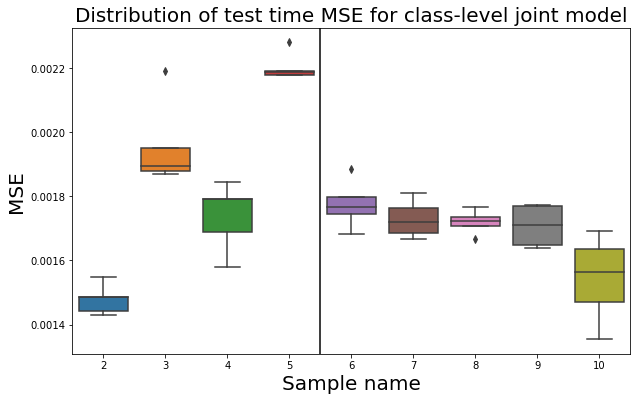

In [ ]:
aug_mse = plot_MSE(aug2_mse_tracker)
aug_mse.to_csv("aug_mse.csv")

##### Figure 6E. Comparisons of leave-one-out model performance in augmented vs unaugmented model training

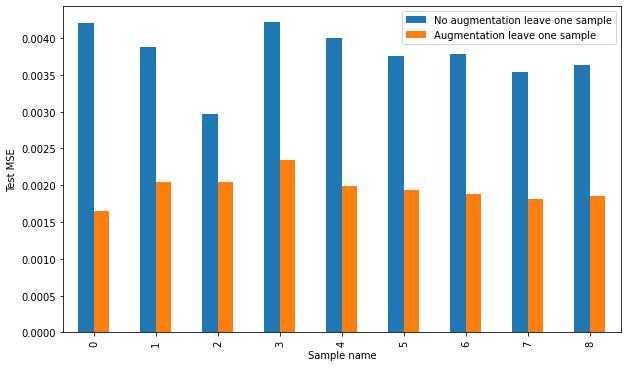

In [ ]:
# p = pd.DataFrame({ "Augmented leave one sample":noaug1_mse_tracker['hmse'],"No augmentation leave one sample":aug1_mse_tracker['hmse']}).plot.bar(figsize=(10,6), 
#                                                                                                                                                   xlabel ="Sample name",
#                                                                                                                                                   ylabel ="Test MSE")

p = pd.DataFrame({ "No augmentation leave one sample":no_aug1_mse.iloc[:,1],"Augmentation leave one sample":aug1_mse_tracker['hmse']}).plot.bar(figsize=(10,6), 
                                                                                                                                                  xlabel ="Sample name",
                                                                                                                                                  ylabel ="Test MSE")

plt.show()

##### Figure 6F. Comparisons of leave-two-out model performance in augmented vs unaugmented model training

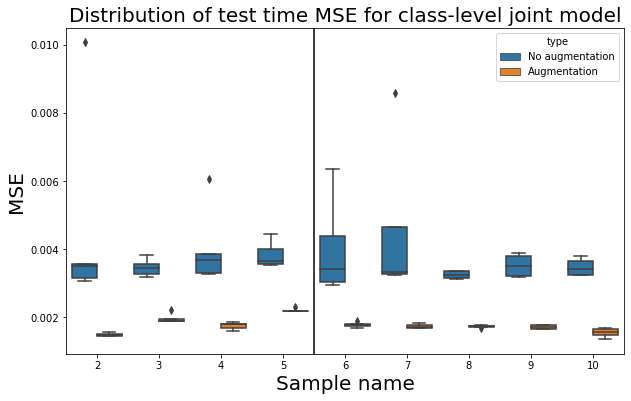

In [ ]:
no_aug_mse = no_aug_mse.copy()
aug_mse = aug_mse.copy()

no_aug_mse['type']="No augmentation"
aug_mse['type']="Augmentation"

gather = pd.concat([no_aug_mse, aug_mse], axis=0)

plt.subplots(figsize=(10,6))
p = sns.boxplot(y= 'mse', x='label' ,data=gather, hue ="type")
p.set_xlabel("Sample name", fontsize=20)
p.set_ylabel("MSE", fontsize=20)
p.set_title("Distribution of test time MSE for class-level joint model", fontsize=20)
p.axvline(x = 3.5, color = "black")
plt.show()

#### Figure 6G. Model accuracy for class prediction 

Here we chose to plot the leave-one-out model predicting on sample 5. All of the model accuracies for sample origin classifications follow the same trend of acheiving 100% accuracy within the first 10 eopchs. This may be caused by the distinct pattern between healthy and disease group relative abundance where a lot of classes in disease groups got shrunk to close to 0. This indicates that our model may be overfitting on the limited samples we have and may be more generalizable if we can see more variable samples. 

In [ ]:
def plot_model_history(model_history):
    
    plt.plot(model_history.history['patient_output_accuracy'], label="Training accuracy")
    plt.plot(model_history.history['val_patient_output_accuracy'], label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("MSE loss")
    plt.title("Sample classification accuracy")
    plt.legend()
    plt.show()

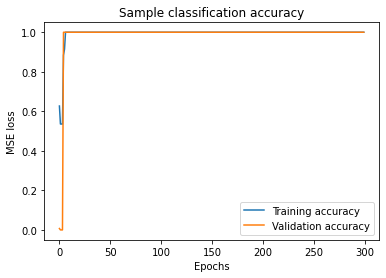

In [ ]:
plot_model_history(aug2_history_tracker[4])

#### Figure 6H. Prediction of the best performing models chosen by the lowest test MSE 

In the first panel, we showed the prediction as well as residuals across time points by the leave-one-out model predicting on sample 2. In the second panel, we showed the prediction as well as residuals across time points by the leave-one-out model predicting on sample 10. All of the classes have robust predictions and residuals ranging between -0.25 and 0.25. We oberse that predictions are less accurate at timepoints representing a transition between treatment conditions. This is because we permutated treatment intervals as one of our data augmentation methods, therefore, the prediction at these points is less reliable.

In [ ]:
###############################################################
#### Plot prediction and residual by class helper function 
###############################################################

def plot_prediction(re_pred, re_truth, save=None):
    '''
    save= file name; if not save leave it none
    '''
    fig, ax = plt.subplots(4,3 , figsize =(30,20))
    fig.delaxes(ax[3,2])
    for i , axs in enumerate(ax.ravel()):

        if i < re_pred.shape[1]:

            name = re_pred.columns[i]
            axs.plot(re_truth.iloc[:,i], label = name +" Ground truth", color = "red")
            axs.plot(re_pred.iloc[:,i], label = name +" Prediction", color="blue")
            axs.set_title(name)
            axs.set_ylim((0,1))

            axs.axvspan(min((np.where(new_time>=21.5))[0]), 
                      min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label='High Fat')
            axs.axvspan(min((np.where(new_time>=35.5))[0]), 
                      min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label='Vancomycin')
            axs.axvspan(min((np.where(new_time>=50.5))[0]), 
                      min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label='Gentamicin')

            axs.set_xticks(range(0,len(re_pred.index)))
            axs.set_xticklabels(list(re_pred.index),rotation=90, fontsize = 7 )
            axs.legend()
    plt.show()    
    
    if save != None:
        fig.savefig(save+".png")

def plot_resid(re_pred, re_truth, save=None):

    axes = re_truth.subtract(re_pred).plot.line(rot=90, subplots=False, figsize=(17,6), ylim=(-1,1))
    axes.set_xticks(range(0,len(re_truth.index)))
    axes.set_xticklabels( list(re_truth.index))

    axes.axvspan(min((np.where(new_time>=21.5))[0]), 
                      min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label='High Fat')

    axes.axvspan(min((np.where(new_time>=35.5))[0]), 
                      min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label='Vancomycin')

    axes.axvspan(min((np.where(new_time>=50.5))[0]), 
                      min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label='Gentamicin')
    axes.set_xlabel("Time", fontsize=20)
    axes.set_ylabel("Residual", fontsize=20)
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.show()
    
    if save !=None:
        axes.get_figure().savefig(save+".png")


###### Healthy sample relative abundance prediction 

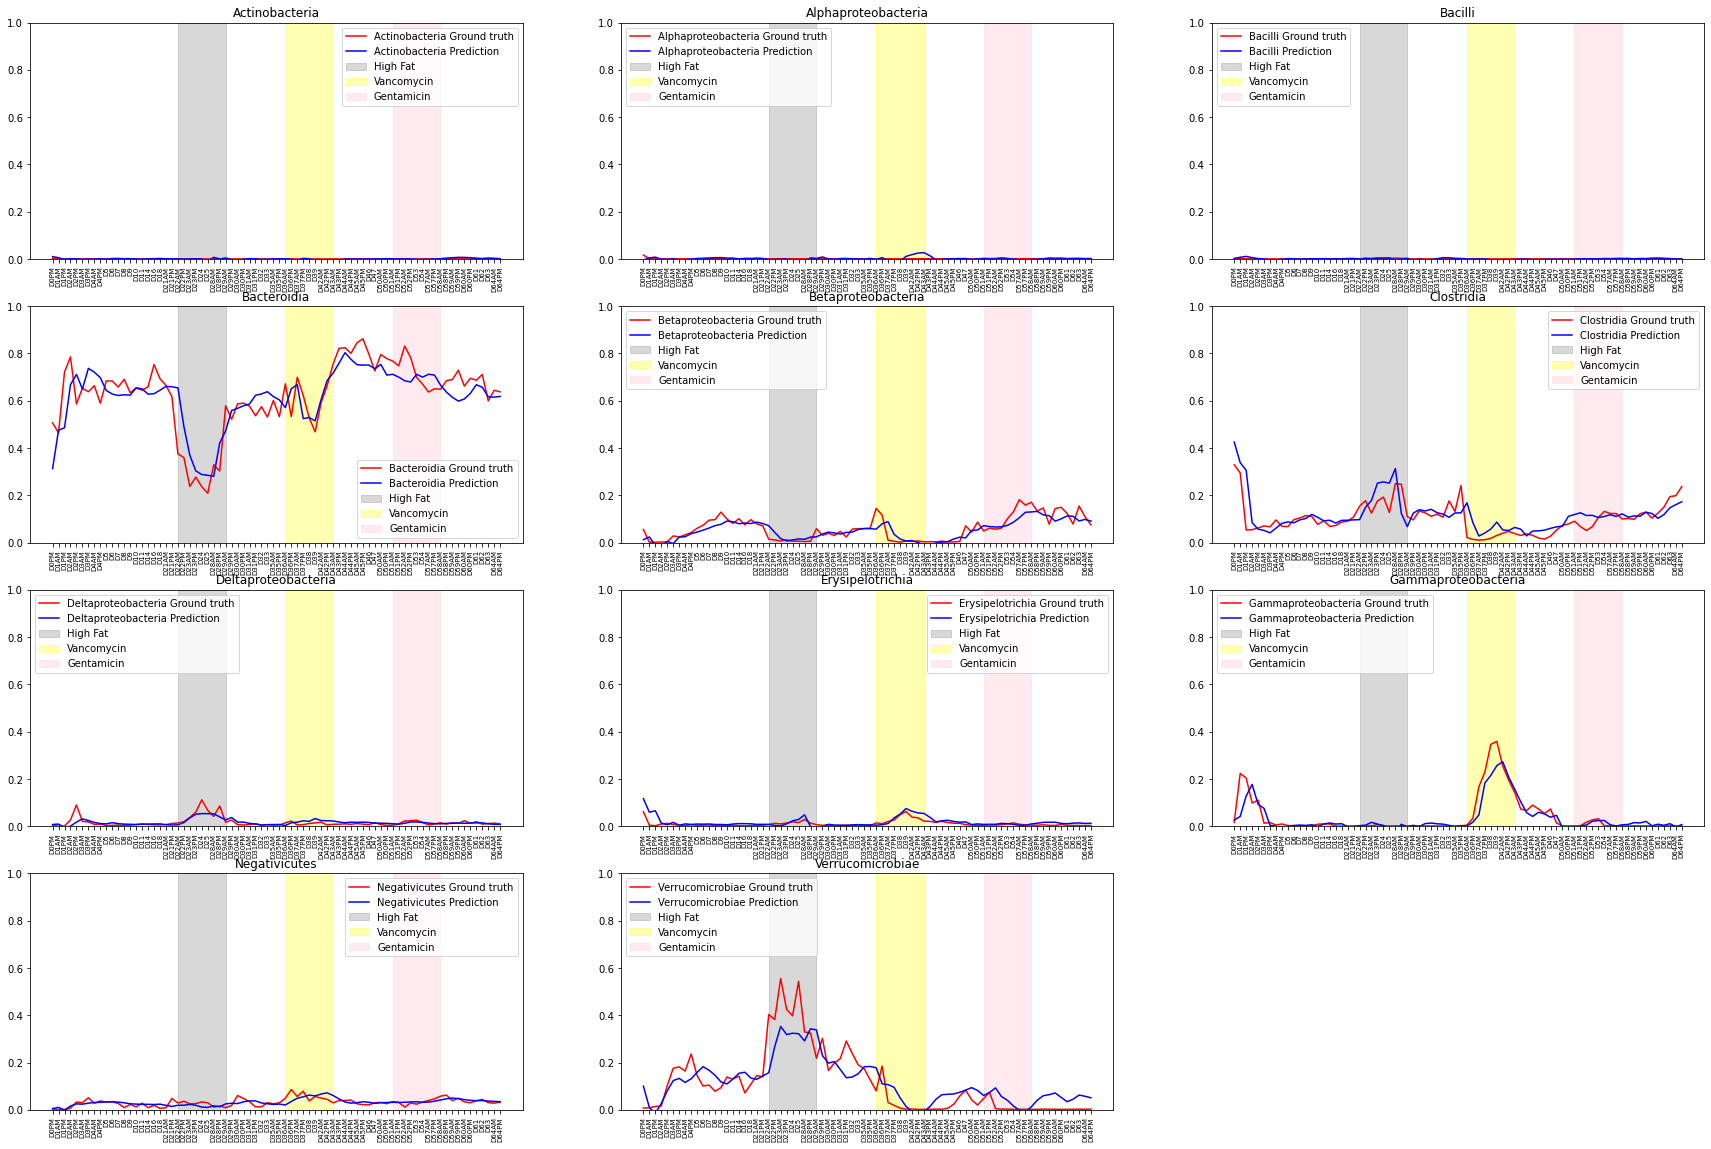

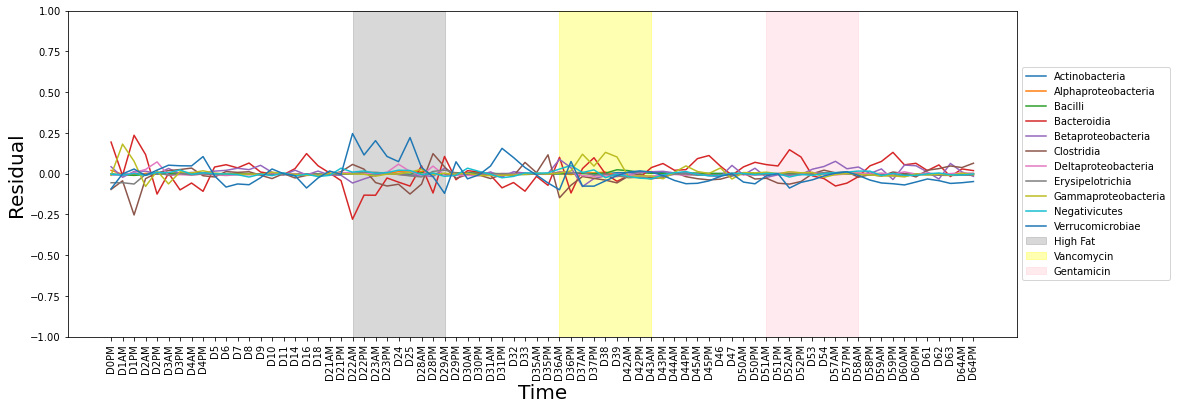

In [ ]:
dpred =  pd.DataFrame(np.reshape(aug1_hmodel_prediction[0],(76, sample2_x.shape[2])), 
                      columns = sample2.columns, index= sample2.index[1:])
dtrue = pd.DataFrame(np.reshape(sample2_y,(76,sample10_x.shape[2])), 
                     columns = sample2.columns, index= sample2.index[1:])
plot_prediction(dpred, dtrue, save="best_healthy_pred")
plot_resid(dpred, dtrue, save="best_healthy_resid")

###### Disease sample relative abundance prediction 

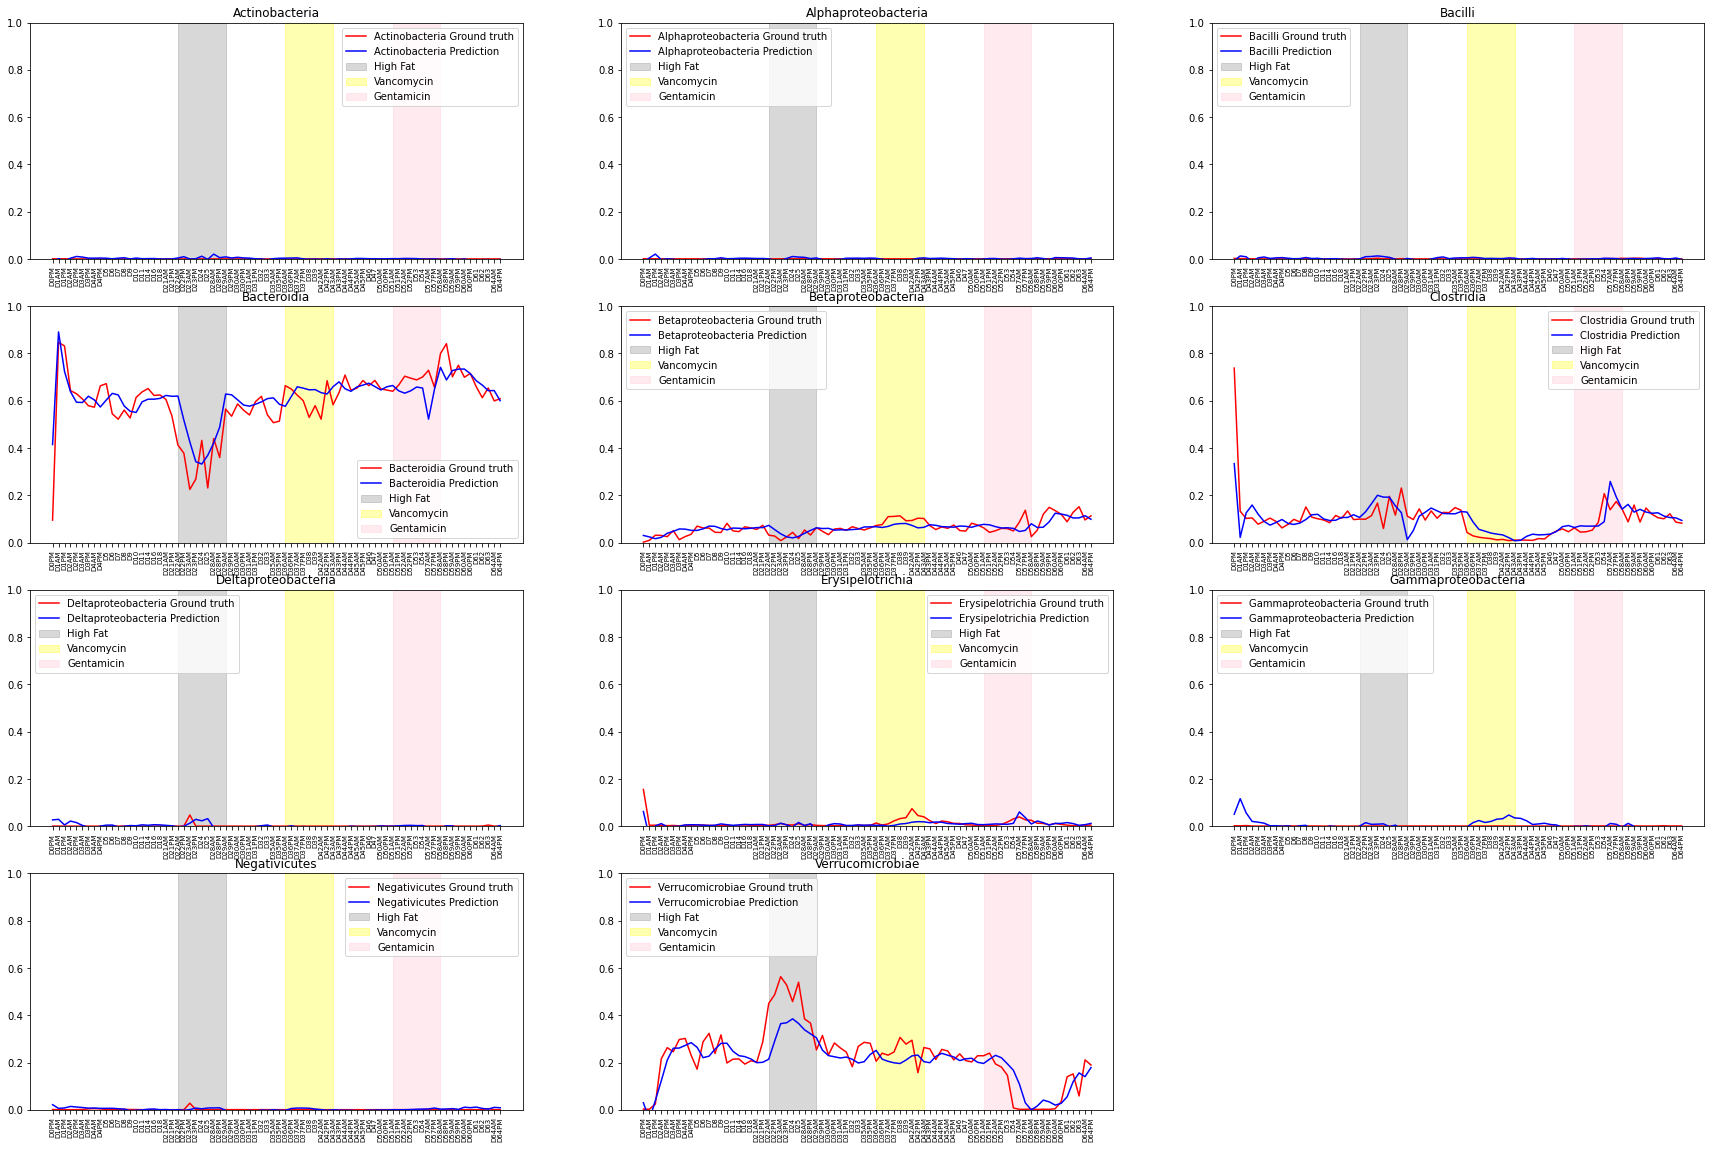

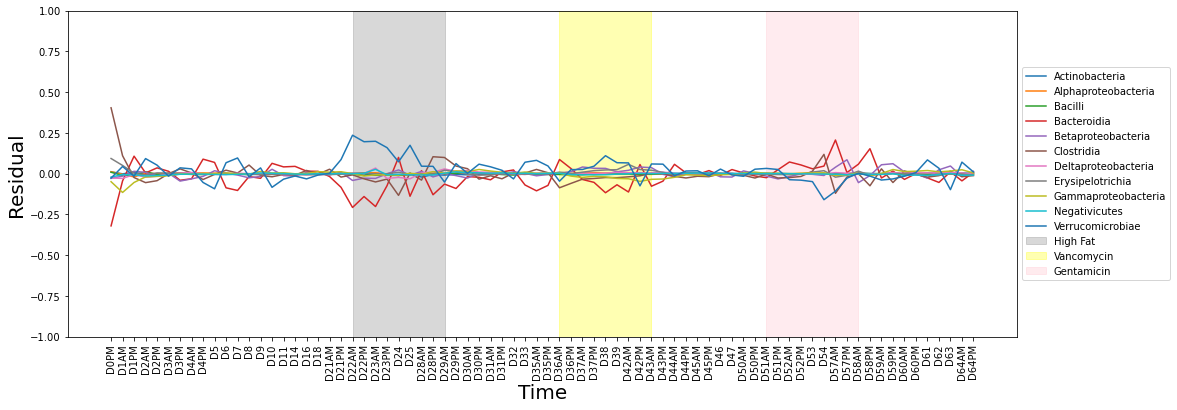

In [ ]:
dpred =  pd.DataFrame(np.reshape(aug1_dmodel_prediction[4],(76, sample2_x.shape[2])), 
                      columns = sample2.columns, index= sample2.index[1:])
dtrue = pd.DataFrame(np.reshape(sample10_y,(76,sample10_x.shape[2])), 
                     columns = sample2.columns, index= sample2.index[1:])
plot_prediction(dpred, dtrue, save="best_disease_pred")
plot_resid(dpred, dtrue, save="best_healthy_resid")

### Section II - Multi-head prediction of absolute abundance through time  

In this section, we explored a different aspect of the time series data. Instead of modeling relative abundance at specifc time points, we aimed to model the absolute abundance in concentration (CFU/g) through time. Similar data augmentation methods in section I are applied except for order permutation. The reason is that time dependency is lost during permuation, on which absolute abundance has a strong reliance.

This model takes in the log-transformed absolute abundance matrix from $t_{0}$ to $t_{n-1}$ time points across the chose top eleven most abundant classes for each sample. This model also generates two predictions: the log-transformed absolute abundance of the next time point $t_{1}$ to $t_{n}$ and the binary outcome of whether the sample is from the healthy or ulcerative colitis donor type.

We used the time series output only from the model to find the best set of hyperparameters (learning rate, training epochs and last-layer activation). We ended up choosing a learning rate of 1e-2, a linear activation function for the last dense layer before the output layer, and 300 epochs to model abusolute abundance. 

We next used the same metrics to evaluate our model performance with leave out one sample and leave out two samples for uncertainty measures.

In [ ]:
################################################
#######Absolute abundance
################################################

time_sum = np.sum(counts.iloc[:,1:], axis=0)

fill_count = norm_count_matrix

# replace column zeros with 1/column sum
for i, col in enumerate(fill_count.columns):
  fill_count.loc[:,col].replace(0., 1/time_sum[i], inplace=True)

##Group by Class level
count_taxo = pd.concat([fill_count, asv_and_taxonomy.loc[np.where(norm_matrix['total_counts']!=0)[0],:] ], axis=1)
count_class = count_taxo.groupby('Class').sum()

##Times geometric mean of gPCR at each time point for absolute abundance 
absolu_abund = count_class.mul(qpcr['gmean'].values, axis=1)

################################################################
#######Imputation for the healthy donor group absolute abundance
################################################################

# impute for time 3 and 4
absolu_abund = absolu_abund.copy()
absolu_abund['3-D37PM'] = np.mean(absolu_abund[['2-D37PM', '4-D37PM', '5-D37PM']], axis=1)
absolu_abund['3-D28PM'] = np.mean(absolu_abund[['2-D28PM', '5-D28PM']], axis=1)
absolu_abund['4-D28PM'] = np.mean(absolu_abund[['2-D28PM', '5-D28PM']], axis=1)

################################################################
#######Imputation for the disease donor group absolute abundance
################################################################

absolu_abund = absolu_abund.copy()
absolu_abund['7-D57PM'] = np.mean(absolu_abund[['6-D57PM', '8-D57PM', '9-D57PM', '10-D57PM']], axis=1)
absolu_abund['10-D0PM'] = np.mean(absolu_abund[['6-D0PM', '7-D0PM', '8-D0PM', '9-D0PM']], axis=1)
absolu_abund['10-D28AM'] = np.mean(absolu_abund[['6-D28AM', '7-D28AM', '8-D28AM', '9-D28AM']], axis=1)
absolu_abund['10-D28PM'] = np.mean(absolu_abund[['6-D28PM', '7-D28PM', '8-D28PM', '9-D28PM']], axis=1)

# log transform and remove -inf
absolu_abund_log = absolu_abund.apply(np.log)

################################################################
#######Imputation for meta data index 
################################################################

# left join metatdata to get the sample ID
qpcr_metadata_o = qpcr.merge(metadata, how='left', on='sampleID')

# first calc the geometric mean  for each sampleID
qpcr_metadata_o['average'] = gmean(qpcr.iloc[:, 1:3], axis=1)
qpcr_metadata = qpcr_metadata_o.drop(columns=['measurement1', 'measurement2', 'measurement3'])
qpcr_metadata.set_index('sampleID', inplace=True)
qpcr_metadata.head()

# calculate average values for sample 3 and 4
time_3_375 = pd.DataFrame({'subject': 3, 'time': 37.5, 'average': 
                           np.mean(qpcr_metadata.loc[['2-D37PM', '4-D37PM', '5-D37PM'], 'average'])
                           }, index=['3-D37PM'])
time_3_285 = pd.DataFrame({'subject': 3, 'time': 28.5, 'average': 
                           np.mean(qpcr_metadata.loc[['2-D28PM', '5-D28PM'], 'average'])
                           }, index=['3-D28PM'])
time_4_285 = pd.DataFrame({'subject': 4, 'time': 28.5, 'average': 
                           np.mean(qpcr_metadata.loc[['2-D28PM', '5-D28PM'], 'average'])
                           }, index=['4-D28PM'])

qpcr_metadata = qpcr_metadata.append(time_3_375).append(time_3_285).append(time_4_285)

# calculate averages for sample 7 and 10
time_7_575 = pd.DataFrame({'subject': 7, 'time': 57.5, 'average': 
                           np.mean(qpcr_metadata.loc[['6-D57PM', '8-D57PM', '9-D57PM', '10-D57PM'], 'average'])
                           }, index=['7-D57PM'])
time_10_05 = pd.DataFrame({'subject': 10, 'time': 0.5, 'average': 
                           np.mean(qpcr_metadata.loc[['6-D0PM', '7-D0PM', '8-D0PM', '9-D0PM'], 'average'])
                           }, index=['10-D0PM'])
time_10_28 = pd.DataFrame({'subject': 10, 'time': 28, 'average': 
                           np.mean(qpcr_metadata.loc[['6-D28AM', '7-D28AM', '8-D28AM', '9-D28AM'], 'average'])
                           }, index=['10-D28AM'])
time_10_285 = pd.DataFrame({'subject': 10, 'time': 28.5, 'average': 
                           np.mean(qpcr_metadata.loc[['6-D28PM', '7-D28PM', '8-D28PM', '9-D28PM'], 'average'])
                           }, index=['10-D28PM'])
qpcr_metadata = qpcr_metadata.append(time_7_575).append(time_10_05).append(time_10_28).append(time_10_285)

qpcr_metadata = qpcr_metadata.reset_index()
qpcr_metadata.rename(columns={'index':'sampleID'}, inplace=True)
qpcr_metadata['log_avg'] = np.log(qpcr_metadata.average)

#### Standardization and absolute abundance processing functions

In [ ]:
def absolute_abudance(subset_class, time_id, sample_number ,lookback=1):
    '''

    subset_class: level at which taxon is included 
    time_id : time index from the original matrix 
    sample_number: int, indicates sample number 

    '''
    ##Subset each sample from total absolute abundance matrix
    sample = absolu_abund_log[absolu_abund_log.index.isin(subset_class)].iloc[:,time_id.index].T

    ##change sample index name to rid of sample number
    sample.index = [i.replace( str(sample_number) +"-","") for i in list(sample.index)]

    ##Trim last time step for X
    datax = sample.iloc[:-1,:]
    
    ##Trim first time step for Y
    datay = sample.iloc[1:,:]
    
    samplex = np.reshape( np.asarray(datax), (1,datax.shape[0],  datax.shape[1]) )
    sampley = np.reshape( np.asarray(datay), (1,datay.shape[0],  datay.shape[1]) )
     
    return  sample,samplex ,sampley

def standardize_data(train_X, train_y, test_X, test_y, scaler):
  
  length = train_X.shape[2]

  #Transform shape
  train_X = np.reshape(train_X, (-1,train_X.shape[2] ))
  train_y = np.reshape(train_y, (-1,train_y.shape[2] ))

  test_X = np.reshape(test_X, (-1,test_X.shape[2] ))
  test_y = np.reshape(test_y, (-1,test_y.shape[2] ))

  # concatenate train and test
  train_data = np.concatenate([train_X, train_y], axis=1)
  test_data = np.concatenate([test_X, test_y], axis=1)

  # scaler the data
  train_data = scaler.fit_transform(train_data)
  test_data = scaler.transform(test_data)

  # obtain X and y
  train_X, train_y = train_data[:,:-length], train_data[:,-length:]
  test_X, test_y = test_data[:,:-length], test_data[:,-length:]

  # reshape dims and GRU expects input to be [samples, time steps, features]
  train_X = train_X.reshape(-1, 76, 11)
  train_y = train_y.reshape(-1, 76, 11)
  test_X = test_X.reshape(-1, 76, 11)
  test_y = test_y.reshape(-1, 76, 11)

  return train_X, train_y, test_X, test_y

#### Training functions for non-augmented absolute abundance prediction

In [ ]:
#############################################################
#### Model training function leaving one sample out at a time 
#############################################################

def model_noaug_leave1_std (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]

    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}

    for i in range(9):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]
        
        if i < 4:
            healthy_out = h_index[i]
            htest_x = h_samplex[h_index[i]]
            htest_y = h_sampley[h_index[i]]
            print("Test on healhty sample:", healthy_out+2)
            
            htemp_index = np.delete(h_index, healthy_out)
            
            ##Create a list of data frames without the left out sample
            hsample_list = [h_sample[k] for k in htemp_index]
            
            ##No augmentation data processing
            hx_noaug = np.concatenate([h_samplex[k] for k in htemp_index])
            hy_noaug = np.concatenate([h_sampley[k] for k in htemp_index])

            dx_noaug = np.concatenate([d_samplex[k] for k in d_index])
            dy_noaug = np.concatenate([d_sampley[k] for k in d_index])
          
        else:
            disease_out = d_index[i-4]
            dtest_x = d_samplex[d_index[i-4]]
            dtest_y = d_sampley[d_index[i-4]]
            
            print( "Test on disease sample: ", disease_out+6)
            
            dtemp_index = np.delete(d_index, disease_out)
            ##same process applied to disease samples 
            dsample_list = [d_sample[k] for k in dtemp_index]
            
            ##No augmentation data processing
            hx_noaug = np.concatenate([h_samplex[k] for k in h_index])
            hy_noaug = np.concatenate([h_sampley[k] for k in h_index])

            dx_noaug = np.concatenate([d_samplex[k] for k in dtemp_index])
            dy_noaug = np.concatenate([d_sampley[k] for k in dtemp_index])
        
        
        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, hx_noaug.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, dx_noaug.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (hx_noaug, dx_noaug), axis=0)
        time_y = np.concatenate( (hy_noaug, dy_noaug), axis=0)

        ########################
        ########Standardize
        ########################

        scaler = MinMaxScaler(feature_range=(0,1))

        if i < 4: 
          time_x, time_y, htest_x, htest_y = standardize_data(time_x, time_y, htest_x, htest_y, scaler)
        else: 
          time_x, time_y, dtest_x, dtest_y= standardize_data(time_x, time_y, dtest_x, dtest_y, scaler)

        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)
        if i <4:
            hprediction, hsample_pred = model.predict(htest_x)
            hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

            hsample_p.append(hsample_pred)
            hmodel_prediction.append(hprediction)
            print("Healthy sample prediction: ",np.argmax(hsample_pred))
            print("Healthy sample MSE: ",hsample_mse)
            mse_tracker['hmse'].append(np.mean(hsample_mse))
        else: 
            dprediction, dsample_pred = model.predict(dtest_x)
            dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]

            dsample_p.append(dsample_pred)
            dmodel_prediction.append(dprediction)
            print("Disease sample prediction: ",np.argmax(dsample_pred))
            print("Disease sample MSE: ",dsample_mse)
            mse_tracker['dmse'].append(np.mean(dsample_mse))
        
        #mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )

        model_list.append(model)
        history_tracker.append(history)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker

In [ ]:
#######################################################################################
#### Model training function without data augmentation leaving one sample out at a time 
#######################################################################################

def model_noaug_leave2_std (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    ##All 20 combinations 
    index_list = list(it.product([0,1,2,3], [0,1,2,3,4]))

    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]

    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}


    for i in range(len(index_list)):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]

        ##Select sample being left out
        healthy_out = index_list[i][0]
        disease_out = index_list[i][1]

        htest_x = h_samplex[index_list[i][0]]
        htest_y = h_sampley[index_list[i][0]]

        dtest_x = d_samplex[index_list[i][1]]
        dtest_y = d_sampley[index_list[i][1]]

        print("Test on healhty sample:", healthy_out+2, " disease sample: ", disease_out+6)

        ##Take out the omitted sample
        htemp_index = np.delete(h_index, healthy_out)
        dtemp_index = np.delete(d_index, disease_out)

        ##Create a list of data frames without the left out sample
        hsample_list = [h_sample[k] for k in htemp_index]
        
        ##No augmentation data processing
        hx_noaug = np.concatenate([h_samplex[k] for k in htemp_index])
        hy_noaug = np.concatenate([h_sampley[k] for k in htemp_index])
        
        dx_noaug = np.concatenate([d_samplex[k] for k in dtemp_index])
        dy_noaug = np.concatenate([d_sampley[k] for k in dtemp_index])
        
        
        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, hx_noaug.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, dx_noaug.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (hx_noaug, dx_noaug), axis=0)
        time_y = np.concatenate( (hy_noaug, dx_noaug), axis=0)

        ########################
        #######Standardize
        ########################

        scaler = MinMaxScaler(feature_range=(0,1))

        unstd_X = time_x
        unstd_Y = time_y

        time_x, time_y, htest_x, htest_y = standardize_data(time_x, time_y, htest_x, htest_y, scaler)
        time_x, time_y, dtest_x, dtest_y = standardize_data(unstd_X, unstd_Y, dtest_x, dtest_y, scaler)

        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)

        hprediction, hsample_pred = model.predict(htest_x)
        hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

        hsample_p.append(hsample_pred)
        hmodel_prediction.append(hprediction)
        print("Healthy sample prediction: ",np.argmax(hsample_pred))
        print("Healthy sample MSE: ",hsample_mse)

        dprediction, dsample_pred = model.predict(dtest_x)
        dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]

        dsample_p.append(dsample_pred)
        dmodel_prediction.append(dprediction)
        print("Disease sample prediction: ",np.argmax(dsample_pred))
        print("Disease sample MSE: ",dsample_mse)

        mse_tracker['hmse'].append(np.mean(hsample_mse))
        mse_tracker['dmse'].append(np.mean(dsample_mse))
        mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )


        model_list.append(model)
        history_tracker.append(history)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker 

#### Training functions for augmented absolute abundance prediction 

In [ ]:
######################################################################################
#### Model training function with data augmentation leaving one sample out at a time 
######################################################################################

def model_run_leave1_std (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]
    
    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}
    
    scaler_tracker=[]
    h_scaley = []
    d_scaley = []

    for i in range(9):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]
        
        if i < 4:
            healthy_out = h_index[i]
            htest_x = h_samplex[h_index[i]]
            htest_y = h_sampley[h_index[i]]
            print("Test on healhty sample:", healthy_out+2)
            
            htemp_index = np.delete(h_index, healthy_out)
            
            ##Create a list of data frames without the left out sample
            hsample_list = [h_sample[k] for k in htemp_index]

            ##Start data processing with adding augmentated data 
            healthy_X, healthy_Y = data_process(htemp_index ,h_sample, h_samplex, h_sampley)
            
            dsample_list = [d_sample[k] for k in d_index]
            disease_X, disease_Y = data_process(d_index, d_sample, d_samplex, d_sampley)
            
            #print(healthy_X.shape)

        else:
            disease_out = d_index[i-4]
            dtest_x = d_samplex[d_index[i-4]]
            dtest_y = d_sampley[d_index[i-4]]
            
            print( "Test on disease sample: ", disease_out+6)
            
            dtemp_index = np.delete(d_index, disease_out)
            ##same process applied to disease samples 
            dsample_list = [d_sample[k] for k in dtemp_index]

            disease_X, disease_Y = data_process(dtemp_index, d_sample, d_samplex, d_sampley)
           
            
            hsample_list = [h_sample[k] for k in h_index]
            ##Start data processing with adding augmentated data 
            healthy_X, healthy_Y = data_process(h_index ,h_sample, h_samplex, h_sampley)
            
            
        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, healthy_X.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, disease_X.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (healthy_X, disease_X), axis=0)
        time_y = np.concatenate( (healthy_Y, disease_Y), axis=0)

        ########################
        ########Standardize
        ########################

        scaler = MinMaxScaler(feature_range=(0,1))

        if i < 4: 
            time_x, time_y, htest_x, htest_y = standardize_data(time_x, time_y, htest_x, htest_y, scaler)
            h_scaley.append(htest_y)
        else: 
            time_x, time_y, dtest_x, dtest_y= standardize_data(time_x, time_y, dtest_x, dtest_y, scaler)
            d_scaley.append(dtest_y)
        

        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)
        if i <4:
            hprediction, hsample_pred = model.predict(htest_x)
            hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

            hsample_p.append(hsample_pred)
            hmodel_prediction.append(hprediction)
            
            print("Healthy sample prediction: ",np.argmax(hsample_pred))
            print("Healthy sample MSE: ",hsample_mse)
            mse_tracker['hmse'].append(np.mean(hsample_mse))
        else: 
            dprediction, dsample_pred = model.predict(dtest_x)
            dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]
            
            #dscale_back = scaler.inverse_transform(np.concatenate([test_X.reshape(-1,11), time_pred.reshape(-1,11)], axis=1))[:,-11:]
 
            
            
            dsample_p.append(dsample_pred)
            dmodel_prediction.append(dprediction)
            print("Disease sample prediction: ",np.argmax(dsample_pred))
            print("Disease sample MSE: ",dsample_mse)
            mse_tracker['dmse'].append(np.mean(dsample_mse))
        
        #mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )

        model_list.append(model)
        history_tracker.append(history)
        
        scaler_tracker.append(scaler)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker, scaler_tracker, h_scaley, d_scaley 

In [ ]:
######################################################################################
#### Model training function with data augmentation leaving two samples out at a time 
######################################################################################

def model_run_leave2_std (h_sample, d_sample, 
               h_samplex, d_samplex, 
               h_sampley, d_sampley, 
               init_lr = 1e-4, epochs= 300):
    
    ##All 20 combinations 
    index_list = list(it.product([0,1,2,3], [0,1,2,3,4]))

    sequence_order_start = np.reshape(np.array([0,1,2,3]), (1,4))
    sequence_order = np.repeat(sequence_order_start, 12, axis=0)

    model_list = []
    history_tracker = []

    hmodel_prediction = []
    dmodel_prediction = []

    hsample_p = []
    dsample_p =[]
    
    scaler_tracker =[]

    mse_tracker = { 'hmse':[], 'dmse':[], 'mean_mse':[]}


    for i in range(len(index_list)):

        ##Sample index 
        h_index = [0,1,2,3]
        d_index = [0,1,2,3,4]

        ##Select sample being left out
        healthy_out = index_list[i][0]
        disease_out = index_list[i][1]

        htest_x = h_samplex[index_list[i][0]]
        htest_y = h_sampley[index_list[i][0]]

        dtest_x = d_samplex[index_list[i][1]]
        dtest_y = d_sampley[index_list[i][1]]

        print("Test on healhty sample:", healthy_out+2, " disease sample: ", disease_out+6)

        ##Take out the omitted sample
        htemp_index = np.delete(h_index, healthy_out)
        dtemp_index = np.delete(d_index, disease_out)

        ##Create a list of data frames without the left out sample
        hsample_list = [h_sample[k] for k in htemp_index]

        ##Start data processing with adding augmentated data 
        healthy_X, healthy_Y = data_process(htemp_index ,h_sample, h_samplex, h_sampley)
        
        ##same process applied to disease samples 
        dsample_list = [d_sample[k] for k in dtemp_index]

        disease_X, disease_Y = data_process(dtemp_index, d_sample, d_samplex, d_sampley)
        
        ##Create categorical response variable
        patient_y = np.reshape(np.array([1,0]),(1,2))
        patient_y = np.repeat(patient_y, healthy_X.shape[0] ,axis=0)

        dpatient_y = np.reshape(np.array([0,1]),(1,2))
        dpatient_y = np.repeat(dpatient_y, disease_X.shape[0] ,axis=0)

        patient_y = np.concatenate( (patient_y, dpatient_y), axis=0)

        ##Create time series continuous variable
        time_x = np.concatenate( (healthy_X, disease_X), axis=0)
        time_y = np.concatenate( (healthy_Y, disease_Y), axis=0)

        ########################
        #######Standardize
        ########################

        scaler = MinMaxScaler(feature_range=(0,1))

        unstd_X = time_x
        unstd_Y = time_y

        time_x, time_y, htest_x, htest_y = standardize_data(time_x, time_y, htest_x, htest_y, scaler)
        time_x, time_y, dtest_x, dtest_y = standardize_data(unstd_X, unstd_Y, dtest_x, dtest_y, scaler)
  
        model = MultiOutputModel().assemble_full_model(time_x)
        #model.summary()
           
        ###User define     
        init_lr = init_lr
        epochs = epochs

        opt = tf.keras.optimizers.Adam(learning_rate=init_lr, 
                                       decay=init_lr / epochs)

        model.compile(optimizer=opt, 
                      loss={'time_ouput': 'mse', 'patient_output': 'binary_crossentropy'},
                      loss_weights={'time_ouput': 1 , 'patient_output': 1},
                      metrics={'time_ouput': ['mae','mse'], 'patient_output': 'accuracy'})

        history = model.fit(time_x, [time_y, patient_y],
                            verbose=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_split=0.2, shuffle=True)

        hprediction, hsample_pred = model.predict(htest_x)
        hsample_mse = [mean_squared_error(htest_y[i,:,:], hprediction[i,:,:]) for i in range(htest_y.shape[0])]

        hsample_p.append(hsample_pred)
        hmodel_prediction.append(hprediction)
        print("Healthy sample prediction: ",np.argmax(hsample_pred))
        print("Healthy sample MSE: ",hsample_mse)

        dprediction, dsample_pred = model.predict(dtest_x)
        dsample_mse = [mean_squared_error(dtest_y[i,:,:], dprediction[i,:,:]) for i in range(dtest_y.shape[0])]

        dsample_p.append(dsample_pred)
        dmodel_prediction.append(dprediction)
        print("Disease sample prediction: ",np.argmax(dsample_pred))
        print("Disease sample MSE: ",dsample_mse)

        mse_tracker['hmse'].append(np.mean(hsample_mse))
        mse_tracker['dmse'].append(np.mean(dsample_mse))
        mse_tracker['mean_mse'].append(np.mean( [np.mean(hsample_mse) , np.mean(dsample_mse) ]) )

        model_list.append(model)
        history_tracker.append(history)
        
        scaler_tracker.append(scaler)
        
    return  model_list , history_tracker , hmodel_prediction , dmodel_prediction , hsample_p , dsample_p, mse_tracker, scaler_tracker 

#### Figure 7 Model training and comparisons for absolute abundance prediction 

This section shows the performance of our multi-head model in predicting donor type of origin and absolute abundance through time. Our model had a perfect accuracy in predicting sample origin. Absolute abundance prediction loss is dramatically decreased by data augmentation.

1. Figure 7A. Performance of model trained on non-augmented data evaluated as test MSE, leaving out one sample at a time.

Similar to figure 6A, ulcerative colitis samples have a uniform distribution in MSE compared to healthy samples. We obtain high accuracy that is sample-agnostic. The average MSE on test data is around 0.0082.


2. Figure 7B.Performance of model trained on non-augmented data evaluated as test MSE, leaving out two samples at a time. 


Leave-out-two analysis gives a distribution of MSE values and shows the robustness of our model on predicting that particular sample. Surprisingly, disease samples have an overall larger MSE than healthy samples, which is the opposite in figure 6B. This may be because in the relative abundance prediction, disease samples have less diversity than healthy samples, resulting a lot of near zero percentages. Such reduction in values allowed the relative abundance model to perform better than the absolute abundance prediction for disease samples. This might suggest that relative abundance is maintained and is less volatile when perturbed by some significant changes in absolute abundance. Another note is that sample 8 in the disease group has the highest MSE, indicating our model has less predictive power for sample 8.


3. Figure 7C. Performance of model trained on augmented data evaluated as test MSE, leaving out one sample at a time. 

The overall predicted MSE improves and decreases to 0.004 with augmented data. The disease group also has a more uniform error distribution with lower MSE values.


4. Figure 7D. Performance of model trained on augmented data evaluated as test MSE, leaving out two samples at a time. 

After data augmentation, the disease group generally has higher median values in MSE than the healthy group, which is similar to figure 7B. However, sample 10 becomes the least robust sample. One possible reason could be that for sample 10, data augmentation does more harm than good, deviating from the native time-series pattern. Although this might raise some concerns, the overall MSE still was improved significantly by data augmentation from 0.01 to 0.004.


Conclusions:  

I. Data augmentation improves model performance significantly and increased our confidence to predict unseen data (Figure 7E and 7F).  

II. The multi-head model enables simultaneous profiling of donor type origin and time series prediction of absolute abundance through time (Figure 7G). Although the model performed well on the log-transformed values in absolute abundance, the predicted values after inverse log-transformation were varied and oscillated dramatically. This might be due to error inflation through inverse transformation. This also suggests a limitation of our model not being able to train on the actual value in concentration directly.

III. The muti-head model on absolute abundance may suffer from the fact that we predict on a standardized version of the data thus the actual log abundance may not be fully captured (Figure 7H).

In [ ]:
######################################################################################
#### Prepare samples for absolute abundance training 
######################################################################################

##Reordered time points 
time_subject = qpcr_metadata.sort_values(by='time')

### get time for healthy subjects
time_2 = time_subject[time_subject.subject==2][['sampleID', 'time']]
time_3 = time_subject[time_subject.subject==3][['sampleID', 'time']]
time_4 = time_subject[time_subject.subject==4][['sampleID', 'time']]
time_5 = time_subject[time_subject.subject==5][['sampleID', 'time']]

### get time for uc subjects
time_6 = time_subject[time_subject.subject==6][['sampleID', 'time']]
time_7 = time_subject[time_subject.subject==7][['sampleID', 'time']]
time_8 = time_subject[time_subject.subject==8][['sampleID', 'time']]
time_9 = time_subject[time_subject.subject==9][['sampleID', 'time']]
time_10 = time_subject[time_subject.subject==10][['sampleID','time']]

###Generate original data 
class_list = list(subset_class)

absample2, absample2_x, absample2_y = absolute_abudance(class_list, time_2,2)
absample3, absample3_x, absample3_y = absolute_abudance(class_list, time_3,3)
absample4, absample4_x, absample4_y = absolute_abudance(class_list, time_4,4)
absample5, absample5_x, absample5_y = absolute_abudance(class_list, time_5,5)

absample6, absample6_x,  absample6_y = absolute_abudance(class_list, time_6,6)
absample7, absample7_x ,absample7_y = absolute_abudance(class_list, time_7,7)
absample8, absample8_x, absample8_y = absolute_abudance(class_list, time_8,8)
absample9, absample9_x, absample9_y = absolute_abudance(class_list, time_9,9)
absample10, absample10_x,  absample10_y = absolute_abudance(class_list, time_10,10)

abh_sample = [absample2, absample3, absample4, absample5]
abd_sample = [absample6, absample7, absample8, absample9, absample10]

abh_samplex = [absample2_x, absample3_x, absample4_x, absample5_x]
abd_samplex = [absample6_x, absample7_x, absample8_x, absample9_x, absample10_x]

abh_sampley = [absample2_y, absample3_y, absample4_y, absample5_y]
abd_sampley = [absample6_y, absample7_y, absample8_y, absample9_y, absample10_y]

##### Figure 7A. Joint model trained without data augmentation leave one sample out

In [ ]:
abnoaug1_model_list , abnoaug1_history_tracker , abnoaug1_hmodel_prediction , abnoaug1_dmodel_prediction , abnoaug1_hsample_p , abnoaug1_dsample_p, abnoaug1_mse_tracker  = model_noaug_leave1_std (abh_sample, abd_sample, 
                                                                                                                                                                                  abh_samplex, abd_samplex, 
                                                                                                                                                                                  abh_sampley, abd_sampley, 
                                                                                                                                                                                  init_lr = 1e-2, epochs= 300)


Test on healhty sample: 2
Healthy sample prediction:  0
Healthy sample MSE:  [0.011749627261721057]
Test on healhty sample: 3
Healthy sample prediction:  0
Healthy sample MSE:  [0.006177824993714706]
Test on healhty sample: 4
Healthy sample prediction:  0
Healthy sample MSE:  [0.00910226773217105]
Test on healhty sample: 5
Healthy sample prediction:  0
Healthy sample MSE:  [0.007560394605287838]
Test on disease sample:  6
Disease sample prediction:  1
Disease sample MSE:  [0.00875204873844126]
Test on disease sample:  7
Disease sample prediction:  1
Disease sample MSE:  [0.008137349019878963]
Test on disease sample:  8
Disease sample prediction:  1
Disease sample MSE:  [0.007949821969287374]
Test on disease sample:  9
Disease sample prediction:  1
Disease sample MSE:  [0.008738016117751764]
Test on disease sample:  10
Disease sample prediction:  1
Disease sample MSE:  [0.008221811198055927]


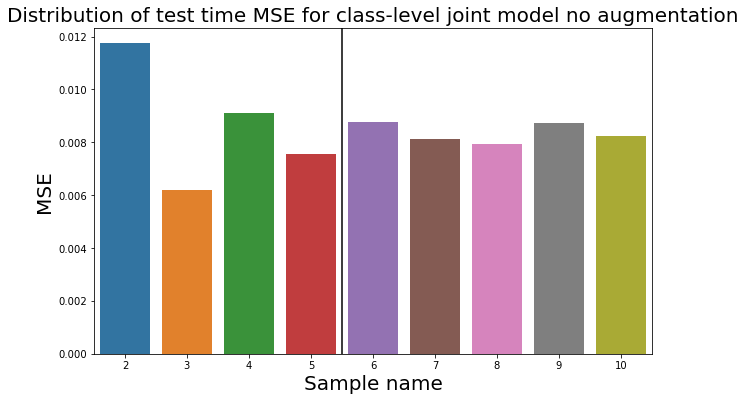

In [ ]:
######################################################################################
#### Figure 7A Joint model without data augmentation test-time MSE leave-one out 
######################################################################################
temp = [abnoaug1_mse_tracker['hmse'].append(k) for k in abnoaug1_mse_tracker['dmse']]
plt.subplots(figsize=(10,6))
p = sns.barplot(x = np.arange(2,11),y = abnoaug1_mse_tracker['hmse'])
p.set_xlabel("Sample name", fontsize=20)
p.set_ylabel("MSE", fontsize=20)
p.set_title("Distribution of test time MSE for class-level joint model no augmentation", fontsize=20)
p.axvline(x = 3.5, color = "black")
plt.show()

In [ ]:
# tmp = pd.DataFrame(abnoaug1_mse_tracker['hmse'])
# tmp.to_csv("an_noaug1.csv")

##### Figure 7B. Joint model trained without data augmentation leave two samples out

In [ ]:
abnoaug2_model_list , abnoaug2_history_tracker , abnoaug2_hmodel_prediction , abnoaug2_dmodel_prediction , abnoaug2_hsample_p , abnoaug2_dsample_p, abnoaug2_mse_tracker  = model_noaug_leave2_std (abh_sample, abd_sample, 
                                                                                                                                                                                  abh_samplex, abd_samplex, 
                                                                                                                                                                                  abh_sampley, abd_sampley, 
                                                                                                                                                                                  init_lr = 1e-2, epochs= 300)


Test on healhty sample: 2  disease sample:  6
Healthy sample prediction:  0
Healthy sample MSE:  [0.00994777143195639]
Disease sample prediction:  1
Disease sample MSE:  [0.010570134725997425]
Test on healhty sample: 2  disease sample:  7
Healthy sample prediction:  0
Healthy sample MSE:  [0.009361655148606575]
Disease sample prediction:  1
Disease sample MSE:  [0.009845499963974826]
Test on healhty sample: 2  disease sample:  8
Healthy sample prediction:  0
Healthy sample MSE:  [0.007651953381891657]
Disease sample prediction:  1
Disease sample MSE:  [0.014291658013848019]
Test on healhty sample: 2  disease sample:  9
Healthy sample prediction:  0
Healthy sample MSE:  [0.008937176291999764]
Disease sample prediction:  1
Disease sample MSE:  [0.010999452269161764]
Test on healhty sample: 2  disease sample:  10
Healthy sample prediction:  0
Healthy sample MSE:  [0.009156917438135395]
Disease sample prediction:  1
Disease sample MSE:  [0.008884726865290953]
Test on healhty sample: 3  dis

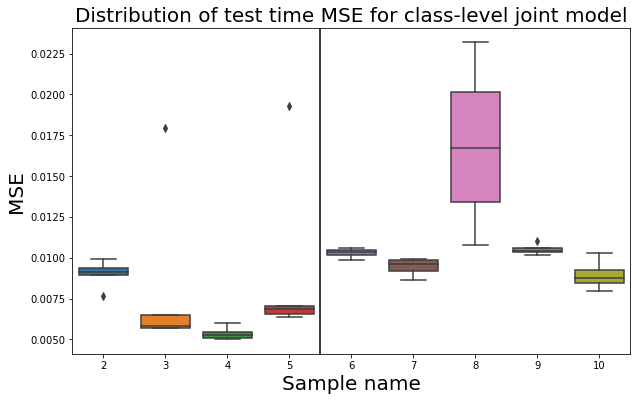

In [ ]:
abno_aug_mse = plot_MSE(abnoaug2_mse_tracker)
abno_aug_mse.to_csv("abno_aug_mse")

##### Figure 7C. Joint model trained with data augmentation leave one sample out

In [ ]:
abaug1_model_list , abaug1_history_tracker , abaug1_hmodel_prediction , abaug1_dmodel_prediction , abaug1_hsample_p , abaug1_dsample_p, abaug1_mse_tracker, abaug1_scaler, hscale_y, dscale_y  = model_run_leave1_std (abh_sample, abd_sample, 
                                                                                                                                                                                  abh_samplex, abd_samplex, 
                                                                                                                                                                                  abh_sampley, abd_sampley, 
                                                                                                                                                                                  init_lr = 1e-2, epochs= 300)


Test on healhty sample: 2
Healthy sample prediction:  0
Healthy sample MSE:  [0.005597012431617094]
Test on healhty sample: 3
Healthy sample prediction:  0
Healthy sample MSE:  [0.002885335250233273]
Test on healhty sample: 4
Healthy sample prediction:  0
Healthy sample MSE:  [0.004071126159757965]
Test on healhty sample: 5
Healthy sample prediction:  0
Healthy sample MSE:  [0.0026850241701575532]
Test on disease sample:  6
Disease sample prediction:  1
Disease sample MSE:  [0.003002407872854707]
Test on disease sample:  7
Disease sample prediction:  1
Disease sample MSE:  [0.0029913753969003126]
Test on disease sample:  8
Disease sample prediction:  1
Disease sample MSE:  [0.002560870868274626]
Test on disease sample:  9
Disease sample prediction:  1
Disease sample MSE:  [0.00382538756344631]
Test on disease sample:  10
Disease sample prediction:  1
Disease sample MSE:  [0.0033791980386681654]


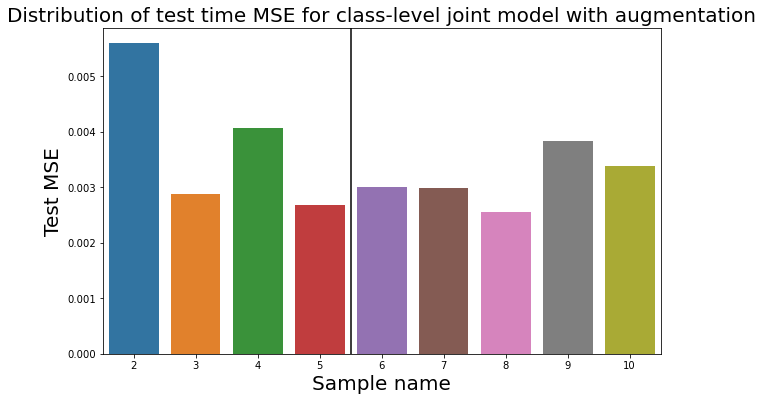

In [ ]:
temp = [abaug1_mse_tracker['hmse'].append(k) for k in abaug1_mse_tracker['dmse']]
plt.subplots(figsize=(10,6))
p = sns.barplot(x = np.arange(2,11),y = abaug1_mse_tracker['hmse'])
p.set_xlabel("Sample name", fontsize=20)
p.set_ylabel("Test MSE", fontsize=20)
p.set_title("Distribution of test time MSE for class-level joint model with augmentation", fontsize=20)
p.axvline(x = 3.5, color = "black")
plt.show()

In [ ]:
# tmp = pd.DataFrame(abaug1_mse_tracker['hmse'])
# tmp.to_csv("ab_aug1.csv")

##### Figure 7D. Joint model trained with data augmentation leaving two samples out

In [ ]:
abaug2_model_list , abaug2_history_tracker , abaug2_hmodel_prediction , abaug2_dmodel_prediction , abaug2_hsample_p , abaug2_dsample_p, abaug2_mse_tracker,  scaler_tracker  = model_run_leave2_std (abh_sample, abd_sample, 
                                                                                                                                                                                  abh_samplex, abd_samplex, 
                                                                                                                                                                                  abh_sampley, abd_sampley, 
                                                                                                                                                                                  init_lr = 1e-2, epochs= 300)


Test on healhty sample: 2  disease sample:  6
Healthy sample prediction:  0
Healthy sample MSE:  [0.0050689943620054615]
Disease sample prediction:  1
Disease sample MSE:  [0.004251633419552758]
Test on healhty sample: 2  disease sample:  7
Healthy sample prediction:  0
Healthy sample MSE:  [0.004544034988001703]
Disease sample prediction:  1
Disease sample MSE:  [0.003278259947898858]
Test on healhty sample: 2  disease sample:  8
Healthy sample prediction:  0
Healthy sample MSE:  [0.004678214204050132]
Disease sample prediction:  1
Disease sample MSE:  [0.003199861842031307]
Test on healhty sample: 2  disease sample:  9
Healthy sample prediction:  0
Healthy sample MSE:  [0.00497204579600093]
Disease sample prediction:  1
Disease sample MSE:  [0.004145052652014105]
Test on healhty sample: 2  disease sample:  10
Healthy sample prediction:  0
Healthy sample MSE:  [0.0061657555057005155]
Disease sample prediction:  1
Disease sample MSE:  [0.0058407280559189196]
Test on healhty sample: 3  

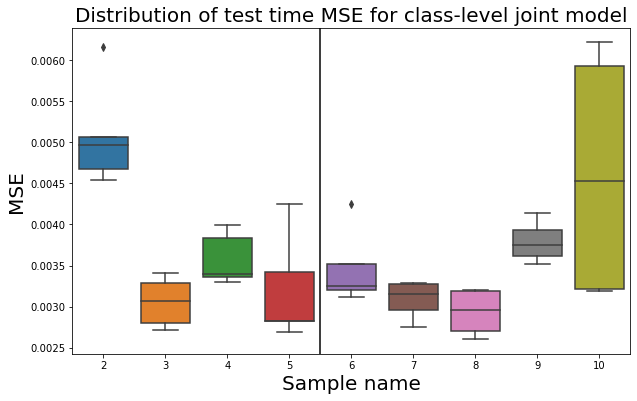

In [ ]:
ab_aug_mse = plot_MSE(abaug2_mse_tracker)

##### Figure 7E. Comparisons of leave-one-out model performance in augmented vs unaugmented model training

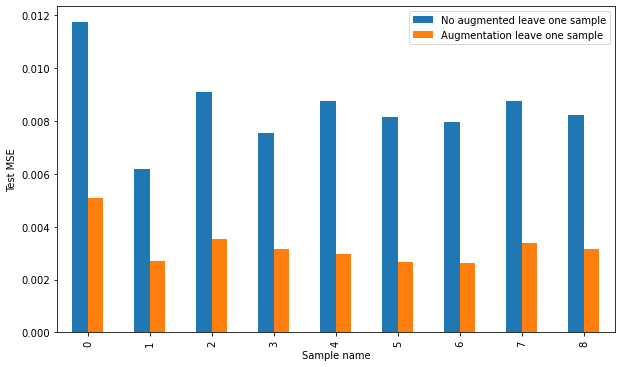

In [ ]:
p = pd.DataFrame({ "No augmented leave one sample":abnoaug1_mse_tracker['hmse'],
                  "Augmentation leave one sample":abaug1_mse_tracker['hmse']}).plot.bar(figsize=(10,6), xlabel ="Sample name")                                                                                                                                            ylabel ="Test MSE")

plt.show()
p.get_figure().savefig("abs_augcomp.png")

##### Figure 7F. Comparisons of leave-two-out model performance in augmented vs unaugmented model training

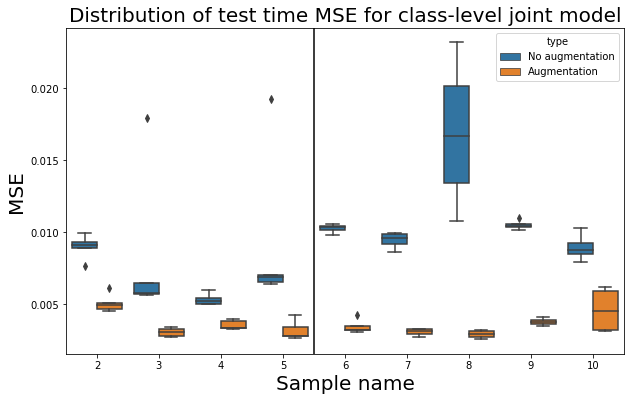

In [ ]:
no_aug_mse = abno_aug_mse.copy()
aug_mse = ab_aug_mse.copy()

no_aug_mse['type']="No augmentation"
aug_mse['type']="Augmentation"

gather = pd.concat([no_aug_mse, aug_mse], axis=0)

plt.subplots(figsize=(10,6))
p = sns.boxplot(y= 'mse', x='label' ,data=gather, hue ="type")
p.set_xlabel("Sample name", fontsize=20)
p.set_ylabel("MSE", fontsize=20)
p.set_title("Distribution of test time MSE for class-level joint model", fontsize=20)
p.axvline(x = 3.5, color = "black")
plt.show()

#### Figure 7G. Accuracy profliing of sample origin

Here, we show one of the trained models leaving sample 4 out for prediction. Most of the models show a robust prediction for sample origin classification. Yet, we observe that the trend in absolute abundance may be harder to predict compared to the relative abundance, illustrated by the oscillation of accuracy in the early epochs.

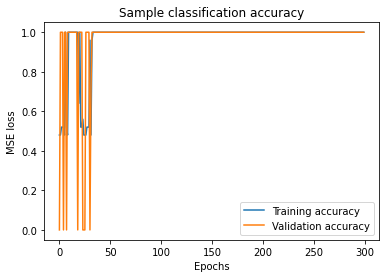

In [ ]:
plot_model_history(abaug1_history_tracker[2])

#### Figure 7H. Best model prediction of absolute abundance 

Here we chose to show the prediction results of the best performing leave-one-out model for prediction on healthy sample 3 and disease sample 8. In model training and prediction time, we scaled the data to be bound between zero and one. In plotting, we transformed the values back with the trained scaler to show the predicted values in their original log abundance scale. This may be the major source of noise introduced in the prediction plot. The inability to directly model the actual abundance may be a limitation for our absolute abundance prediction model. 

We observed that for the disease sample prediction all classes seem to have systematic error in prediction across time while the pattern of residuals are less clear. This can indicate that our models may have laerned a systematic error that have caused the uniform change across classes in the disease group.

In [ ]:
def plot_prediction_ab(re_pred, re_truth, save=None):
    '''
    save= file name; if not save leave it none
    '''
    fig, ax = plt.subplots(4,3 , figsize =(30,20))
    fig.delaxes(ax[3,2])
    for i , axs in enumerate(ax.ravel()):

        if i < re_pred.shape[1]:

            name = re_pred.columns[i]
            axs.plot(re_truth.iloc[:,i], label = name +" Ground truth", color = "red")
            axs.plot(re_pred.iloc[:,i], label = name +" Prediction", color="blue")
            axs.set_title(name)
            #axs.set_ylim((0,1))

            axs.axvspan(min((np.where(new_time>=21.5))[0]), 
                      min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label='High Fat')
            axs.axvspan(min((np.where(new_time>=35.5))[0]), 
                      min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label='Vancomycin')
            axs.axvspan(min((np.where(new_time>=50.5))[0]), 
                      min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label='Gentamicin')

            axs.set_xticks(range(0,len(re_pred.index)))
            axs.set_xticklabels(list(re_pred.index),rotation=90, fontsize = 7 )
            axs.legend()
    plt.show()    
    
    if save != None:
        fig.savefig(save+".png")


In [ ]:
def plot_resid_ab(re_pred, re_truth, save=None):

    axes = re_truth.subtract(re_pred).plot.line(rot=90, subplots=False, figsize=(17,6))
    axes.set_xticks(range(0,len(re_truth.index)))
    axes.set_xticklabels( list(re_truth.index))

    axes.axvspan(min((np.where(new_time>=21.5))[0]), 
                      min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label='High Fat')

    axes.axvspan(min((np.where(new_time>=35.5))[0]), 
                      min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label='Vancomycin')

    axes.axvspan(min((np.where(new_time>=50.5))[0]), 
                      min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label='Gentamicin')
    
    axes.set_xlabel("Time", fontsize=20)
    axes.set_ylabel("Residual", fontsize=20)
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.show()
    
    if save !=None:
        axes.get_figure().savefig(save+".png")


###### Healthy sample absolute abundance prediction plot by absolute log abundance and residuals

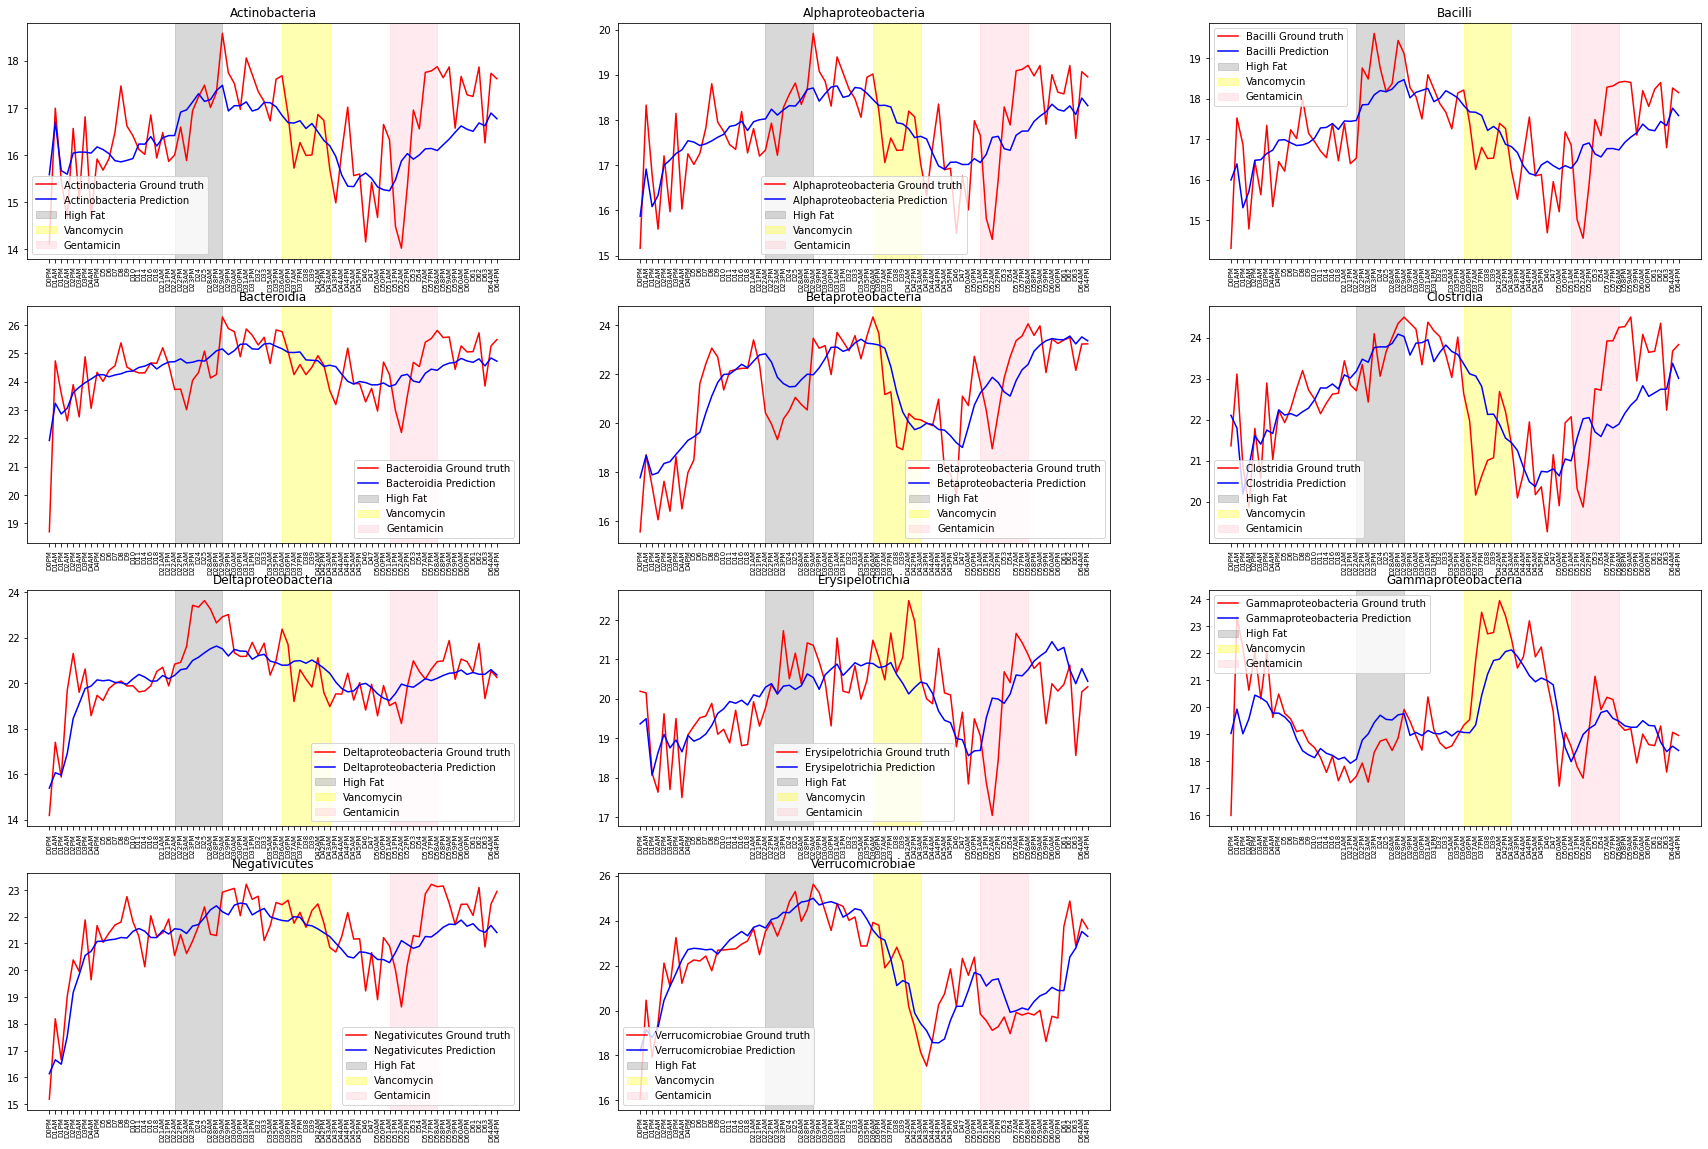

In [ ]:
###Backtransformed 
prediction = abaug1_scaler[1].inverse_transform(np.concatenate([absample3_x.reshape(76,11), abaug1_hmodel_prediction[1].reshape(76,11)], 
                                                     axis=1))[:,-11:]  

dpred =  pd.DataFrame(np.reshape(prediction,(76, sample2_x.shape[2])), 
                      columns = sample2.columns, index= sample2.index[1:])
dtrue = pd.DataFrame(np.reshape(absample3_y,(76,sample10_x.shape[2])), 
                     columns = sample2.columns, index= sample2.index[1:])

plot_prediction_ab(dpred, dtrue)

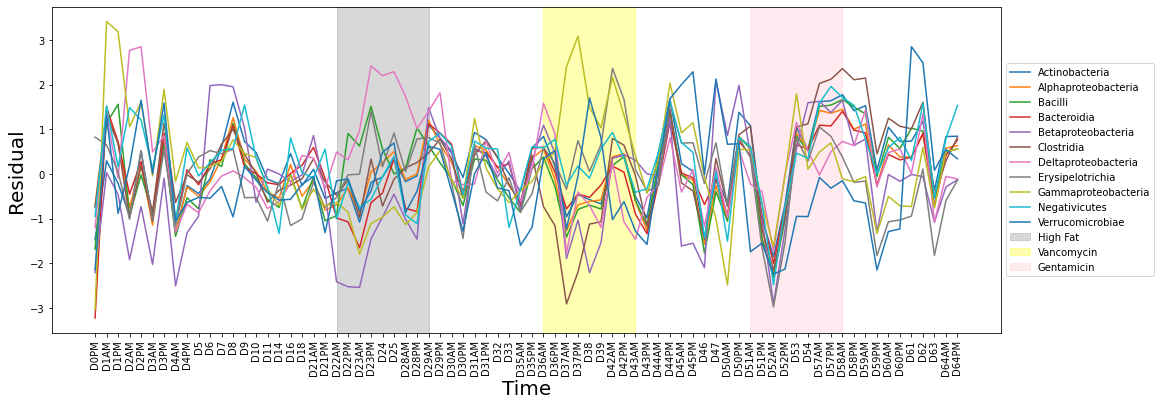

In [ ]:
plot_resid_ab(dpred, dtrue, "abs_resid")

###### Disease sample absolute abundance prediction plot by absolute log abundance and residuals

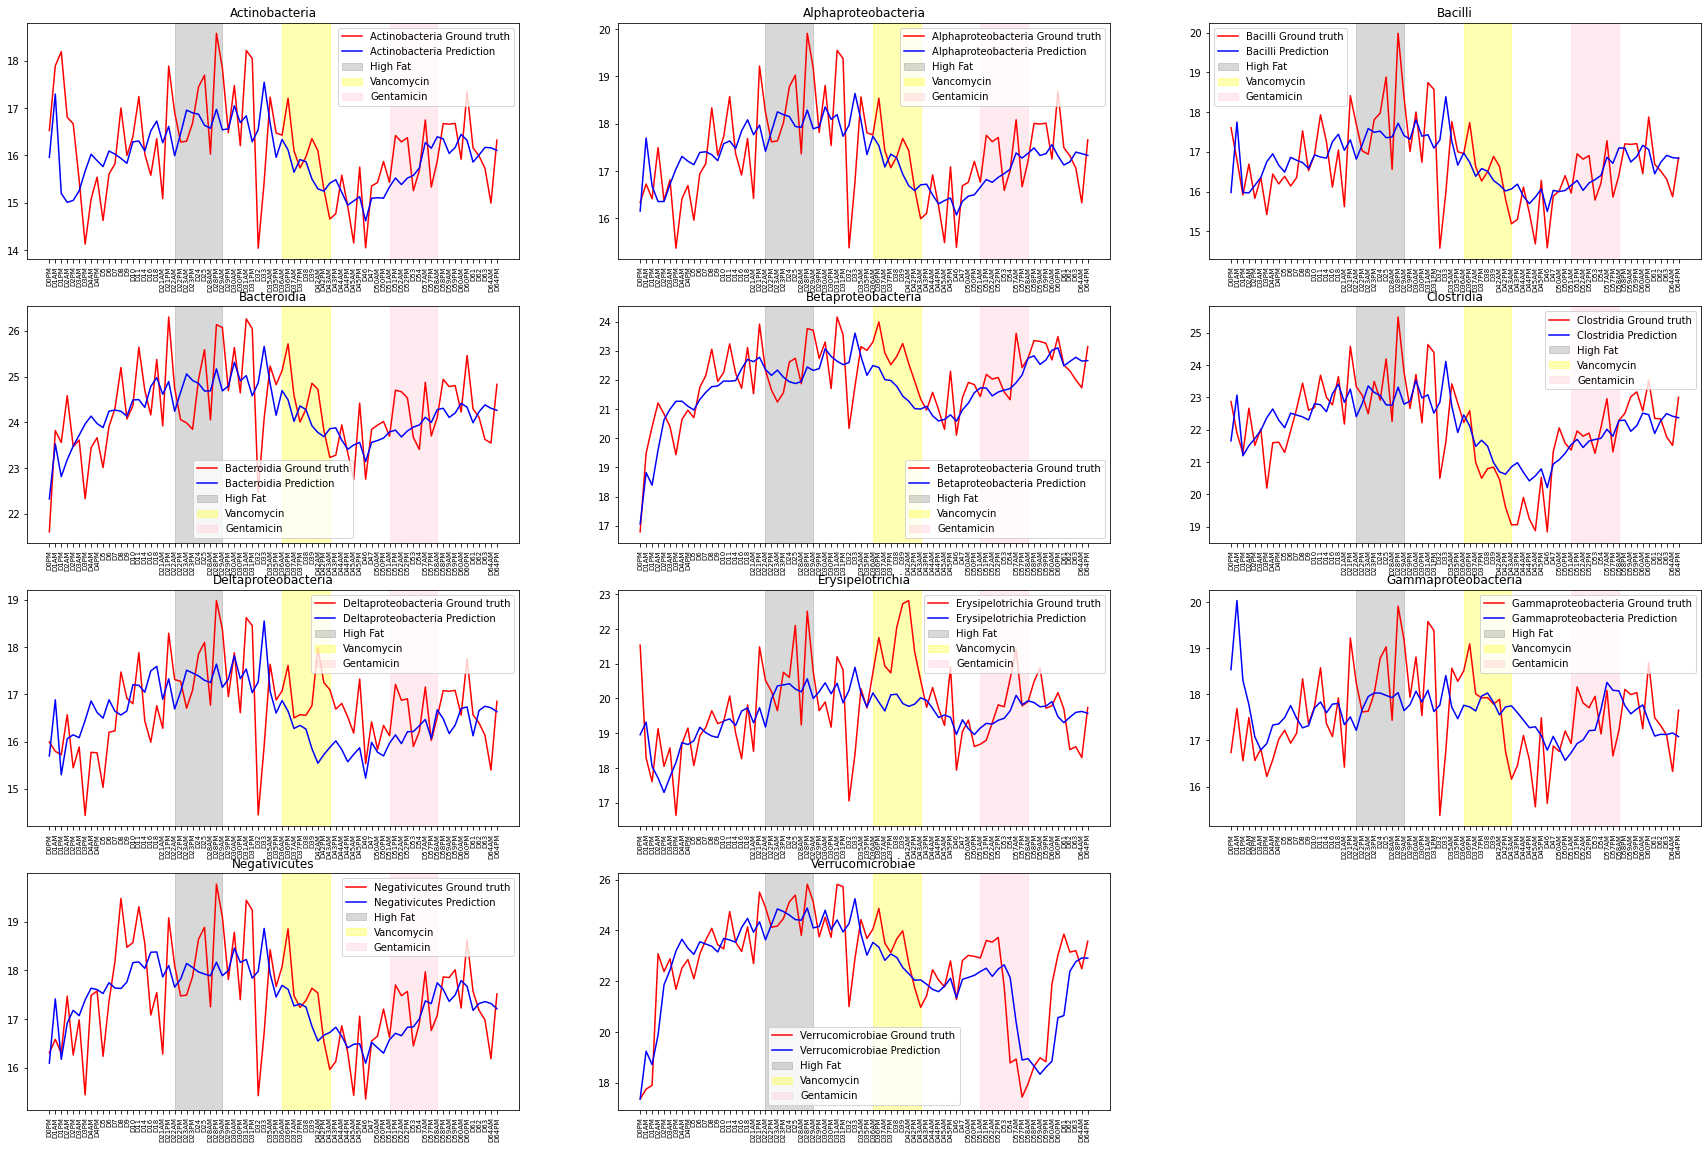

In [ ]:
###Backtransformed 
prediction = abaug1_scaler[6].inverse_transform(np.concatenate([absample8_x.reshape(76,11), abaug1_dmodel_prediction[2].reshape(76,11)], 
                                                     axis=1))[:,-11:]  

dpred =  pd.DataFrame(np.reshape(prediction,(76, sample2_x.shape[2])), 
                      columns = sample2.columns, index= sample2.index[1:])
dtrue = pd.DataFrame(np.reshape(absample8_y,(76,sample10_x.shape[2])), 
                     columns = sample2.columns, index= sample2.index[1:])

plot_prediction_ab(dpred, dtrue)

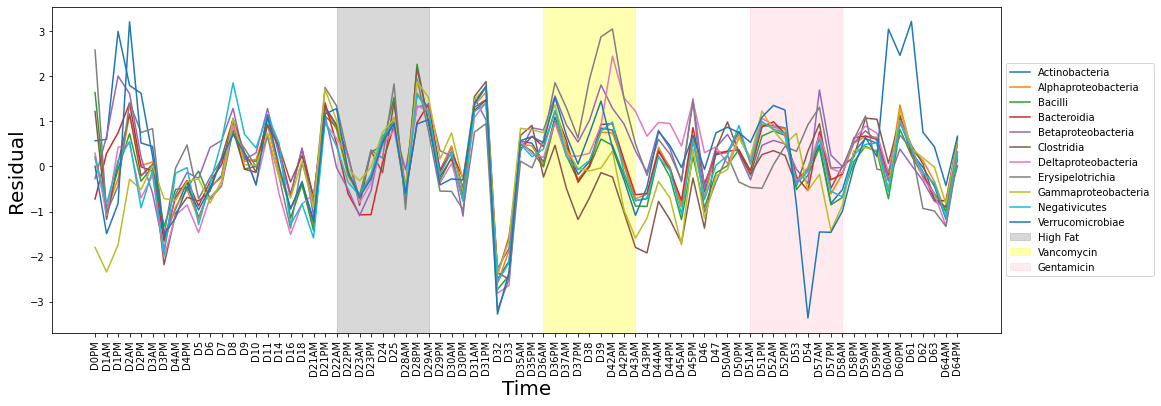

In [ ]:
plot_resid_ab(dpred, dtrue, "abs_dresid")

## Model application: In-silico experiment results

This last section showed that our multi-head models can be applied to conduct *in-silico* experiments. This finding has invaluable biological implications for using computational models in performing initial screens to identify potential experimental targets. Here we chose the best performing models in each prediction task: relative abundance, absolute abundance, and perturbed input data. 

Both the perturb_by_class and perturb_ab functions take in arguments of the class and time interval that we want to perturb to predict relative abundance and absolute abundance, respectively. In order to see a salient change in prediction and adherence to biological experiments, we applied our perturbation to a selected microbial class across the entire treatment interval. We assumed that each treatment is independent, so we hypothesized that perturbing a class at a specific time interval should yield changes in time steps immediately after. Thus, we measured absolute and relative changes for relative abundance predictions and relative change for absolute abundance predictions at the three timepoints immediately after treatment.    

First, since we have observed low abundance and relative abundances of Bacteroidia in the high-fat diet and contrasting high levels of Verrucomicrobiae, we hypothesized that these two classes might have antagonistic relationships. Two lines of evidence confirm this relationship. We see that artificially perturbing the system by increasing the abundance of Bacteroidia during the high-fat diet decreases the predicted relative abundance of Verrucomicrobiae in the immediate three time points (Figure 8A). When we perturb all classes during the high-fat diet, we see that the change in predictions for Bacteroidia and Verrucomicrobiae are in opposite directions (Figure 8B). We also show that this relationship is preserved in both the healthy and disease samples (Figure 8C). Both results suggest an antagonistic relationship between these two classes. 

Second, we were also interested in asking if there are relationships among bacterias that are present in either sample type. We have observed that healthy samples have higher diversity than disease samples. During Vancomyocin treatment particularly, Gammaproteobacteria has a higher abundance in the healthy group than in the disease group. We thus hypothesized that increasing the relative abundance of Gammaproteobacteria may cause different changes in class abundance in the healthy versus disease groups. We confirm this hypothesis by showing that changes in the three time points immediately after Vancomycin treatment are more prominent in the healthy group than in the disease group (Figure 9). 

Lastly, we also used our absolute abundance model to predict on the increase of Bacteroidia and decrease of Verrucomicrobiae during high fat diet. Instead of seeing the antagonistic relationships between Bacteroidia and Verrucomicrobia in relative abundance, we actually observed that the rebound rates are different between healthy and ulcerative colitis groups in the three timepoints immediately after Bacteroidia perturbation (Figure 10A,10B. However, rebound rates are consistent for both groups at three timepoints after Verrucomicrobia perturbation (Figure 10C, D). This provides another piece of evidence that different perturbations can impose diverse effects on microbe-microbe and microbe-host interactions.


In [ ]:
#### Use the best model from Section I to do perturbation prediction 
best_model = aug2_mode_list[4]

In [ ]:
best_model.save("rl_bestmodel")

INFO:tensorflow:Assets written to: rl_bestmodel/assets


INFO:tensorflow:Assets written to: rl_bestmodel/assets


#### Perturbation helper functions


In [ ]:
perturb1 = ['D22AM', 'D22PM', 'D23AM', 'D23PM', 'D24', 'D25','D28AM', 'D28PM', 'D29AM']
response1 = ['D29PM', 'D30AM', 'D30PM', 'D31AM', 'D31PM','D32', 'D33', 'D35AM', 'D35PM']

perturb2 = ['D36AM', 'D36PM', 'D37AM', 'D37PM','D38', 'D39', 'D42AM', 'D42PM', 'D43AM']
response2 = ['D43PM', 'D44AM', 'D44PM','D45AM', 'D45PM', 'D46', 'D47', 'D50AM', 'D50PM']

perturb3 = ['D51AM', 'D51PM','D52AM', 'D52PM', 'D53', 'D54', 'D57AM', 'D57PM', 'D58AM']
response3 = ['D58PM', 'D59AM', 'D59PM', 'D60AM', 'D60PM', 'D61', 'D62', 'D63', 'D64AM','D64PM']


######################################################################################
#### Helper function that adds perturbation to the original data 
######################################################################################

def preprocess_perturb (subset, class_name , time ,percent):
    
    ##add taxonomy information
    class_matrix = pd.concat([subset , normalized_matrix],axis=1)
    
    ##select subset
    class_matrix = class_matrix[class_matrix.Class.isin(subset_class)] 
    
    ##perturb
    class_matrix.loc[class_matrix.Class == class_name, time] += percent*class_matrix.loc[class_matrix.Class == class_name, time]
    
    ##Group by Class in each sample individually 
    class_matrix = class_matrix.groupby("Class").sum() 
    
    ##Reorder time points for each sample, drop taxonomy information 
    class_matrix = class_matrix.iloc[:,list(sample_metadata.time.sort_values().index - min(sample_metadata.index))]
    
    ##calculate relative abundance
    t_class = class_matrix.T
    sample_abundance = t_class.div(t_class.sum(axis=1), axis=0)
    
    ##Trim last time step for X
    sample_x = sample_abundance.iloc[:-1,:]
    
    ##Trim first time step for Y
    sample_y = sample_abundance.iloc[1:,:]
    
    sample_x = np.array(sample_x)
    sample_x = np.reshape(sample_x, ( 1,sample_x.shape[0], sample_x.shape[1]))
    
    sample_y = np.array(sample_y)
    sample_y = np.reshape(sample_y, ( 1,sample_y.shape[0], sample_y.shape[1]))
    
    return sample_abundance , np.array(sample_x) , np.array(sample_y)


######################################################################################
#### Helper function that conducts prediction on perturbed data 
######################################################################################

def perturb (name_index , perturb_level, 
             sample_list, sample_orig, sample_origy, 
             model, 
             perturb_time, response_time ):
    
    '''
    name_index: integer, range(number of classes)
    perturb_level: float, any real number [50%, 200%, 500%]
    
    model: trained best model for prediction
    
    sample_list = [sample_class2 ,impute_sample3 , impute_sample4, sample_class5 ] ##mean imputed value
    sample_orig = [sample2_x , sample3_x, sample4_x, sample5_x] ##relative abundance
    sample_origy = [sample2_y , sample3_y, sample4_y, sample5_y] ##relative abundance 
    
    # sample6, sample6_x, sample6_y = relative_abundance(sample_class6, 6)
    # sample7, sample7_x, sample7_y = relative_abundance(impute_sample7, 7)
    # sample8, sample8_x, sample8_y = relative_abundance(sample_class8, 8)
    # sample9, sample9_x, sample9_y = relative_abundance(sample_class9, 9)
    # sample10, sample10_x, sample10_y = relative_abundance(impute_sample10, 10)
    
    perturb_time: list, one of [perturb1, perturb2, perturb3]
    perturb_response: list, one of [response1, response2, response3]
    '''
    
    perturb_pred = []
    perturb_diff = []
    relative_diff = []

    for indx ,sample in enumerate(sample_list):

        orignal = sample_orig[indx]
        orignal_y = sample_origy[indx]
        
        ##Perturb one single class concentration and turn matrix into relative matrix 
        s2, s2_x, s2_y = preprocess_perturb (sample, 
                                             sample2.columns[name_index], 
                                             perturb_time, 
                                             perturb_level)
        
        ##Predict time series from perturbed input data (predicted perturbed data T1-Tn)
        sample_pred =  pd.DataFrame(np.reshape(model.predict(s2_x)[0],(76,11)), 
                                     columns = sample2.columns, 
                                     index= sample2.index[1:])
        ##Perturbed ground truth T1-Tn
        sample_df = pd.DataFrame(np.reshape(s2_y,(76,11)), 
                                  columns = sample2.columns, 
                                  index= sample2.index[1:])
        ##Unperturbed ground truth T1-Tn
        sample_no = pd.DataFrame(np.reshape(orignal_y,(76,11)), 
                              columns = sample2.columns, index= sample2.index[1:])
        
        ##Time index 
        timeframe = perturb_time+response_time
        
        ##Difference = Predicted outcome - Ground truth no perturbation 
        diff = sample_pred.loc[timeframe,:].subtract(sample_no.loc[timeframe,:])
        
        ##Relative change = (perturbed prediction - ground truth)/ ground truth
        relative_change= diff.divide(sample_no.loc[timeframe,:])
        ##If ground truth is 0, set infinity value to NA
        relative_change.replace([np.inf, -np.inf], np.nan, inplace=True)
        ##Change any NA to 0 
        relative_change = relative_change.fillna(0)
        
        ##Store perturbed value for each tested sample
        perturb_pred.append(sample_pred)
        perturb_diff.append(diff)
        relative_diff.append(relative_change)   
    
    ##Mean relative difference across healthy or disease samples
    mean_diff = pd.concat(relative_diff).reset_index().groupby('index').mean()
    
    return sample_pred,sample_df,sample_no, perturb_pred , perturb_diff, relative_diff, mean_diff


##############################################################################################
#### Helper function that compraes perturbation prediction results in healthy and disease group  
##############################################################################################

def perturb_sample_comp(class_name, perturb_time, response_time, perturb_level, ogsample , samplex, sampley, d_ogsample, dsamplex, dsampley, model, title):
  
  
  re_pred,re_truth,pre_truth, perturb_pred , hperturb_diff, relative_diff, hmean_diff= perturb (name_index = list(sample2.columns).index(class_name) , 
                                                                                                      perturb_level = perturb_level, 
                                                                         sample_list = [ogsample], 
                                                                         sample_orig = [samplex], 
                                                                         sample_origy = [sampley], 
                                                                         model = model, 
                                                                         perturb_time = perturb_time, 
                                                                         response_time = response_time)
    
  re_pred,re_truth,pre_truth, perturb_pred , dperturb_diff, relative_diff, dmean_diff= perturb (name_index = list(sample2.columns).index(class_name) , 
                                                                                                      perturb_level = perturb_level, 
                                                                         sample_list = [d_ogsample], 
                                                                         sample_orig = [dsamplex], 
                                                                         sample_origy = [dsampley], 
                                                                         model = model, 
                                                                         perturb_time = perturb_time, 
                                                                         response_time = response_time)
    
  comb = hperturb_diff[0].append(dperturb_diff[0])
    
  tmp= comb.loc[response_time[0],:]
  tmp.index =['Healthy '+response_time[0] ,'Disease ' + response_time[0]]
  p = tmp.T.plot.barh(ylabel="Absolute change in class composition %", 
                                             figsize=(10,6), xlim=(-0.5,0.5), title=title)

  p.get_figure().savefig("perturb1.png") 
    
  tmp= comb.loc[response_time[1],:]
  tmp.index =['Healthy ' + response_time[1],'Disease '+ response_time[1]]
  p = tmp.T.plot.barh(ylabel="Absolute change in class composition %", figsize=(10,6), xlim=(-0.5,0.5))

  p.get_figure().savefig("perturb2.png")   
    
  tmp= comb.loc[response_time[2],:]
  tmp.index =['Healthy '+ response_time[2],'Disease '+response_time[2]]
  p = tmp.T.plot.barh(ylabel="Absolute change in class composition %", figsize=(10,6), xlim=(-0.5,0.5))

  p.get_figure().savefig("perturb3.png") 

    
######################################################################################################################
#### Main function that calls "perturb" function to conduct perturbation with a specified class at and time interval 
#### This function includes plots of each predicted class results and absolute change from baseline 
######################################################################################################################

def perturb_by_class(class_name, perturb_time, response_time, perturb_level, 
                     ogsample , samplex, sampley, model, title):


    re_pred,re_truth,pre_truth, perturb_pred , perturb_diff, relative_diff, hmean_diff= perturb (name_index = list(sample2.columns).index(class_name) , 
                                                                                                      perturb_level = perturb_level, 
                                                                         sample_list = [ogsample], 
                                                                         sample_orig = [samplex], 
                                                                         sample_origy = [sampley], 
                                                                         model = model, 
                                                                         perturb_time = perturb_time, 
                                                                         response_time = response_time)
    
    fig, ax = plt.subplots(4,3 , figsize =(30,20))
    fig.delaxes(ax[3,2])
    for i , axs in enumerate(ax.ravel()):

        if i < re_pred.shape[1]:

            name = re_pred.columns[i]
            axs.plot(re_truth.iloc[:,i], label = name +" Perturb Ground truth", color = "red")
            axs.plot(re_pred.iloc[:,i], label = name +" Prediction", color="blue")
            
            axs.plot(pre_truth.iloc[:,i], label = name +" Ground truth", color = "green")
            
            axs.set_title(name)
            axs.set_ylim((0,1))

            axs.axvspan(min((np.where(new_time>=21.5))[0]), 
                      min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label="High fat")
            axs.axvspan(min((np.where(new_time>=35.5))[0]), 
                      min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label="Vancomycin")
            axs.axvspan(min((np.where(new_time>=50.5))[0]), 
                      min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label="Gentamicin")

            axs.set_xticks(range(0,len(re_pred.index)))
            axs.set_xticklabels(list(re_pred.index),rotation=90, fontsize = 7 )
            axs.legend()
    fig.suptitle(title, fontsize=40)
    plt.show()    
    

    fig, ax = plt.subplots(1,3, figsize=(20,7))
    
    ax[0].barh(sample2.columns, perturb_diff[0].loc[response_time[0],:],
               color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink'])
    
    ax[1].barh(sample2.columns, perturb_diff[0].loc[response_time[1],:],
               color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink'])
    
    
    ax[2].barh(sample2.columns, perturb_diff[0].loc[response_time[2],:],
               color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink'])
    
    ax[1].set_yticks("")
    ax[2].set_yticks("")
    
    ax[0].set_ylabel('Class',fontsize=20)
    ax[0].set_xlabel("Absolute change in class composition %",fontsize=15)
    ax[1].set_xlabel("Absolute change in class composition %",fontsize=15)
    ax[2].set_xlabel("Absolute change in class composition %",fontsize=15)
    
    ax[0].axvline(x=0, color="black", linestyle="dashed")
    ax[1].axvline(x=0, color="black", linestyle="dashed")
    ax[2].axvline(x=0, color="black", linestyle="dashed")
    
    ax[0].set_title("Change at " + response_time[0], fontsize=20)
    ax[1].set_title("Change at " + response_time[1], fontsize=20)
    ax[2].set_title("Change at " + response_time[2], fontsize=20)
    
#     ax[0].set_xlim((-1,1))
#     ax[1].set_xlim((-1,1))
#     ax[2].set_xlim((-1,1))
    
    plt.show()
    
    fig.savefig(title+"_time.png")
    
    fig, ax = plt.subplots(1,3, figsize=(20,7))
    
    ax[0].barh(sample2.columns, hmean_diff.loc[response_time[0],:],
               color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink'])
    
    ax[1].barh(sample2.columns, hmean_diff.loc[response_time[1],:],
               color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink'])
    
    
    ax[2].barh(sample2.columns, hmean_diff.loc[response_time[2],:],
               color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink'])
    
    ax[1].set_yticks("")
    ax[2].set_yticks("")
    
    ax[0].set_ylabel('Class',fontsize=20)
    ax[0].set_xlabel("Relative change in class composition %",fontsize=15)
    ax[1].set_xlabel("Relative change in class composition %",fontsize=15)
    ax[2].set_xlabel("Relative change in class composition %",fontsize=15)
    
    ax[0].axvline(x=0, color="black", linestyle="dashed")
    ax[1].axvline(x=0, color="black", linestyle="dashed")
    ax[2].axvline(x=0, color="black", linestyle="dashed")
    
    ax[0].set_title("Change at " + response_time[0], fontsize=20)
    ax[1].set_title("Change at " + response_time[1], fontsize=20)
    ax[2].set_title("Change at " + response_time[2], fontsize=20)
    
    ax[0].set_xlim((-1,1))
    ax[1].set_xlim((-1,1))
    ax[2].set_xlim((-1,1))
    
    plt.show()    
    
    fig.savefig(title+"_change.png")

######################################################################################################################
#### Plot absolute or relative change per class after perturbing all 11 classes at a given time interval
######################################################################################################################


def plot_allperturb(mean_diff_list, class_to_plot, response_time, xlabel ):
    
    '''
    mean_diff_list: relative or absolute diff list
    ['Bacteroidia', 'Betaproteobacteria', 'Clostridia','Verrucomicrobiae']
    xlabel : 'Relative change from baseline'
    '''

    for name in class_to_plot:

        fig, ax = plt.subplots(1,3, figsize=(20,7))

        ax[0].barh(sample2.columns,pd.concat(mean_diff_list).loc[response_time[0],name],
                   color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink']
                  )
        ax[1].barh(sample2.columns,pd.concat(mean_diff_list).loc[response_time[1],name],
                   color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink']
                  )

        ax[2].barh(sample2.columns,pd.concat(mean_diff_list).loc[response_time[2],name],
                   color= ['aqua', 'blue', 'crimson', 'coral',
                            'gold', 'orange', 'purple', 'brown',
                            'teal', 'orchid', 'pink'])

        ax[1].set_yticks("")
        ax[2].set_yticks("")

        ax[0].set_ylabel('Perturbed Class',fontsize=20)
        ax[0].set_xlabel(xlabel,fontsize=20)
        ax[1].set_xlabel(xlabel,fontsize=20)
        ax[2].set_xlabel(xlabel,fontsize=20)

        ax[0].axvline(x=0, color="black", linestyle="dashed")
        ax[1].axvline(x=0, color="black", linestyle="dashed")
        ax[2].axvline(x=0, color="black", linestyle="dashed")

        ax[0].set_title(name+" at "+response_time[0], fontsize=20)
        ax[1].set_title(name+" at "+response_time[1], fontsize=20)
        ax[2].set_title(name+" at "+response_time[2], fontsize=20)

        ax[0].set_xlim((-1,1))
        ax[1].set_xlim((-1,1))
        ax[2].set_xlim((-1,1))
        
        fig.savefig(name+"_allpertub.png")
    

#### Figure 8  Bacteroidia and Verrucomicrobiae show antagonistic relationships at high fat diet for both disease and healthy donors  

- Figure 8A. The first panel shows the line plots of ground truth (green), true value after perturbation (red), and predicted relative abundance (blue). Here we showed a perturbation of Bacteroidia during high-fat diet (shaded in grey) and observed the predicted change of all other classes at the immediate three time points after high fat diet. The second panel shows the quantification of change in relative abundance after perturbation. The first row plots the absolute change of predicted relative abundance to the original abundance at that time point. The second row plots the relative change in predicted relative abundance to the original abundance at that time point. This entire plot shows that Verrucomicrobiae abundance is predicted to decrease with the increase of Bacteroidia during high-fat diet. 


- Figure 8B. The first row of box plots shows the relative change in relative abundance of Bacteroidia at the three immediate time steps after high-fat treatment with respect to incraseing levels of each of the eleven classes, on the y-axis, labels during the treatment for healthy samples. The second row shows the relative change in abundnace for Verrucomicrobiae with respect to the increaseing of each of the eleveb classes for healthy samples. We showed that Bacteroidia and Verrucomicrobiae respond to the perturbation of all classes in opposite directions particularly at the D29PM, the first time point after high-fat diet. 


- Figure 8C. This panel illustrates the same story as Figure 8B expcet that this experiment was done on a disease sample rather than a healthy sample. We showed that the opposite opposite to the perturbation of all eleven classes between Bacteroidia and Verrucomicrobiae holds in disease samples. This plot supports the hypothesis that Bacteroidia and Verrucomicrobiae may have antagonistic relationship during high fat treatment.

#### Figure 8A. Increasing the level of Bactoroidia decreases the relative abundance of Verrucomicrobiae

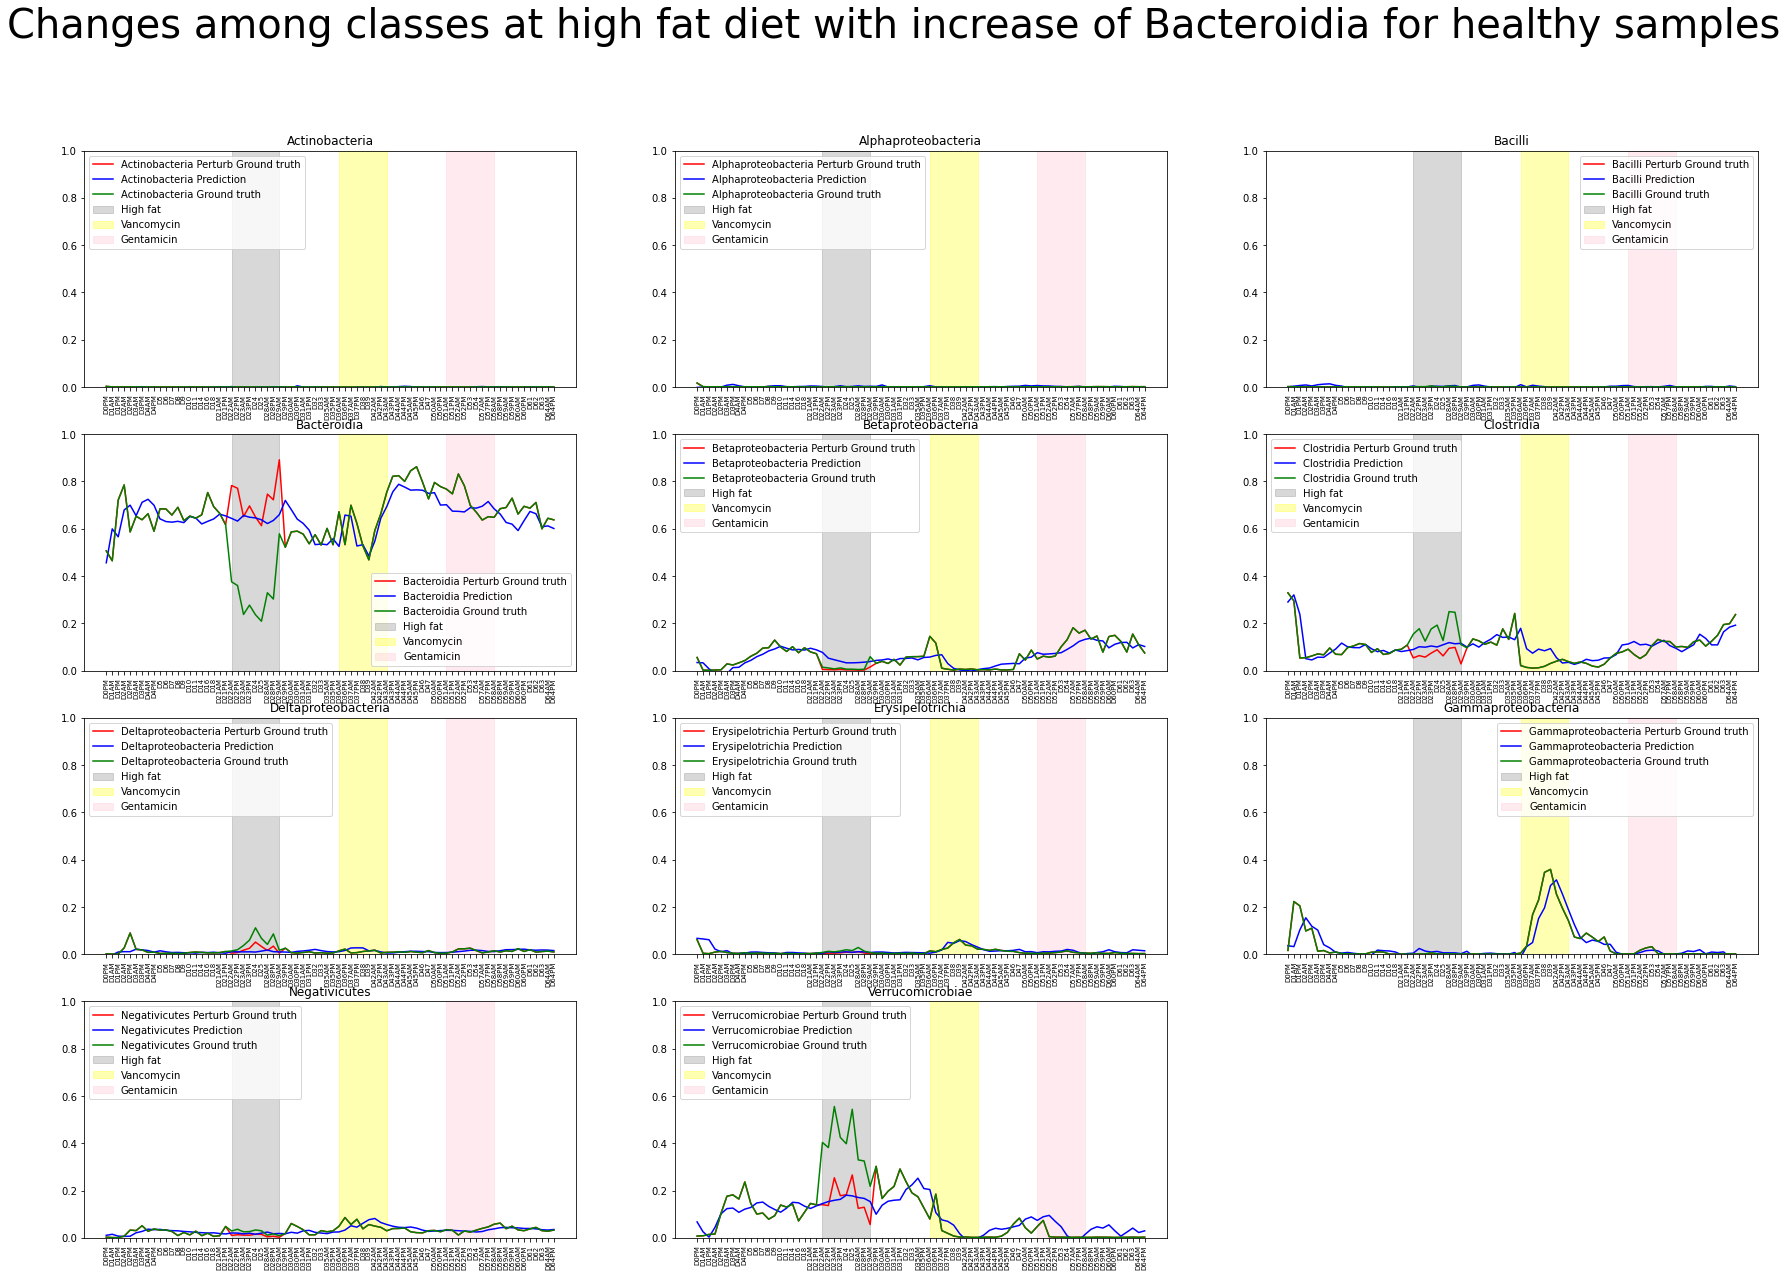

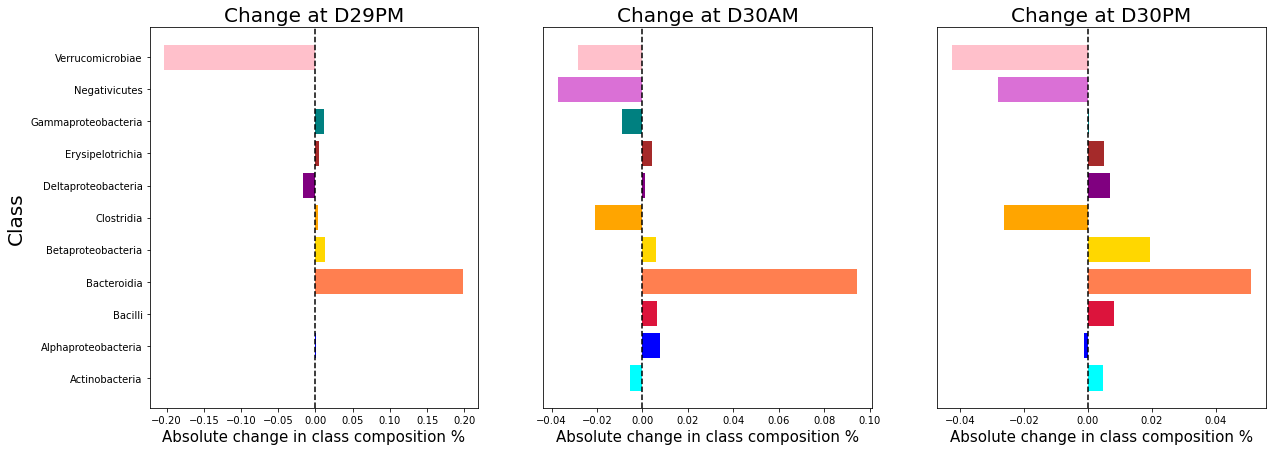

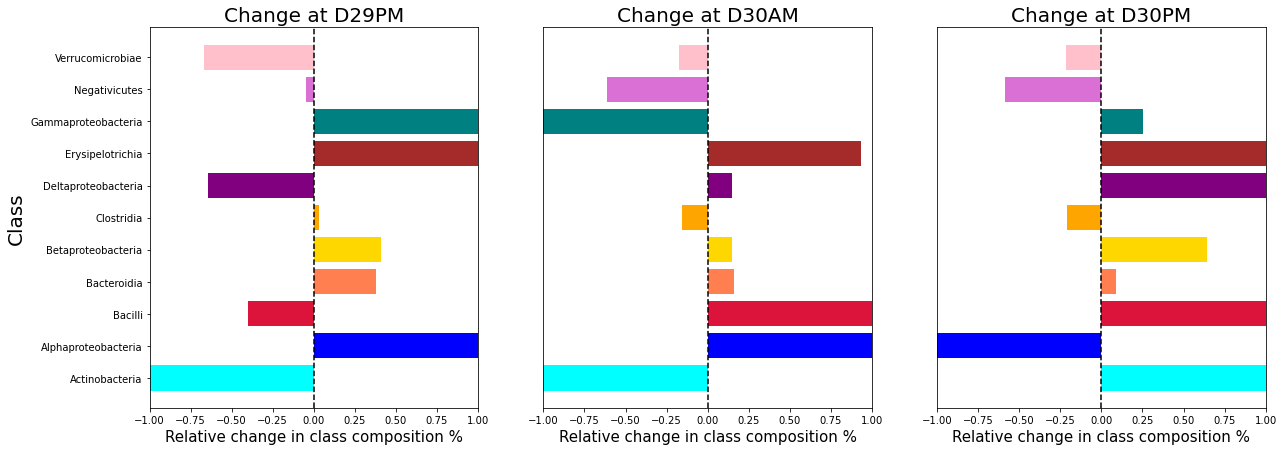

In [ ]:
###################################################################################################
# Figure8A Increasing level of Bactoroidia decreases the relative abundance of Verrucomicrobiae
####################################################################################################

perturb_by_class("Bacteroidia", perturb1, response1, 5, 
                 sample_class2 , sample2_x, sample2_y, best_model,
                 "Changes among classes at high fat diet with increase of Bacteroidia for healthy samples"
                )

#### Figure 8B. Bactoroidia and Verrucomicrobiae respond to class perturbations in opposite directions in the healthy group

Healthy samples:


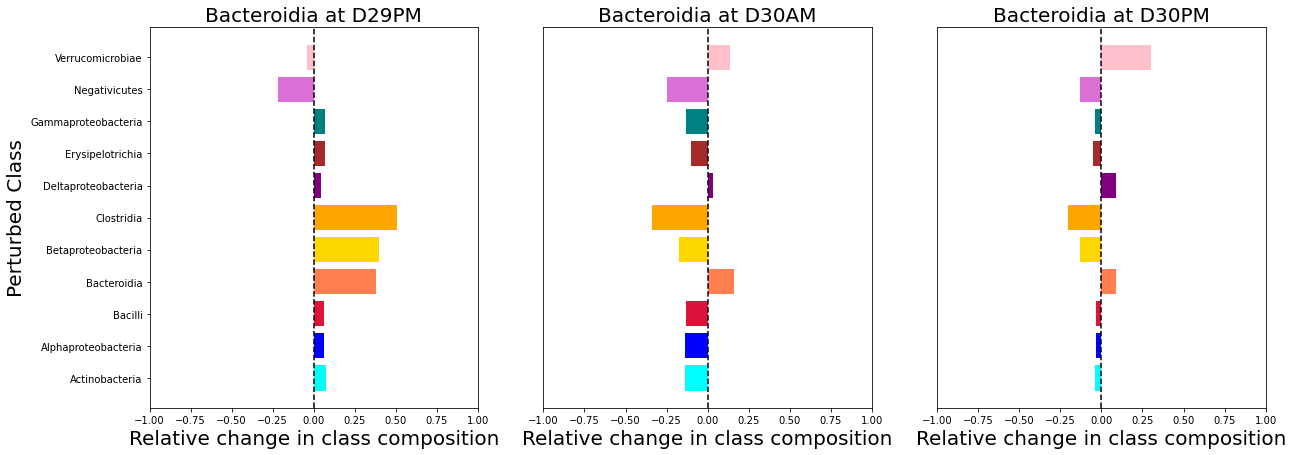

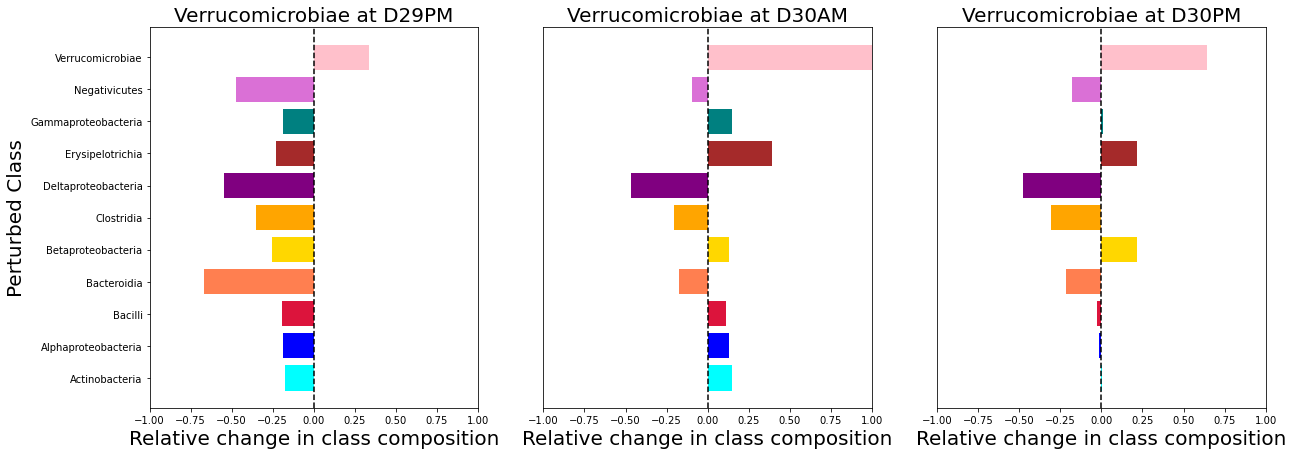

In [ ]:
###################################################################################################
# Figure8B Bactoroidia and Verrucomicrobiae respond to class perturbations in opposite directions in healthy group
####################################################################################################


hmean_diff_list = []
dmean_diff_list = []
hdiff_list = []
ddiff_list = []

for k in range(11):

    sample_pred,sample_df,sample_no, perturb_pred , hperturb_diff, relative_diff, hmean_diff= perturb (name_index = k , perturb_level = 5, 
                                                                     sample_list = [sample_class2], 
                                                                     sample_orig = [sample2_x], 
                                                                     sample_origy = [sample2_y], 
                                                                     model = best_model, 
                                                                     perturb_time = perturb1, 
                                                                     response_time = response1)
    
    sample_pred,sample_df,sample_no, perturb_pred , dperturb_diff, relative_diff, dmean_diff= perturb (name_index = k , perturb_level = 5, 
                                                                     sample_list = [impute_sample10], 
                                                                     sample_orig = [sample10_x], 
                                                                     sample_origy = [sample10_y], 
                                                                     model = best_model, 
                                                                     perturb_time = perturb1, 
                                                                     response_time = response1)
 
    hmean_diff_list.append(hmean_diff)
    dmean_diff_list.append(dmean_diff)
    hdiff_list.append(hperturb_diff[0])
    ddiff_list.append(dperturb_diff[0])

print("Healthy samples:")
plot_allperturb(hmean_diff_list, ['Bacteroidia', 'Verrucomicrobiae'], response1,"Relative change in class composition" )

#### Figure 8C. Bactoroidia and Verrucomicrobiae respond to class perturbations in opposite directions in the disease group

Disease samples: 


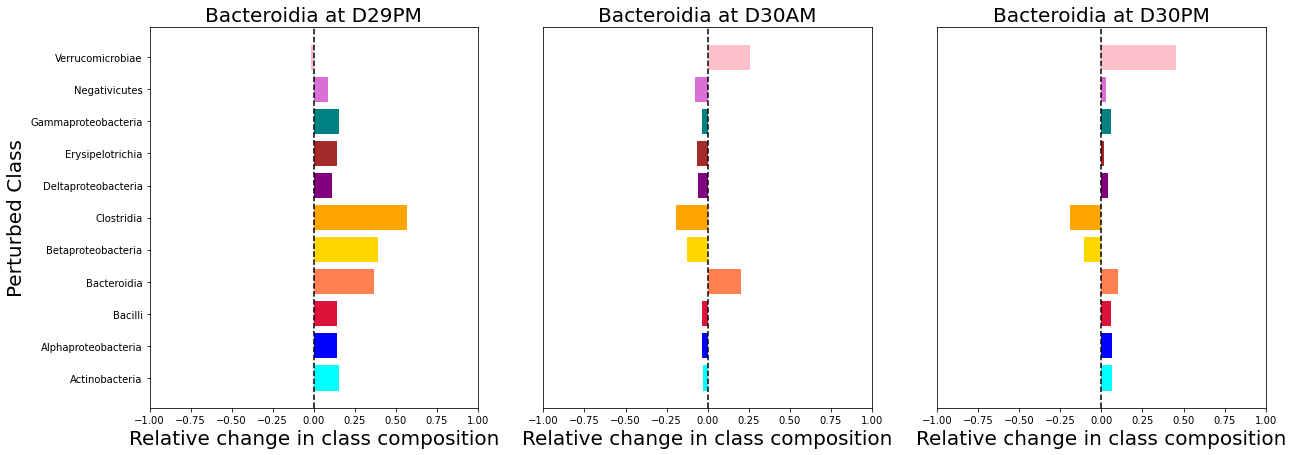

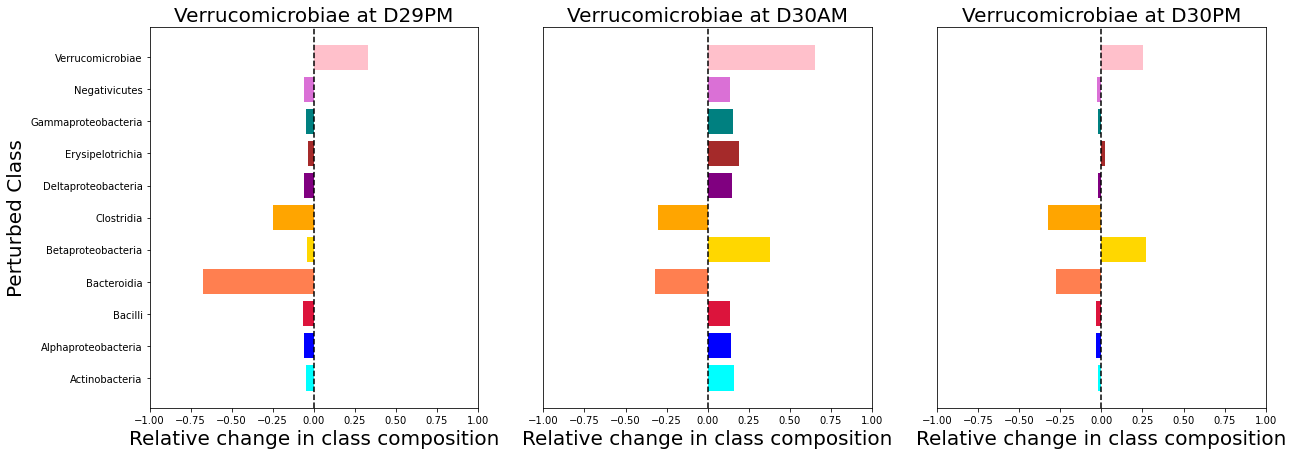

In [ ]:
###################################################################################################
# Figure8C Bactoroidia and Verrucomicrobiae respond to class perturbations in opposite directions in disease group
####################################################################################################


print("Disease samples: ")

plot_allperturb(dmean_diff_list, ['Bacteroidia', 'Verrucomicrobiae'], response1,"Relative change in class composition")

#### Figure 9. Gammaproteobacteria perturbation during Vancomyocin treatment has a larger impact on the healthy group than the disease group

Here we showed an example where healthy and disease samples have variable response to perturbations. We increased the level of Gammaproteobacteria 50% over the course of Vancomyocin treatment. We then predicted for the next three time steps after the treatment. We observed that Gammaproteobacteria has low relative abundance during Vancomyocin treatment for disease group to start off. The perturbation thus shows more significant impacts in healthy samples compared to disease samples. The first bar plot shows the relative change at D43PM, the first time step after Vancomyocin treatment, for each of the eleven classes after the single perturbation of Gammaproteobacteria during the treatment.The second bar plot shows the same information at the second time step, D44AM and the third plot for the third time step, D44PM. 

The change in healthy group was especially salient at the first time point while the effect of perturbation on all classes decreased at the second and third time points. This indicates that the system can reach equilibrium relatively quickly with the perturbation of Gammaproteobacteria. 

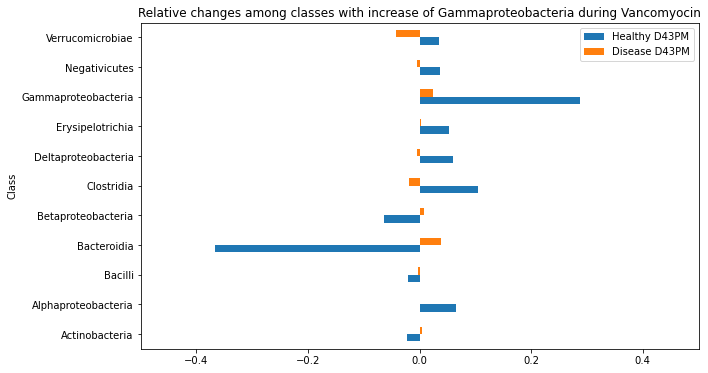

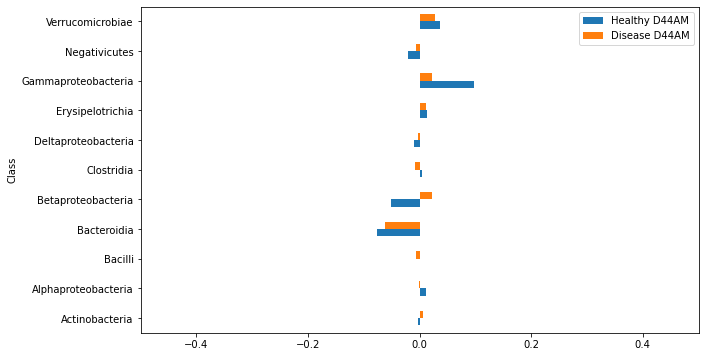

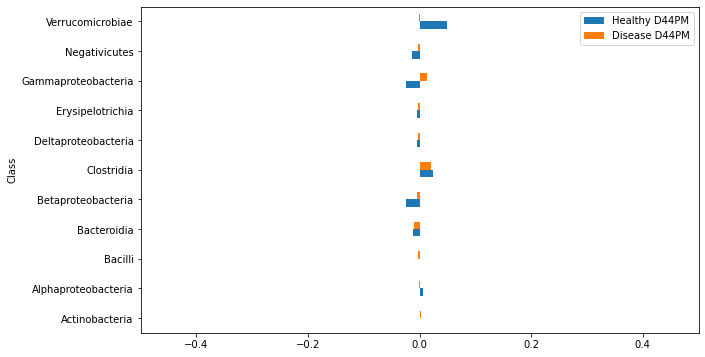

In [ ]:
perturb_sample_comp("Gammaproteobacteria", perturb2, response2, 5, 
                    
                    sample_class2 , sample2_x, sample2_y,  
                    impute_sample10, sample10_x, sample10_y, 
                    
                    best_model,
                    
                    "Relative changes among classes with increase of Gammaproteobacteria during Vancomyocin")

#### Figure 10. Healthy group has better "rebound" toward their original state

In [ ]:
def absolute_abudance_perturb(subset_class, time_id, sample_number, 
                              class_name , time, percent):
    '''

    subset_class: level at which taxon is included 
    time_id : time index from the original matrix 
    sample_number: int, indicates sample number 
    
    class_name: class to perturb
    time: perturbation interval
    
    '''
    ##Subset each sample from total absolute abundance matrix
    sample = absolu_abund_log[absolu_abund_log.index.isin(subset_class)].iloc[:,time_id.index].T
    
    ##change sample index name to rid of sample number
    sample.index = [i.replace( str(sample_number) +"-","") for i in list(sample.index)]
    
    ##Perturbation 
    sample.loc[time, class_name] += percent*sample.loc[time, class_name]
    
    
    ##Trim last time step for X
    datax = sample.iloc[:-1,:]
    
    ##Trim first time step for Y
    datay = sample.iloc[1:,:]
    
    samplex = np.reshape( np.asarray(datax), (1,datax.shape[0],  datax.shape[1]) )
    sampley = np.reshape( np.asarray(datay), (1,datay.shape[0],  datay.shape[1]) )
     
    return  sample, samplex ,sampley


In [ ]:
def perturb_ab (sample_list, sample_num ,perturb_class, perturb_time, 
                response_time, title , orig_x, orig_y , perturb_level , model_index):
    
    '''
    name_index: integer, range(number of classes)
    perturb_level: float, any real number [50%, 200%, 500%]
    
    model: trained best model for prediction
    
    sample_list = [sample_class2 ,impute_sample3 , impute_sample4, sample_class5 ] ##mean imputed value
    sample_orig = [sample2_x , sample3_x, sample4_x, sample5_x] ##relative abundance
    sample_origy = [sample2_y , sample3_y, sample4_y, sample5_y] ##relative abundance 
    
    # sample6, sample6_x, sample6_y = relative_abundance(sample_class6, 6)
    # sample7, sample7_x, sample7_y = relative_abundance(impute_sample7, 7)
    # sample8, sample8_x, sample8_y = relative_abundance(sample_class8, 8)
    # sample9, sample9_x, sample9_y = relative_abundance(sample_class9, 9)
    # sample10, sample10_x, sample10_y = relative_abundance(impute_sample10, 10)
    
    perturb_time: list, one of [perturb1, perturb2, perturb3]
    perturb_response: list, one of [response1, response2, response3]
    '''
    
    perturb_pred = []
    perturb_diff = []
    relative_diff = []
    
    ###sample_list = [time_3]
    ###perturb_time = perturb1
    
    for indx ,sample in enumerate(sample_list):
        
        
        perturb_sample3, perturb_sample3x , perturb_sample3y = absolute_abudance_perturb(subset_class, 
                                                                                         sample, sample_num,
                                                                                         perturb_class , 
                                                                                         perturb_time, 
                                                                                         perturb_level)
        
        ###Scale prediction 
        length = perturb_sample3x.shape[2]
        
        perturb_sample3x = np.reshape(perturb_sample3x, (-1,perturb_sample3x.shape[2] ))
        perturb_sample3y = np.reshape(perturb_sample3y, (-1,perturb_sample3y.shape[2] ))
        
        train_data = np.concatenate([perturb_sample3x, perturb_sample3y], axis=1)
        test_data = abaug1_scaler[model_index].transform(train_data)

        perturb_sample3x , _ =  test_data[:,:-length], test_data[:,-length:]
        
        perturb_sample3x = perturb_sample3x.reshape(-1, 76, 11)
        
        pred = abaug1_model_list[model_index].predict(perturb_sample3x)[0].reshape(76,11)
        
        ###Backtransform prediction 
        prediction = abaug1_scaler[model_index].inverse_transform(np.concatenate([orig_x.reshape(76,11), 
                                                                        pred], axis=1))[:,-11:]  

        ##Predict time series from perturbed input data (predicted perturbed data T1-Tn)
        sample_pred =  pd.DataFrame(np.reshape(prediction,(76,11)), 
                                             columns = sample2.columns, 
                                             index= sample2.index[1:])
        ##Perturbed ground truth T1-Tn
        sample_df = pd.DataFrame(np.reshape(perturb_sample3y,(76,11)), 
                                 columns = sample2.columns, index= sample2.index[1:])
        ##Unperturbed ground truth T1-Tn
        sample_no = pd.DataFrame(np.reshape(orig_y,(76,11)), 
                                 columns = sample2.columns, index= sample2.index[1:])
        
        ##Time index 
        timeframe = perturb_time+response_time
        
        ##Difference = Predicted outcome - Ground truth no perturbation 
        diff = sample_pred.loc[timeframe,:].subtract(sample_no.loc[timeframe,:])
        
        ##Relative change = (perturbed prediction - ground truth)/ ground truth
        relative_change= diff.divide(sample_no.loc[timeframe,:])
        ##If ground truth is 0, set infinity value to NA
        relative_change.replace([np.inf, -np.inf], np.nan, inplace=True)
        ##Change any NA to 0 
        relative_change = relative_change.fillna(0)
        
        ##Store perturbed value for each tested sample
        perturb_pred.append(sample_pred)
        perturb_diff.append(diff)
        relative_diff.append(relative_change)   
        
        
        fig, ax = plt.subplots(4,3 , figsize =(30,20))
        fig.delaxes(ax[3,2])
        
        for i , axs in enumerate(ax.ravel()):

            if i < sample_pred.shape[1]:

                name = sample_pred.columns[i]
                axs.plot(sample_df.iloc[:,i], label = name +" Perturb Ground truth", color = "red")
                
                axs.plot(sample_pred.iloc[:,i], label = name +" Prediction", color="blue")

                axs.plot(sample_no.iloc[:,i], label = name +" Ground truth", color = "green")

                axs.set_title(name)
                #axs.set_ylim((0,1))

                axs.axvspan(min((np.where(new_time>=21.5))[0]), 
                          min((np.where(new_time>=28.5))[0]), alpha=0.3, color='gray', label="High fat")
                axs.axvspan(min((np.where(new_time>=35.5))[0]), 
                          min((np.where(new_time>=42.5))[0]), alpha=0.3, color='yellow', label="Vancomycin")
                axs.axvspan(min((np.where(new_time>=50.5))[0]), 
                          min((np.where(new_time>=57.5))[0]), alpha=0.3, color='pink', label="Gentamicin")

                axs.set_xticks(range(0,len(sample_pred.index)))
                axs.set_xticklabels(list(sample_pred.index),rotation=90, fontsize = 7 )
                axs.legend()


        fig.suptitle(title, fontsize=40)
        plt.show()    

        fig.savefig(title+"_timeseries.png")
        
        fig, ax = plt.subplots(1,3, figsize=(20,7))

        ax[0].barh(sample2.columns, relative_diff[0].loc[response_time[0],:],
                   color= ['aqua', 'blue', 'crimson', 'coral',
                                'gold', 'orange', 'purple', 'brown',
                                'teal', 'orchid', 'pink'])

        ax[1].barh(sample2.columns, relative_diff[0].loc[response_time[1],:],
                   color= ['aqua', 'blue', 'crimson', 'coral',
                                'gold', 'orange', 'purple', 'brown',
                                'teal', 'orchid', 'pink'])


        ax[2].barh(sample2.columns, relative_diff[0].loc[response_time[2],:],
                   color= ['aqua', 'blue', 'crimson', 'coral',
                                'gold', 'orange', 'purple', 'brown',
                                'teal', 'orchid', 'pink'])

        ax[1].set_yticks("")
        ax[2].set_yticks("")

        ax[0].set_ylabel('Class',fontsize=20)
        ax[0].set_xlabel("Relative change in class composition %",fontsize=15)
        ax[1].set_xlabel("Relative change in class composition %",fontsize=15)
        ax[2].set_xlabel("Relative change in class composition %",fontsize=15)

        ax[0].axvline(x=0, color="black", linestyle="dashed")
        ax[1].axvline(x=0, color="black", linestyle="dashed")
        ax[2].axvline(x=0, color="black", linestyle="dashed")

        ax[0].set_title("Change at " + response_time[0], fontsize=20)
        ax[1].set_title("Change at " + response_time[1], fontsize=20)
        ax[2].set_title("Change at " + response_time[2], fontsize=20)
        
        fig.savefig(title+"_relativechange.png")
        
    ##Mean relative difference across healthy or disease samples
    mean_diff = pd.concat(relative_diff).reset_index().groupby('index').mean()
    
    return sample_pred,sample_df,sample_no, perturb_pred , perturb_diff, relative_diff, mean_diff

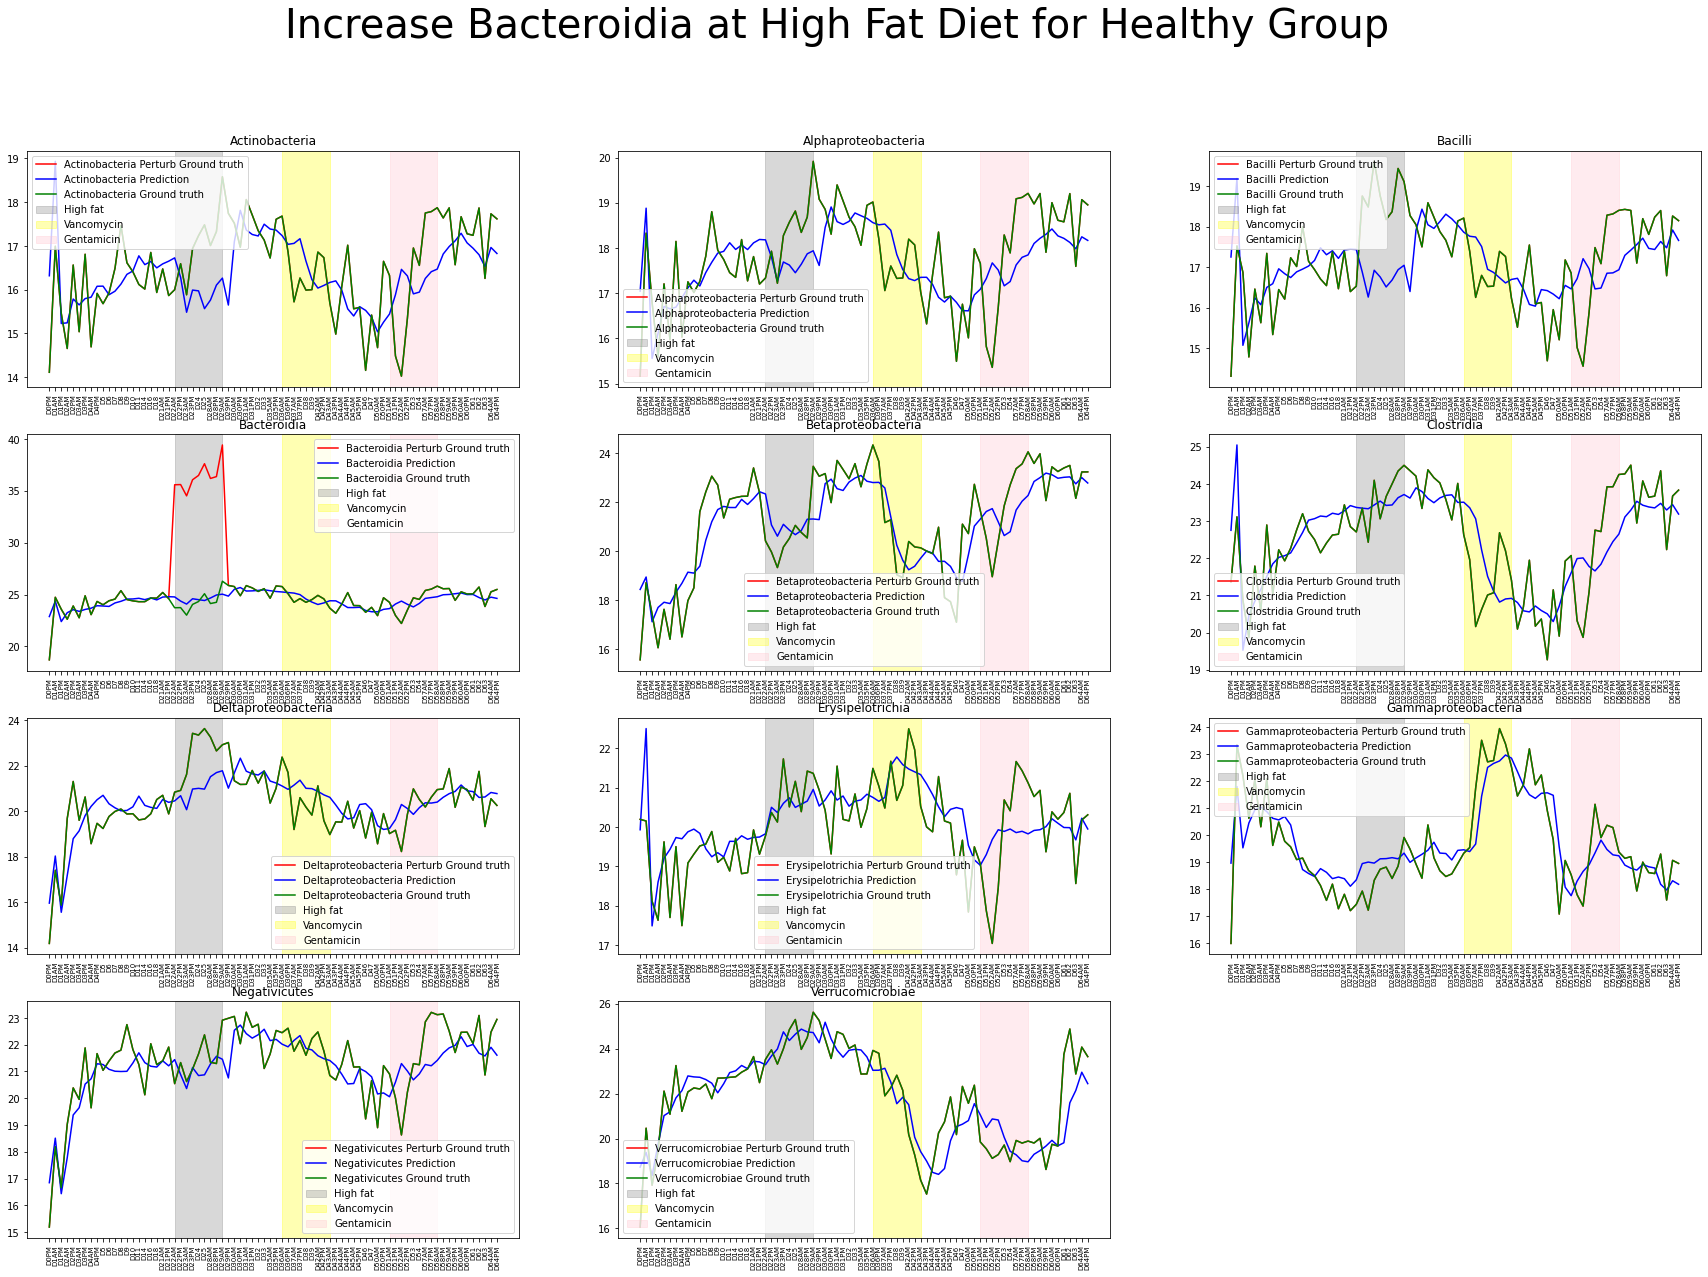

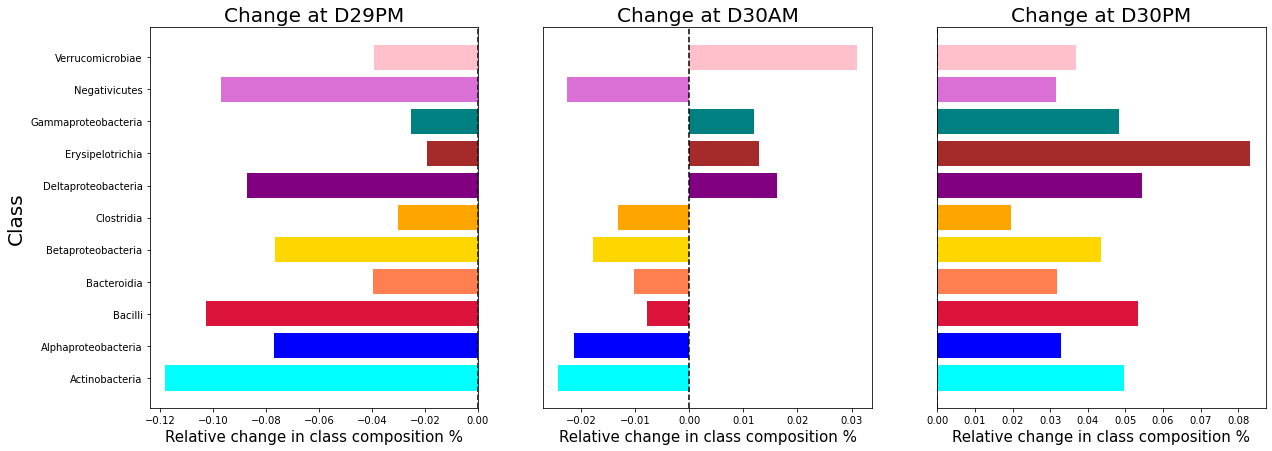

In [ ]:
sample_pred,sample_df,sample_no, perturb_pred , perturb_diff, relative_diff, mean_diff = perturb_ab ([time_3], 3,
                                                                                                     'Bacteroidia',
                                                                                                     perturb1, 
                                                                                                     response1,
                                                                                                     "Increase Bacteroidia at High Fat Diet for Healthy Group",
                                                                                                     absample3_x, absample3_y, 0.5,
                                                                                                     model_index= 1
                                                                                                    )

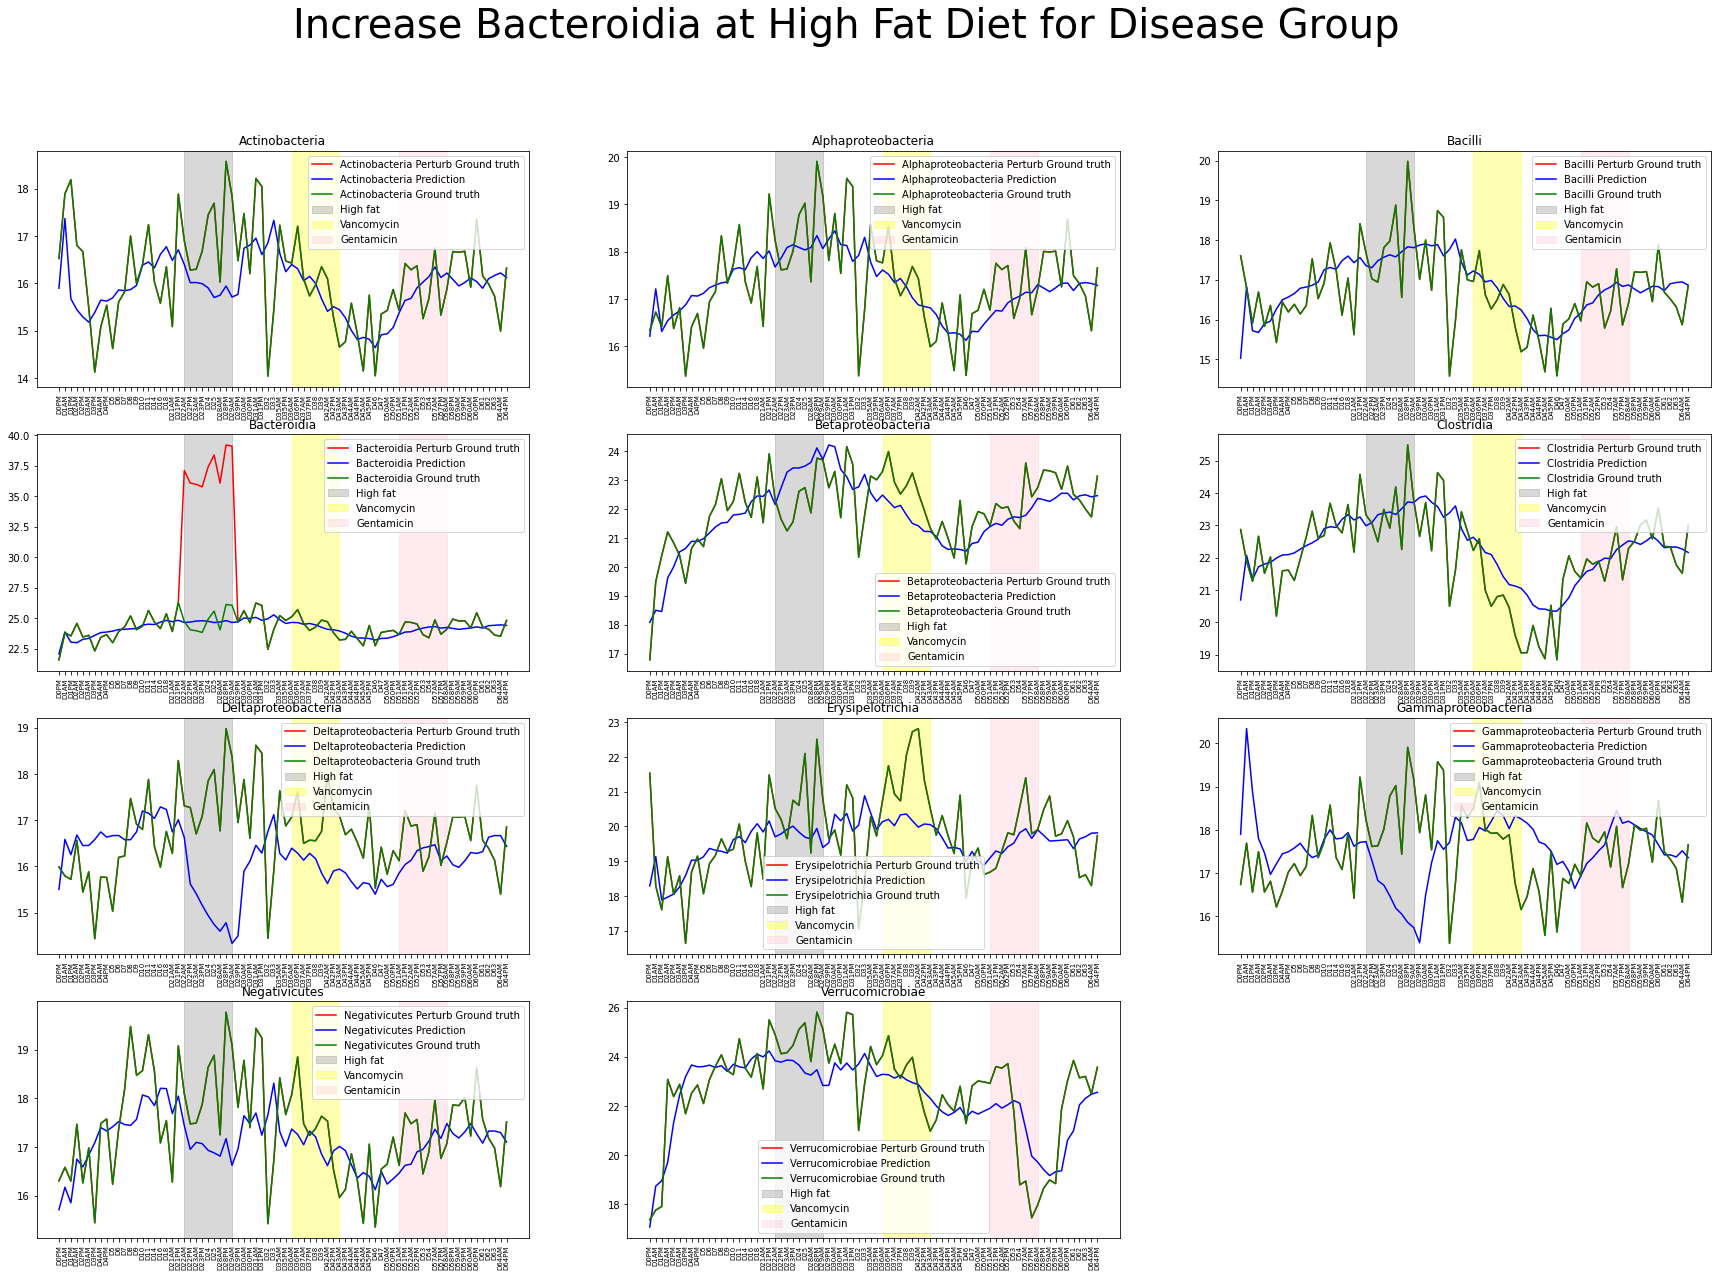

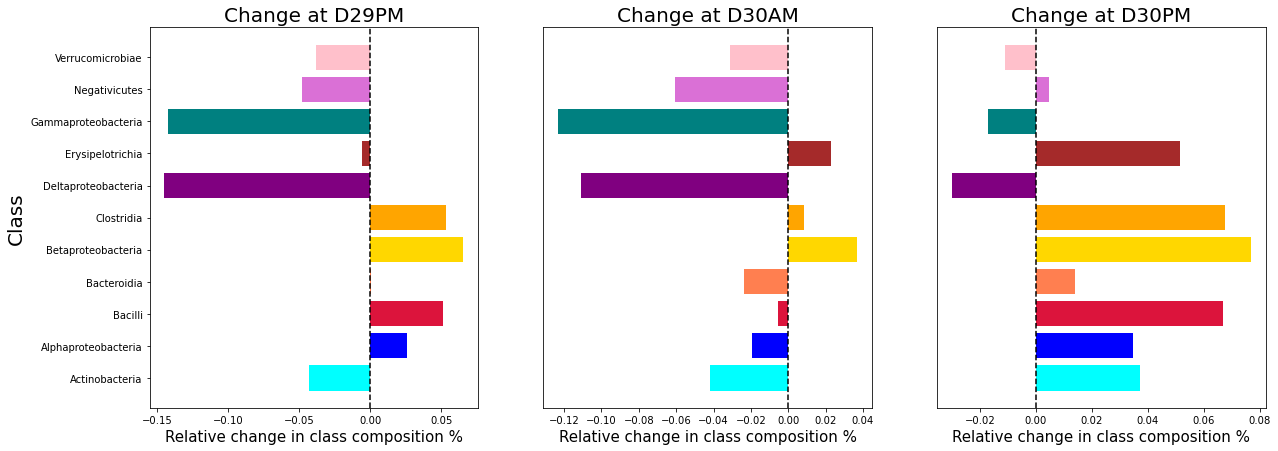

In [ ]:
sample_pred,sample_df,sample_no, perturb_pred , perturb_diff, relative_diff, mean_diff = perturb_ab ([time_8], 8,
                                                                                                     'Bacteroidia',
                                                                                                     perturb1, 
                                                                                                     response1,
                                                                                                     "Increase Bacteroidia at High Fat Diet for Disease Group",
                                                                                                     absample8_x, absample8_y, 0.5,
                                                                                                     model_index= 6
                                                                                                    )

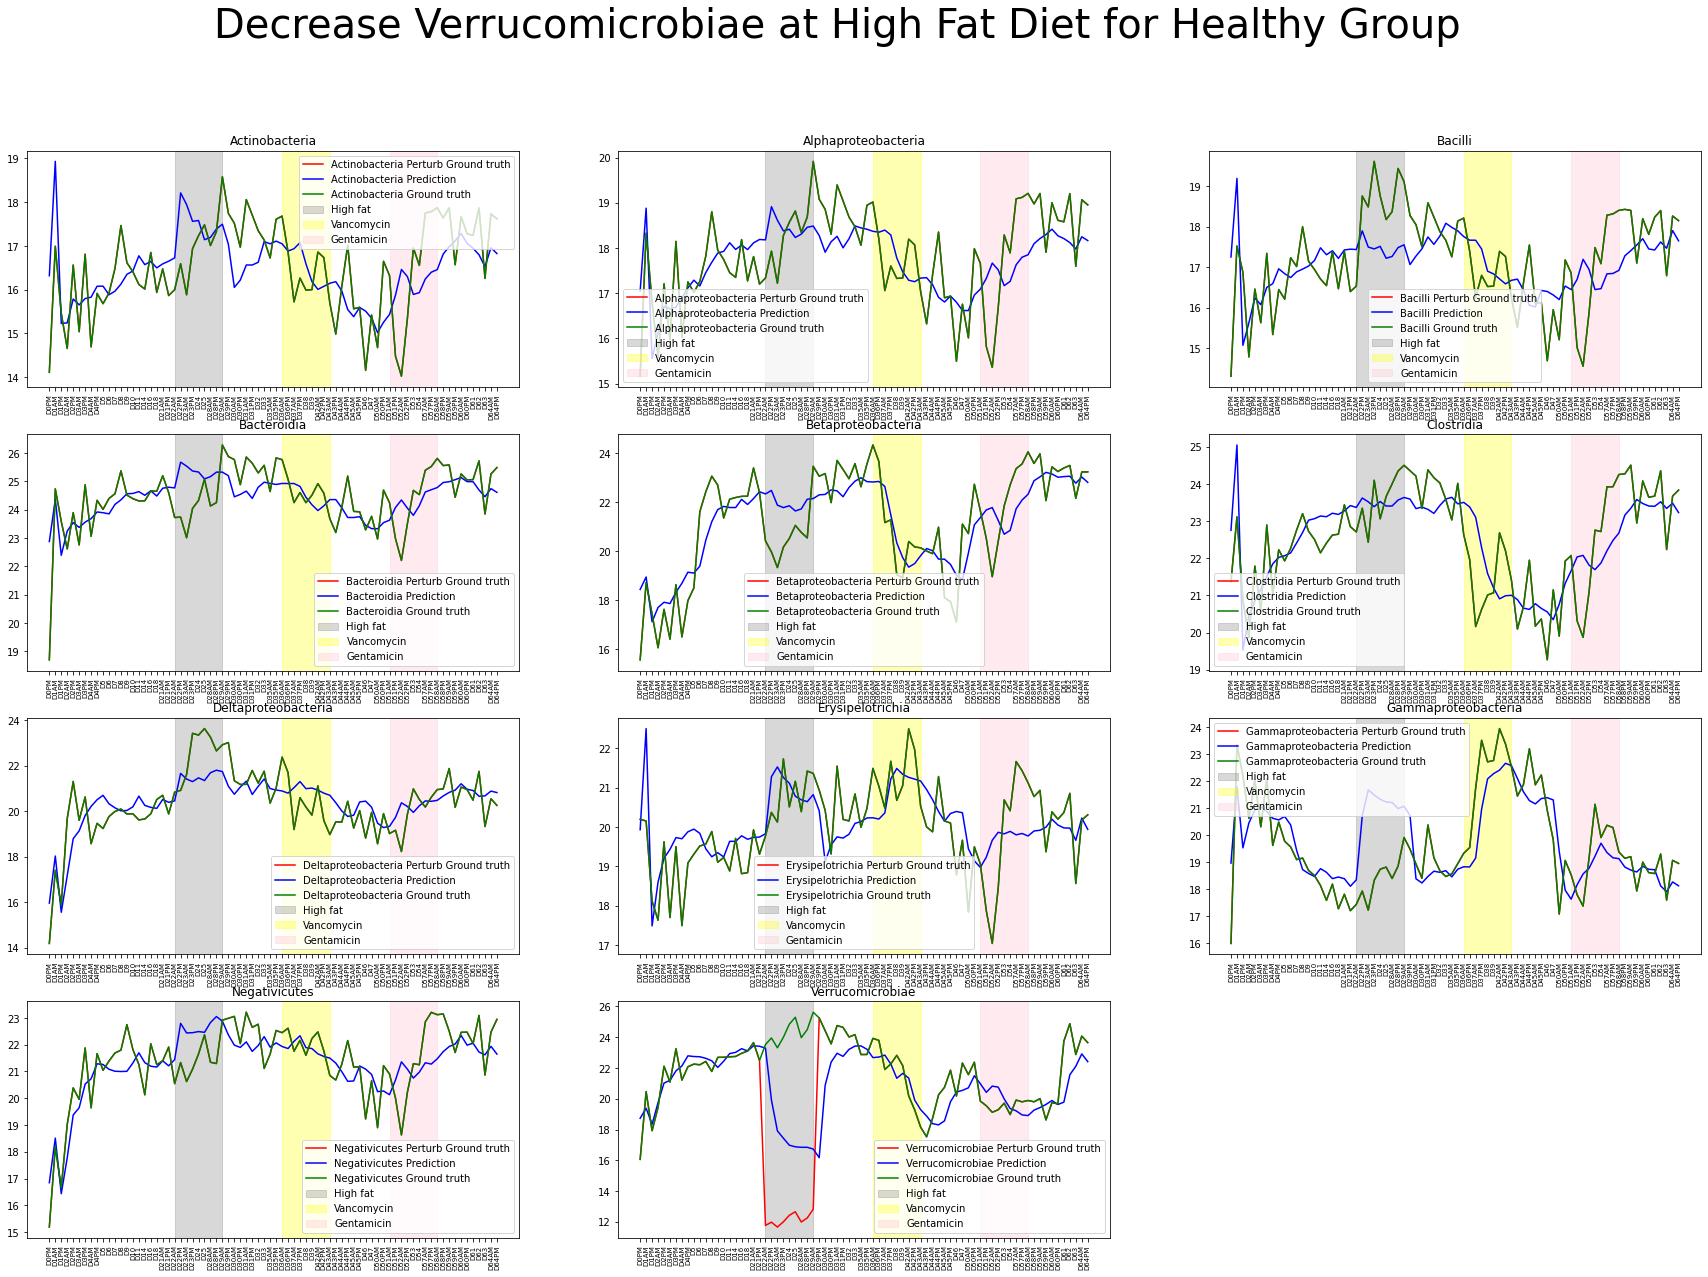

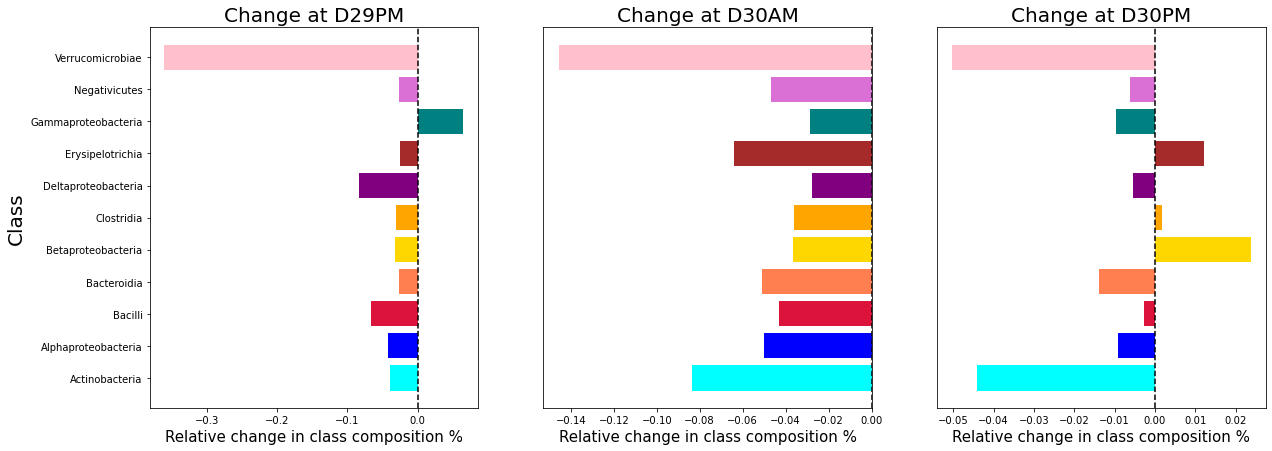

In [ ]:
sample_pred,sample_df,sample_no, perturb_pred , perturb_diff, relative_diff, mean_diff = perturb_ab ([time_3], 3,
                                                                                                     'Verrucomicrobiae',
                                                                                                     perturb1, 
                                                                                                     response1,
                                                                                                     "Decrease Verrucomicrobiae at High Fat Diet for Healthy Group",
                                                                                                     absample3_x, absample3_y, -0.5,
                                                                                                     model_index=1
                                                                                                    )

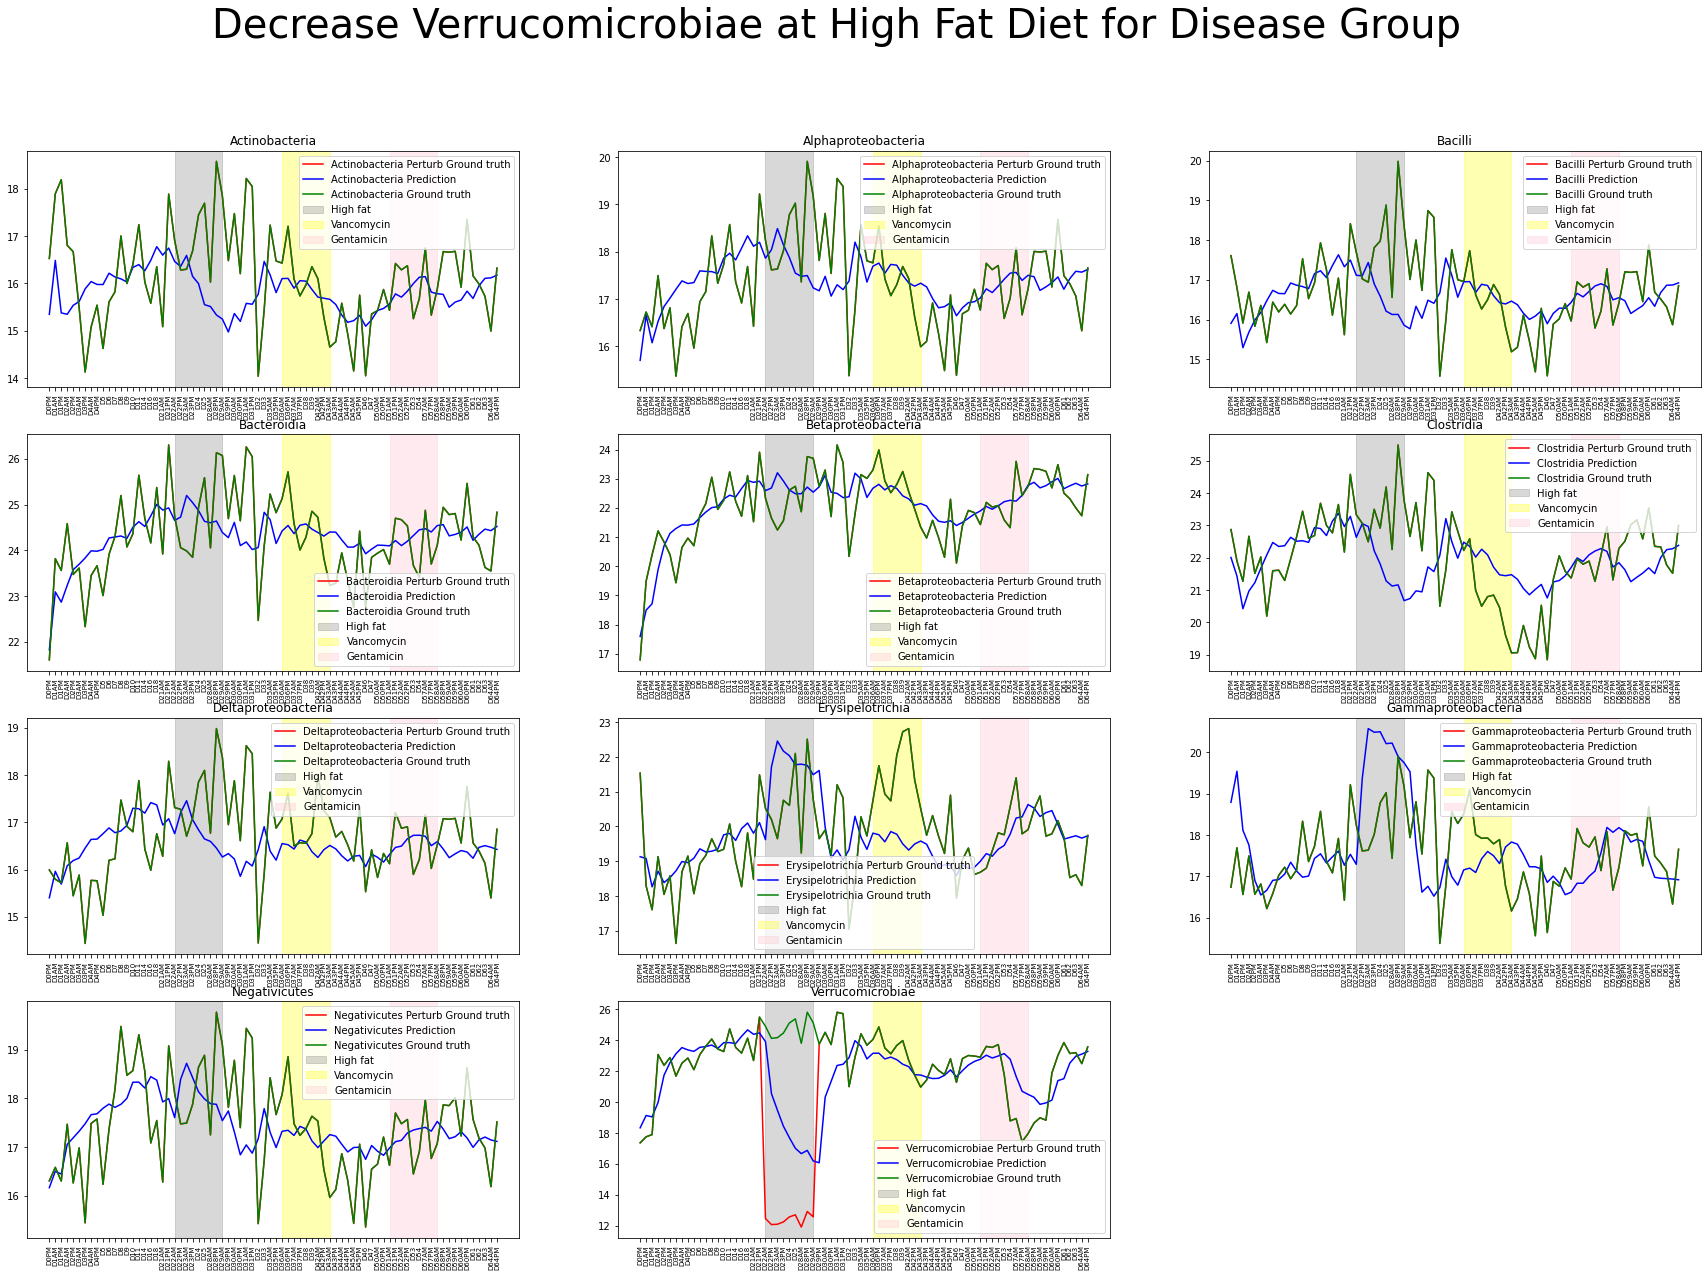

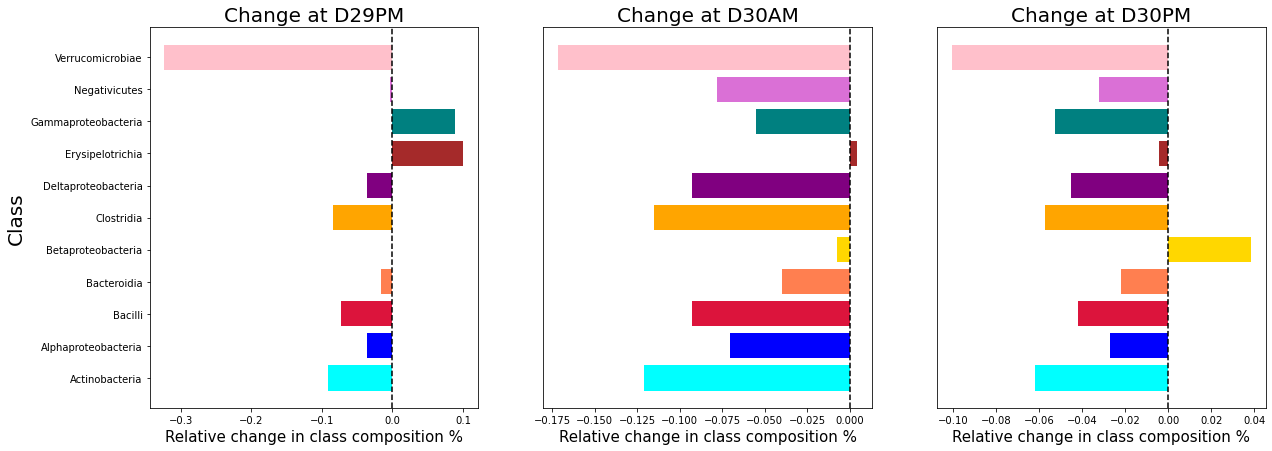

In [ ]:
sample_pred,sample_df,sample_no, perturb_pred , perturb_diff, relative_diff, mean_diff = perturb_ab ([time_8], 8,
                                                                                                     'Verrucomicrobiae',
                                                                                                     perturb1, 
                                                                                                     response1,
                                                                                                     "Decrease Verrucomicrobiae at High Fat Diet for Disease Group",
                                                                                                     absample8_x, absample8_y, -0.5,
                                                                                                     model_index=1
                                                                                                    )

## Conclusion

To summarize, two specific questions were tackled in this genetic sequencing project: 1) Whether a deep learning model can be trained to predict time series data in both relative abundance and total abundance on top eleven classes of taxonomy and 2) How relative abundance and absolute abundance change with respect to *in-silico* perturbation experiments. From the results, we can conclude that our multi-head GRU based model has a great performance with a series of data augmentation techniques. Additionally, *in-silico* perturbation provides new avenues to understand the intricacies for both host-microbe and microbe-microbe interactions. 

_Strengths:_  
* Our multi-head model can accurately categorize donor type origins to which the samples belong. It is also able to predict time series relative abundance resonably well.
* This model structure is useful for conducting *in-silico* experiments to learn species relationship inherently without needing to specify it explicitly.  

_Limitations:_  
* Our model can only predict on one taxonomy level leading to ignorance of intra-class variabilty. Many times, different strains under the same Class of taxonomy could have distinct time series dynamics given a specific perturbation.  
* Because of the scale of the data our model is able to work with, it fails to capture all the nuanced changes in absolute abundance across time points. This can be improved by including more data or research on a more accurate data augmentation method for this specific time series data.  

_Future Directions:_  
* We would like to use the same model structure and extend it to other levels of taxonomy, such as species, order and family, to have a more comprehensive representation of microbial dynamics.  
* In this project, we only surveyed a limited amount of possible combinations of changes in bacterial class and treatemnt interval. A comprehensive profiling of all possible perturbations is needed to have a more detailed examination of impacts on other species.  
* To further improve our model performance, we should implement a soft cut-off for variable selection by using auto-encoder based techniques to chose the most representative latent variables.